In [2]:
import awkward as ak
import numpy
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
fname = "root://cmsxrootd.hep.wisc.edu//store/user/kaho/NanoPost_2017_v11/GluGlu_LFV_HToEMu_M110_TuneCP5_13TeV_PSweights_powheg_pythia8/GluGlu_LFV_HToEMu_M110/220523_160817/0000/tree_1.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:200: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  warnings.warn(
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/nanoeven

In [3]:
def pZeta(leg1, leg2, MET_px, MET_py):
    leg1x = numpy.cos(leg1.phi)
    leg2x = numpy.cos(leg2.phi)
    leg1y = numpy.sin(leg1.phi)
    leg2y = numpy.sin(leg2.phi)
    zetaX = leg1x + leg2x
    zetaY = leg1y + leg2y
    zetaR = numpy.sqrt(zetaX*zetaX + zetaY*zetaY)
    
    numpy.where((zetaR > 0.), zetaX/zetaR, zetaX)
    numpy.where((zetaR > 0.), zetaY/zetaR, zetaY)
    zetaX = zetaX/zetaR
    zetaY = zetaY/zetaR
    
    visPx = leg1.px + leg2.px
    visPy = leg1.py + leg2.py
    pZetaVis = visPx*zetaX + visPy*zetaY
    px = visPx + MET_px
    py = visPy + MET_py
    
    pZeta = px*zetaX + py*zetaY
    
    return (pZeta, pZetaVis)

def Rpt(lep1, lep2, jets=None):
    emVar = lep1+lep2
    if jets==None:
        return (emVar).pt/(lep1.pt+lep2.pt)
    elif len(jets)==1:
        return (emVar + jets[0]).pt/(lep1.pt+lep2.pt+jets[0].pt)
    elif len(jets)==2:
        return (emVar + jets[0] +jets[1]).pt/(lep1.pt+lep2.pt+jets[0].pt+jets[1].pt)
    else:
        return -999
    
def Zeppenfeld(lep1, lep2, jets):
    emVar = lep1+lep2
    if len(jets)==1:
        return emVar.eta - (jets[0].eta)/2
    elif len(jets)==2:
        return emVar.eta - (jets[0].eta + jets[1].eta)/2
    else:
        return -999

def mT(lep, met):
    return numpy.sqrt(abs((numpy.sqrt(lep.mass**2+lep.pt**2) + met.pt)**2 - (lep+met).pt**2))

def pt_cen(lep1, lep2, jets):
    emVar = lep1+lep2
    if len(jets)==1:
        return emVar.pt - jets[0].pt/2
    elif len(jets)==2:
        return emVar.pt - (jets[0] + jets[1]).pt/2
    else:
        return -999
        

In [4]:
#Choice em channel and Iso27
emevents = events[(events.channel == 0)]

E_collections = emevents.Electron
M_collections = emevents.Muon

mpt_threshold = ak.where(emevents.HLT.IsoMu24, numpy.repeat(26, len(emevents)), numpy.repeat(15, len(emevents)))

#print(E_collections.pt, mpt_threshold)
#Kinematics Selections
emevents["Electron", "Target"] = ((E_collections.pt > mpt_threshold) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.pfRelIso03_all < 0.1) & (E_collections.lostHits<2))
emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

E_collections = emevents.Electron[emevents.Electron.Target==1]
M_collections = emevents.Muon[emevents.Muon.Target==1]

#Opposite Charge
E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1, axis=-1), 0, axis=-1)
M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1, axis=-1), 0, axis=-1)
opp_charge = ak.flatten(E_charge*M_charge==-1)

emevents['opp_charge'] = opp_charge
emevents = emevents[opp_charge]

#Trig Matching
M_collections = emevents.Muon
trg_collections = emevents.TrigObj
M_collections = M_collections[M_collections.Target==1]

trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)

emevents = emevents[trg_Match]

Electron_collections = emevents.Electron[emevents.Electron.Target==1][:,0]
Muon_collections = emevents.Muon[emevents.Muon.Target==1][:,0]

MET_collections = emevents.MET

#Jet corrections
Jet_collections = emevents.Jet[emevents.Jet.passJet30ID==1]
Jet_collections['pt'] = Jet_collections['pt_nom']
Jet_collections['mass'] = Jet_collections['mass_nom']
Jet_collections = ak.pad_none(Jet_collections, 2)
Jet_collections[:,0]['pt']

<Array [51.7, None, None, ... 66, None, None] type='12287 * ?float32[parameters=...'>

In [6]:
a = Electron_collections.seedGain.to_numpy()
numpy.unique(a, return_counts=True)

(array([ 1,  6, 12], dtype=uint8), array([    1,    39, 12247]))

In [8]:
Jet_collections['pt'].type

awkward.highlevel.Array

In [23]:
emevents['mtrigger'] = emevents.HLT.IsoMu27
emevents['etrigger'] = emevents.HLT.Ele32_WPTight_Gsf_L1DoubleEG & (Electron_collections.pt>35)

In [7]:
E_collections.seedGain

<Array [[12], [12], [12], ... [12], [12], [12]] type='14604 * var * uint8[parame...'>

In [7]:
import correctionlib 
#Download the correct JSON files 
evaluator = correctionlib.CorrectionSet.from_file('../ScaleFactorsJSON-dev/2017_UL/photonSS.json')
evaluator["UL-Photon-SS-Unc"].evaluate("2017","ssup","EE",Electron_collections.seedGain.to_numpy())

array([1.001, 1.001, 1.001, ..., 1.001, 1.001, 1.001])

In [31]:
for i,j,k in zip(emevents['mtrigger'], emevents['etrigger'], sf):
    if True:#j and (not i):
        print(i,j,k)

False True 0.9181708693504332
False True 0.9764837622642516
False True 0.9575835466384888
False True 0.9312424659729004
False True 0.9978947639465332
False True 0.987684726715088
False True 0.994350254535675
False True 0.986270010471344
False True 0.986270010471344
False True 0.9181708693504332
False True 1.0
False True 0.9764837622642516
False True 0.9801633358001708
False True 0.994350254535675
False True 0.9900110960006714
False True 1.0
False True 0.9801633358001708
False True 1.0
False True 0.9841269850730896
False True 0.9693396091461182
False True 0.9693396091461182
False True 0.970251739025116
False True 0.9764837622642516
False True 0.9801633358001708
False True 0.9900110960006714
False True 0.9801633358001708
False True 0.9533898234367372
False True 0.9312424659729004
False True 0.986270010471344
False True 0.9764837622642516
False True 0.9920814633369446
False True 0.9714285731315612
False True 0.9900110960006714
False True 0.9533898234367372
False True 0.9714285731315612
Fa

In [16]:
for i in ak.mask(Electron_collections, (emevents['etrigger'] & (~emevents['mtrigger']))).pt:
    if i:
        print(i)

45.172523498535156
61.45042419433594
44.411128997802734
49.69121551513672
255.34983825683594
34.65522766113281
70.81925201416016
59.7701301574707
53.0623664855957
33.87056350708008
53.678810119628906
36.618614196777344
173.4009552001953
50.509971618652344
42.676876068115234
70.8329086303711
55.277626037597656
161.76010131835938
48.14051055908203
112.00582885742188
62.13465881347656
44.072147369384766
43.244537353515625
34.63093948364258
97.0666732788086
64.83174896240234
42.798744201660156
75.7540512084961
41.579811096191406
48.20426940917969
46.99128341674805
76.40459442138672
53.121437072753906
153.0736846923828
60.07677459716797
60.01466751098633
43.39944839477539
58.9099235534668
36.76129150390625
62.94914245605469
55.415992736816406
95.55658721923828
56.19137191772461
40.306068420410156
103.4566650390625
78.84724426269531
53.73317337036133
37.37022399902344
116.88304901123047
42.52444839477539
56.99814987182617
63.76248550415039
51.345367431640625
250.5860137939453
42.676643371582

In [12]:
for i in ak.mask(Electron_collections, (emevents['etrigger'] & ~emevents['mtrigger'])).pt:
    if i:
        print(i)

45.172523498535156
61.45042419433594
44.411128997802734
49.69121551513672
255.34983825683594
34.65522766113281
70.81925201416016
59.7701301574707
53.0623664855957
33.87056350708008
53.678810119628906
36.618614196777344
173.4009552001953
50.509971618652344
42.676876068115234
70.8329086303711
55.277626037597656
161.76010131835938
48.14051055908203
112.00582885742188
62.13465881347656
44.072147369384766
43.244537353515625
34.63093948364258
97.0666732788086
64.83174896240234
42.798744201660156
75.7540512084961
41.579811096191406
48.20426940917969
46.99128341674805
76.40459442138672
53.121437072753906
153.0736846923828
60.07677459716797
60.01466751098633
43.39944839477539
58.9099235534668
36.76129150390625
62.94914245605469
55.415992736816406
95.55658721923828
56.19137191772461
40.306068420410156
103.4566650390625
78.84724426269531
53.73317337036133
37.37022399902344
116.88304901123047
42.52444839477539
56.99814987182617
63.76248550415039
51.345367431640625
250.5860137939453
42.676643371582

In [249]:
tmpElectron_collections = ak.zip(
      {
         "pt":   Electron_collections.pt,
         "eta":  Electron_collections.eta,
         "phi":  Electron_collections.phi,
         "mass": Electron_collections.mass
       },
         with_name="PtEtaPhiMLorentzVector",
)
tmpMuon_collections = ak.zip(
      {
         "pt":   Muon_collections.pt,
         "eta":  Muon_collections.eta,
         "phi":  Muon_collections.phi,
          "mass": Muon_collections.mass
       },
         with_name="PtEtaPhiMLorentzVector",
)

In [244]:
tmpMuon_collections['pt'] = tmpMuon_collections.pt + Muon_collections.ptErr
Muon_collections.energy/tmpMuon_collections.energy

<Array [0.985, 0.98, 0.977, ... 0.98, 0.989] type='78394 * float32'>

In [245]:
Muon_collections.pt/tmpMuon_collections.pt

<Array [0.985, 0.98, 0.977, ... 0.98, 0.989] type='78394 * float32'>

In [246]:
tmpElectron_collections['pt'] = tmpElectron_collections.pt + Electron_collections.energyErr

In [248]:
Electron_collections.pt/tmpElectron_collections.pt

<Array [0.992, 0.993, 0.989, ... 0.969, 0.993] type='78394 * float32'>

In [250]:
tmpElectron_collections = tmpElectron_collections*(tmpElectron_collections.energy + Electron_collections.energyErr)/tmpElectron_collections.energy

In [251]:
Electron_collections.pt/tmpElectron_collections.pt

<Array [0.993, 0.993, 0.99, ... 0.986, 0.994] type='78394 * float32'>

In [15]:
weight_lhe = numpy.einsum("ij,i->ij", emevents.LHEPdfWeight.to_numpy(), SF)
for i in weight_lhe:
    print(i)

[69.4, 69.6, 69.3, 69.6, 69.6, 69.7, 69.6, ... 69.4, 69.4, 69.4, 69.4, 68, 70.5]
[32.4, 32.5, 32.4, 32.4, 32.5, 32.5, 32.5, ... 32.4, 32.4, 32.4, 32.4, 31.2, 33.5]
[60.2, 60.3, 60, 60.3, 60.3, 60.3, 60.3, ... 60.2, 60.2, 60.2, 60.2, 58.5, 61.5]
[53.7, 53.8, 53.6, 53.8, 53.8, 53.8, 53.8, ... 53.7, 53.7, 53.7, 53.7, 52.1, 55.2]
[52.2, 52.3, 52.1, 52.3, 52.3, 52.3, 52.3, ... 52.2, 52.2, 52.2, 52.2, 50.9, 53.3]
[56.6, 56.5, 56.6, 56.5, 56.8, 56.3, 56.7, ... 56.6, 56.6, 56.6, 56.6, 54.4, 58.6]
[66.7, 66.9, 66.5, 66.8, 66.8, 66.9, 66.8, ... 66.7, 66.7, 66.7, 66.7, 65.1, 68]
[52.6, 52.7, 52.5, 52.7, 52.7, 52.7, 52.7, ... 52.6, 52.6, 52.6, 52.6, 51.2, 53.6]
[75.3, 75.3, 75.2, 75.5, 75.5, 75.5, 75.5, ... 75.3, 75.3, 75.3, 75.3, 73.5, 76.5]
[79.6, 79.7, 79.4, 79.8, 79.6, 79.6, 79.5, ... 79.6, 79.6, 79.6, 79.6, 77.2, 82.1]
[49.4, 49.5, 49.3, 49.5, 49.5, 49.5, 49.4, ... 49.4, 49.4, 49.4, 49.4, 48.1, 50.7]
[54.2, 54.3, 54.1, 54.4, 54.4, 54.4, 54.4, ... 54.2, 54.2, 54.2, 54.2, 53.1, 54.9]
[50.8, 50.

[80.5, 80.6, 80.3, 80.7, 80.5, 80.5, 80.3, ... 80.5, 80.5, 80.5, 80.5, 78.8, 82.5]
[51.8, 52, 51.7, 51.9, 51.9, 52, 51.9, ... 51.8, 51.8, 51.8, 51.8, 51.8, 50.4, 53.1]
[38.8, 38.9, 38.7, 38.9, 38.9, 38.9, 38.8, ... 38.8, 38.8, 38.8, 38.8, 38, 39.6]
[50.8, 50.9, 50.7, 50.9, 51.1, 50.5, 50.8, ... 50.8, 50.8, 50.8, 50.8, 49, 52.8]
[54.8, 54.8, 54.7, 54.9, 54.9, 54.9, 54.9, ... 54.8, 54.8, 54.8, 54.8, 53.3, 55.9]
[62.8, 62.8, 62.7, 62.9, 63, 62.9, 63, ... 62.8, 62.8, 62.8, 62.8, 62.8, 61.1, 64.2]
[57.7, 57.7, 57.6, 57.8, 57.8, 57.8, 57.8, ... 57.7, 57.7, 57.7, 57.7, 56.2, 58.9]
[58.4, 58.5, 58.3, 58.5, 58.5, 58.4, 58.4, ... 58.4, 58.4, 58.4, 58.4, 56.6, 60.3]
[49, 49.1, 49, 49.2, 49.2, 49.2, 49.2, 49.4, ... 49, 49, 49, 49, 49.1, 49, 47.8, 50]
[48.2, 48.3, 48.2, 48.3, 48.4, 48.4, 48.4, ... 48.2, 48.2, 48.2, 48.2, 47.1, 49.1]
[60.1, 60.1, 60, 60.2, 60.2, 60.2, 60.3, ... 60.1, 60.1, 60.1, 60.1, 60.1, 58.7, 61]
[109, 109, 109, 109, 109, 109, 109, 109, ... 109, 109, 109, 109, 109, 109, 104, 114

[84.5, 84.7, 84.4, 84.7, 84.7, 84.7, 84.7, ... 84.5, 84.5, 84.5, 84.5, 82.4, 86.2]
[64.4, 64.5, 64.3, 64.6, 64.6, 64.6, 64.6, ... 64.4, 64.4, 64.4, 64.4, 62.7, 65.7]
[69.3, 69.3, 69.2, 69.5, 69.5, 69.5, 69.5, ... 69.3, 69.3, 69.3, 69.3, 67.8, 70.2]
[39.9, 40, 39.9, 40, 40, 40, 40, 40.1, ... 39.9, 39.9, 39.9, 39.9, 39.9, 38.7, 41]
[52.7, 52.7, 52.6, 52.8, 52.8, 52.8, 52.8, ... 52.7, 52.7, 52.7, 52.7, 51.2, 53.8]
[40.5, 40.5, 40.4, 40.6, 40.6, 40.6, 40.6, ... 40.5, 40.5, 40.5, 40.5, 39.4, 41.2]
[57.8, 57.8, 57.7, 57.9, 57.9, 57.9, 57.9, ... 57.8, 57.8, 57.8, 57.8, 56.2, 59.1]
[68.5, 68.5, 68.3, 68.2, 68.6, 68.5, 68.5, ... 68.5, 68.4, 68.5, 68.5, 65.2, 71.6]
[68.5, 68.7, 68.4, 68.6, 68.7, 68.7, 68.6, ... 68.5, 68.5, 68.6, 68.5, 66.7, 70.1]
[85.5, 85.6, 85.3, 85.7, 85.7, 85.7, 85.7, ... 85.5, 85.5, 85.5, 85.5, 83.2, 87.2]
[67.4, 67.5, 67.3, 67.7, 67.4, 67.4, 67.3, ... 67.4, 67.4, 67.4, 67.4, 66, 68.9]
[73.2, 73.3, 73, 73.4, 73.3, 73.3, 73.1, ... 73.2, 73.2, 73.2, 73.2, 71.4, 75.2]
[53.5, 5

[59.1, 59.2, 59, 59.2, 59.3, 59.3, 59.2, ... 59.1, 59.1, 59.1, 59.1, 57.5, 60.5]
[71.6, 71.7, 71.4, 71.8, 71.8, 71.8, 71.8, ... 71.6, 71.6, 71.6, 71.6, 70, 72.6]
[68.5, 68.6, 68.4, 68.6, 68.7, 68.7, 68.7, ... 68.5, 68.5, 68.5, 68.5, 66.9, 69.6]
[60.5, 60.6, 60.4, 60.6, 60.6, 60.6, 60.6, ... 60.5, 60.5, 60.5, 60.5, 59, 61.6]
[41.5, 41.6, 41.4, 41.6, 41.6, 41.6, 41.6, ... 41.5, 41.5, 41.5, 41.5, 40.4, 42.5]
[58.4, 58.5, 58.2, 58.4, 58.4, 58.5, 58.3, ... 58.4, 58.3, 58.4, 58.4, 56.7, 60]
[53.4, 53.5, 53.4, 53.6, 53.6, 53.6, 53.6, ... 53.4, 53.4, 53.4, 53.4, 52, 54.6]
[47.8, 47.9, 47.7, 47.9, 47.9, 48, 47.9, ... 47.8, 47.8, 47.8, 47.8, 46.6, 48.8]
[55.5, 55.6, 55.4, 55.6, 55.6, 55.7, 55.6, ... 55.5, 55.5, 55.5, 55.5, 53.9, 56.9]
[52.1, 52.2, 52.1, 52.2, 52.1, 52.3, 52.1, ... 52.1, 52.1, 52.1, 52.1, 49.8, 54.3]
[49.9, 49.9, 49.7, 49.9, 50, 49.9, 50, ... 49.9, 49.9, 49.9, 49.9, 49.9, 48, 51.8]
[47.2, 47.3, 47.1, 47.3, 47.3, 47.3, 47.4, ... 47.2, 47.2, 47.2, 47.2, 46.2, 47.9]
[65.9, 66, 65.7,

[45.5, 45.5, 45.4, 45.6, 45.6, 45.6, 45.7, ... 45.5, 45.5, 45.5, 45.5, 44.3, 46.5]
[79.7, 79.9, 79.5, 79.8, 79.8, 79.9, 79.7, ... 79.7, 79.7, 79.7, 79.7, 77.5, 81.8]
[60.5, 60.5, 60.4, 60.6, 60.6, 60.6, 60.6, ... 60.5, 60.5, 60.5, 60.5, 58.8, 61.9]
[91.5, 91.8, 91.4, 91.7, 91.7, 91.8, 91.7, ... 91.5, 91.5, 91.6, 91.5, 89.2, 93.5]
[42.4, 42.4, 42.3, 42.5, 42.5, 42.5, 42.5, ... 42.4, 42.4, 42.4, 42.4, 41.5, 43]
[81.2, 81.4, 81, 81.3, 81.4, 81.4, 81.3, ... 81.2, 81.2, 81.2, 81.2, 79.1, 82.9]
[59, 59.1, 58.9, 59.1, 59.2, 59.2, 59.2, 59.6, ... 59, 59, 59, 59, 59, 57.8, 59.7]
[107, 107, 107, 107, 107, 107, 107, 108, ... 107, 107, 107, 107, 107, 107, 103, 111]
[41.2, 41.3, 41.1, 41.3, 41.3, 41.4, 41.3, ... 41.2, 41.2, 41.2, 41.2, 40.1, 42.2]
[30.4, 30.4, 30.3, 30.4, 30.4, 30.4, 30.4, ... 30.4, 30.4, 30.4, 30.4, 29.3, 31.3]
[69.1, 69.2, 68.9, 69.2, 69.2, 69.2, 69.1, ... 69.1, 69.1, 69.1, 69.1, 66.9, 71.1]
[92.5, 92.7, 92.4, 92.8, 92.8, 92.8, 92.8, ... 92.5, 92.5, 92.6, 92.5, 90.7, 93.8]
[39, 3

[64.4, 64.5, 64.2, 64.5, 64.5, 64.5, 64.5, ... 64.4, 64.4, 64.4, 64.4, 62.9, 65.4]
[24.1, 24, 24, 24.1, 24.1, 24, 24.1, ... 24.1, 24.1, 24.1, 24.1, 24.1, 23.1, 25.2]
[70.5, 70.7, 70.4, 70.7, 70.7, 70.7, 70.5, ... 70.5, 70.5, 70.5, 70.5, 69, 71.9]
[63.6, 63.7, 63.5, 63.8, 63.8, 63.8, 63.9, ... 63.6, 63.6, 63.6, 63.6, 62.3, 64.4]
[56.6, 56.8, 56.5, 56.7, 56.7, 56.8, 56.7, ... 56.6, 56.6, 56.6, 56.6, 55, 58.1]
[66.5, 66.6, 66.4, 66.6, 66.6, 66.6, 66.7, ... 66.5, 66.5, 66.5, 66.5, 64.1, 68.6]
[92, 91.9, 91.9, 92.3, 92.1, 91.9, 92.2, 92.1, ... 92, 92, 92, 92, 92, 88.7, 95.5]
[54.3, 54.3, 54.2, 54.4, 54.4, 54.4, 54.4, ... 54.3, 54.3, 54.3, 54.3, 52.8, 55.4]
[47.2, 47.3, 47.2, 47.3, 47.4, 47.4, 47.4, ... 47.2, 47.2, 47.2, 47.2, 46.2, 48]
[76.1, 76.3, 76, 76.3, 76.3, 76.3, 76.3, ... 76.1, 76.1, 76.1, 76.1, 74.1, 77.8]
[37.7, 37.7, 37.6, 37.7, 37.7, 37.7, 37.7, ... 37.7, 37.7, 37.7, 37.7, 36.5, 38.8]
[68.6, 68.7, 68.4, 68.7, 68.7, 68.8, 68.8, ... 68.6, 68.6, 68.6, 68.6, 67.1, 69.7]
[65, 65.1, 6

[64.8, 65, 64.6, 64.9, 64.9, 64.9, 64.8, ... 64.8, 64.8, 64.8, 64.8, 63.1, 66.3]
[62.4, 62.5, 62.3, 62.6, 62.6, 62.6, 62.6, ... 62.4, 62.4, 62.4, 62.4, 61.1, 63.3]
[33.3, 33.3, 33.2, 33.3, 33.4, 33.3, 33.4, ... 33.3, 33.3, 33.3, 33.3, 32.4, 34]
[58.5, 58.5, 58.4, 58.6, 58.6, 58.6, 58.6, ... 58.5, 58.5, 58.5, 58.5, 56.9, 59.9]
[35.3, 35.3, 35.2, 35.4, 35.4, 35.4, 35.4, ... 35.3, 35.3, 35.3, 35.3, 34.3, 36]
[47.2, 47.3, 47.1, 47.3, 47.3, 47.3, 47.2, ... 47.2, 47.2, 47.2, 47.2, 46, 48.3]
[81.6, 81.6, 81.5, 81.8, 81.5, 81.5, 81.4, ... 81.6, 81.6, 81.6, 81.6, 79.8, 83.9]
[66.6, 66.8, 66.4, 66.7, 66.7, 66.7, 66.6, ... 66.6, 66.6, 66.6, 66.6, 64.7, 68.3]
[69.6, 69.6, 69.5, 69.8, 69.8, 69.8, 69.8, ... 69.6, 69.6, 69.6, 69.6, 68, 70.7]
[105, 105, 105, 105, 105, 105, 105, 105, ... 105, 105, 105, 105, 105, 105, 102, 107]
[58.4, 58.5, 58.4, 58.6, 58.6, 58.6, 58.6, ... 58.4, 58.4, 58.4, 58.4, 56.9, 59.7]
[72.8, 72.9, 72.8, 73.6, 72.2, 73.4, 73.1, ... 72.5, 73.3, 73, 73, 72.8, 70.4, 75.9]
[50.4, 50.

In [16]:
weight_lhe[:,0]

<Array [69.4, 32.4, 60.2, ... 47.6, 58.7, 46.5] type='6044 * float32'>

In [24]:
vec4 = ak.zip(
    {
        "pt": Electron_collections.pt,
        "eta": Electron_collections.eta,
        "phi": Electron_collections.phi,
        "mass": Electron_collections.mass,
    },
    with_name="PtEtaPhiMLorentzVector",
)
vec4

<PtEtaPhiMLorentzVectorArray [{pt: 69.4, ... mass: -0.00465}] type='6044 * PtEta...'>

In [25]:
vec4/vec4.mass

<PtEtaPhiMLorentzVectorArray [{pt: 3.44e+03, ... mass: -1}] type='6044 * PtEtaPh...'>

In [22]:
vec4

<PtEtaPhiMLorentzVectorArray [{pt: 34.7, ... mass: -0.00232}] type='6044 * PtEta...'>

In [68]:
import correctionlib 

# Load CorrectionSet
fname = "../jsonpog-integration/POG/EGM/2017_UL/electron.json.gz"
evaluator = correctionlib.CorrectionSet.from_file(fname)
valsf= evaluator["UL-Electron-ID-SF"].evaluate("2017","sf","RecoAbove20", Electron_collections.eta.to_numpy(), Electron_collections.pt.to_numpy())
#val = evaluator["NUM_TightID_DEN_TrackerMuons"].evaluate("2017_UL", abs(Muon_collections.eta).to_numpy(), Muon_collections.pt.to_numpy(), "sf")
print(val)


[0.98240178 0.9871638  0.9871638  ... 0.9871638  0.99091726 0.9871638 ]


In [69]:
for i,j in zip(val, Electron_collections.Reco_SF):
    print(i,j)

0.9824017821465342 0.9887983798980713
0.9871638011006828 0.9261430501937866
0.9871638011006828 0.9825819730758667
0.9893528963937902 0.9825819730758667
0.9871638011006828 0.9825819730758667
0.9893528963937902 0.9834368824958801
0.9824017821465342 0.9825819730758667
0.9871638011006828 0.9887983798980713
0.9881735800442728 0.9847250580787659
0.970358299873981 1.004094123840332
0.9893528963937902 0.9867346882820129
0.9871638011006828 0.9897540807723999
0.989450562263472 0.9836233258247375
0.9871638011006828 0.9897540807723999
0.9893528963937902 0.9876543283462524
0.988569587464391 0.9867346882820129
0.983211478547372 0.998976469039917
0.9881735800442728 0.9887983798980713
0.9893528963937902 0.9897750616073608
0.9901265754533496 0.9897750616073608
0.9901265754533496 0.9897750616073608
0.9893528963937902 0.9887983798980713
0.9871638011006828 0.9938398599624634
0.9890587934386978 0.9866529703140259
0.9871638011006828 0.9897540807723999
0.991361474230638 0.9897540807723999
0.991361474230638 0

0.970358299873981 0.9836233258247375
0.9824017821465342 0.988752543926239
0.9893528963937902 0.9834368824958801
0.9871638011006828 0.9887640476226807
0.9890587934386978 0.988752543926239
0.9871638011006828 0.9938398599624634
0.9871638011006828 0.9897540807723999
0.988569587464391 0.988752543926239
0.991361474230638 0.988752543926239
0.991361474230638 0.9897540807723999
0.991361474230638 0.9788306355476379
0.9677621936001002 0.9574015140533447
0.9871638011006828 0.9886481165885925
0.991361474230638 0.9897540807723999
0.991361474230638 0.9897540807723999
0.9871638011006828 0.9887983798980713
0.9871638011006828 0.9847250580787659
0.9881735800442728 0.9938398599624634
0.9881735800442728 0.998976469039917
0.9893528963937902 0.9825819730758667
0.9871638011006828 0.9938398599624634
0.9871638011006828 0.9803516268730164
0.9824017821465342 0.9897750616073608
0.9901265754533496 0.9938398599624634
0.9893528963937902 0.9897540807723999
0.983211478547372 0.9867346882820129
0.9893528963937902 0.9897

0.9901265754533496 0.9867346882820129
0.9901265754533496 1.004094123840332
0.9909172603300768 0.998976469039917
0.9909172603300768 1.0010162591934204
0.988569587464391 0.9866529703140259
0.991361474230638 0.988752543926239
0.9893528963937902 0.9867346882820129
0.9881735800442728 0.9574015140533447
0.991361474230638 0.9887640476226807
0.9890587934386978 0.998976469039917
0.9881735800442728 0.9897750616073608
0.9901265754533496 0.9834368824958801
0.9890587934386978 0.998976469039917
0.9881735800442728 0.9847250580787659
0.9901265754533496 0.9834368824958801
0.991361474230638 0.9764344096183777
0.9893528963937902 0.9887983798980713
0.9893528963937902 0.978723406791687
0.9893528963937902 0.9938398599624634
0.9824017821465342 0.9897540807723999
0.9871638011006828 0.988752543926239
0.9881735800442728 0.988752543926239
0.9893528963937902 0.9867346882820129
0.9881735800442728 0.9825819730758667
0.9871638011006828 0.9867346882820129
0.9881735800442728 0.9887983798980713
0.9890587934386978 0.994

0.9890587934386978 0.9847250580787659
0.983211478547372 0.9847250580787659
0.9871638011006828 0.9897540807723999
0.9871638011006828 0.988752543926239
0.9881735800442728 0.9866529703140259
0.9881735800442728 0.9825819730758667
0.9871638011006828 0.9866666793823242
0.9881735800442728 0.9938398599624634
0.9871638011006828 0.9867346882820129
0.991361474230638 0.9887983798980713
0.9908099250187936 0.9847250580787659
0.9752601512900864 0.9867346882820129
0.9752601512900864 0.9897750616073608
0.9871638011006828 0.9897540807723999
0.9826989601771536 0.9938398599624634
0.9881735800442728 0.9897750616073608
0.9826989601771536 0.9867346882820129
0.9871638011006828 0.9887983798980713
0.9901265754533496 0.9897540807723999
0.9824017821465342 0.9887983798980713
0.9893528963937902 0.9825819730758667
0.9871638011006828 0.9938398599624634
0.9901265754533496 0.9917355179786682
0.9826989601771536 0.9917355179786682
0.988569587464391 0.9834368824958801
0.9871638011006828 0.9887983798980713
0.98935289639379

0.9871638011006828 0.9887983798980713
0.9893528963937902 0.9897750616073608
0.9881735800442728 0.988752543926239
0.9871638011006828 0.9938398599624634
0.9881735800442728 0.9825819730758667
0.988569587464391 0.9866529703140259
0.9871638011006828 0.9938398599624634
0.983211478547372 0.9917355179786682
0.9677621936001002 0.98221755027771
0.9871638011006828 0.988752543926239
0.9871638011006828 0.9897540807723999
0.9871638011006828 0.9887983798980713
0.9893528963937902 0.9876543283462524
0.9871638011006828 0.9834368824958801
0.9901265754533496 0.9866666793823242
0.9752601512900864 0.9887640476226807
0.9893528963937902 0.9825819730758667
0.9871638011006828 0.9897540807723999
0.9677621936001002 0.9803516268730164
0.9871638011006828 0.9938398599624634
0.9881735800442728 0.9938398599624634
0.9881735800442728 0.9938398599624634
0.9893528963937902 0.9867346882820129
0.9871638011006828 0.988752543926239
0.988569587464391 0.9897750616073608
0.988569587464391 0.9866529703140259
0.988569587464391 0.9

0.988569587464391 0.998976469039917
0.988569587464391 0.998976469039917
0.9881735800442728 0.9938398599624634
0.9901265754533496 0.9867346882820129
0.9881735800442728 0.988752543926239
0.9881735800442728 0.998976469039917
0.9893528963937902 0.9825819730758667
0.9826989601771536 0.9887983798980713
0.9890587934386978 0.9867346882820129
0.9871638011006828 0.9897540807723999
0.9901265754533496 0.9897750616073608
0.991361474230638 0.9876543283462524
0.9677621936001002 0.9866529703140259
0.9901265754533496 0.9825819730758667
0.9871638011006828 0.9938398599624634
0.9871638011006828 0.9803516268730164
0.9893528963937902 0.9834368824958801
0.9871638011006828 0.9887983798980713
0.9824017821465342 0.988752543926239
0.9893528963937902 0.9878296256065369
0.988569587464391 0.98221755027771
0.970358299873981 0.9867346882820129
0.9901265754533496 0.9817400574684143
0.9871638011006828 0.9866666793823242
0.9871638011006828 0.9938398599624634
0.9893528963937902 0.9938398599624634
0.9881735800442728 0.989

0.988569587464391 0.9876543283462524
0.9753358818465124 0.9764344096183777
0.9871638011006828 0.9803516268730164
0.9890587934386978 0.9866529703140259
0.9826989601771536 0.9878296256065369
0.9871638011006828 0.9938398599624634
0.9824017821465342 0.9897750616073608
0.9826795261832796 0.9803516268730164
0.9909172603300768 1.0010162591934204
0.9871638011006828 0.9938398599624634
0.9871638011006828 0.988752543926239
0.9871638011006828 0.9917355179786682
0.9824017821465342 0.9886481165885925
0.991361474230638 0.988752543926239
0.9871638011006828 0.9938398599624634
0.988569587464391 0.9887983798980713
0.9881735800442728 0.9897750616073608
0.9824017821465342 0.9938398599624634
0.9871638011006828 0.9917355179786682
0.9890587934386978 0.9847250580787659
0.9752601512900864 0.9938398599624634
0.9871638011006828 0.9938398599624634
0.9881735800442728 0.9876543283462524
0.9893528963937902 0.9825819730758667
0.988569587464391 0.9938398599624634
0.9753358818465124 0.9876543283462524
0.9901265754533496

0.9881735800442728 0.988752543926239
0.9901265754533496 0.9876543283462524
0.9871638011006828 0.9938398599624634
0.9893528963937902 0.9825819730758667
0.988569587464391 0.9825819730758667
0.9909172603300768 0.9938398599624634
0.9871638011006828 0.98221755027771
0.988569587464391 0.9867346882820129
0.9824017821465342 0.9836233258247375
0.983211478547372 1.004094123840332
0.9901265754533496 0.9938398599624634
0.991361474230638 0.9897540807723999
0.988569587464391 0.9897750616073608
0.9753358818465124 0.9876543283462524
0.9893528963937902 0.9876543283462524
0.9901265754533496 0.9834368824958801
0.9881735800442728 0.9897540807723999
0.9893528963937902 0.9788306355476379
0.9881735800442728 0.9867346882820129
0.9881735800442728 0.9847250580787659
0.9824017821465342 0.9887640476226807
0.9871638011006828 0.9897540807723999
0.9871638011006828 1.0010162591934204
0.9893528963937902 0.9938398599624634
0.9893528963937902 0.9897750616073608
0.9824017821465342 0.9897540807723999
0.9871638011006828 0.

0.9881735800442728 0.9897540807723999
0.9881735800442728 0.9834368824958801
0.9871638011006828 0.9834368824958801
0.9893528963937902 0.9876543283462524
0.988569587464391 0.9834368824958801
0.970358299873981 0.9825819730758667
0.9901265754533496 0.9834368824958801
0.988569587464391 0.9897540807723999
0.9871638011006828 0.9897540807723999
0.9901265754533496 0.9938398599624634
0.970358299873981 0.9834368824958801
0.988569587464391 0.9876543283462524
0.9881735800442728 0.9866529703140259
0.9901265754533496 0.988752543926239
0.9901265754533496 0.9887640476226807
0.9881735800442728 0.9876543283462524
0.9890587934386978 0.9876543283462524
0.988569587464391 0.9897750616073608
0.983211478547372 0.9867346882820129
0.9826989601771536 0.9897540807723999
0.9901265754533496 0.9938398599624634
0.9881735800442728 0.988752543926239
0.9871638011006828 0.9825819730758667
0.988569587464391 0.9825819730758667
0.9901265754533496 0.9897750616073608
0.9909172603300768 0.9866666793823242
0.9901265754533496 0.9

0.988569587464391 0.9867346882820129
0.9893528963937902 0.9834368824958801
0.9824017821465342 0.9938398599624634
0.9881735800442728 0.9897540807723999
0.9893528963937902 0.9897750616073608
0.9901265754533496 0.9847250580787659
0.9871638011006828 0.9897540807723999
0.988569587464391 0.9887983798980713
0.9871638011006828 0.9834368824958801
0.9881735800442728 1.0010162591934204
0.9901265754533496 0.9887983798980713
0.9893528963937902 0.9836233258247375
0.9901265754533496 0.9836233258247375
0.9871638011006828 0.9876543283462524
0.9893528963937902 0.9897750616073608
0.9871638011006828 0.9834368824958801
0.9871638011006828 0.9887983798980713
0.9871638011006828 0.9866666793823242
0.9881735800442728 0.988752543926239
0.9893528963937902 0.9867346882820129
0.9881735800442728 0.9887983798980713
0.9890587934386978 0.9867346882820129
0.9871638011006828 0.988752543926239
0.991361474230638 0.9886481165885925
0.9881735800442728 0.998976469039917
0.9908099250187936 0.9866666793823242
0.9881735800442728

0.9901265754533496 0.9887983798980713
0.9871638011006828 0.988752543926239
0.988569587464391 0.988752543926239
0.9826989601771536 0.988752543926239
0.988569587464391 0.998976469039917
0.9881735800442728 0.9825819730758667
0.988569587464391 0.9887983798980713
0.9893528963937902 0.9834368824958801
0.991361474230638 0.9836233258247375
0.9871638011006828 0.988752543926239
0.9893528963937902 0.9938398599624634
0.9893528963937902 0.9887640476226807
0.991361474230638 0.9847250580787659
0.9826989601771536 0.9836233258247375
0.9890587934386978 0.9867346882820129
0.9871638011006828 0.9897540807723999
0.988569587464391 0.9938398599624634
0.9881735800442728 0.998976469039917
0.9893528963937902 0.9834368824958801
0.9677621936001002 0.9825819730758667
0.9677621936001002 0.9867346882820129
0.988569587464391 0.9897750616073608
0.9893528963937902 0.9938398599624634
0.9871638011006828 0.9834368824958801
0.988569587464391 0.9887640476226807
0.9901265754533496 0.9887983798980713
0.991361474230638 0.993839

In [32]:
ak.prod(1-emevents.Jet.eta, axis=1)
prodsum = []
for i in emevents.Jet:
    prod = 1
    for j in i.eta:
        prod*=(1-j)
    prodsum.append(prod)
# jet_try = ak.flatten(emevents.Jet)
# print(jet_try)
# jet_where = ak.where((abs(jet_try.eta)<=2.5) & (jet_try.hadronFlavour==0))
# btagSF_deepjet_L = numpy.zeros(len(jet_try))
# btagSF_deepjet_L[jet_where] = numpy.ones(len(jet_where))
# print(jet_where)
# for i in jet_where:
#     print(btagSF_deepjet_L[i]==1)
# # jet_sub = jet_try[(abs(jet_try.eta)<=2.5) & (jet_try.hadronFlavour==0)]
# # jet_try[jet_where] = jet_sub

In [34]:
print(ak.prod(1-emevents.Jet.eta, axis=1))

[-7.97, -69.9, 3.36, -15, -12.7, 0.624, ... -0.909, -7.92, -4.54, 13.7, -1.11e+04]


In [33]:
print(prodsum)

[-7.974338907835772, -69.93679282674422, 3.357147216796875, -15.033167603134643, -12.682309905206077, 0.623968505733746, 5.01042515039444, 3.502839654956915, -1934.655902613374, 331.96193358553387, 25.010754534892182, -2.5012939599037054, 7.242439389810897, 0.2700531257978467, -5.673632660098776, 2.1536434043109685, 0.09018202254083008, 2.0815013833343983, 2.586112332908528, 0.06137860517257636, 1.186745880113449, -74.69141789368416, 0.6747585582710158, -1.465441256761551, 0.6981244031339884, -0.8958822545682779, 3292.245382388921, 753.6437783933221, -34.28956769372604, -23.363147919997573, -28.876753164651486, -0.9698931999300839, -50.99216529322812, 682.8107524275821, 2600.993265013653, -1.9581031271150269, 0.6323205720764236, 18.523584870488605, -8.553454070092094, 45.878632998160846, -68.74451833006954, -3.3201484523294766, 36.90088081781455, -0.7492078705040756, 3.19928640400758, -0.7416929702221751, 882.3735692132861, 50.02196136548856, 46.6145936666253, 3.4807877164028933, 294.1

In [77]:
import correctionlib
btag_sf = correctionlib.CorrectionSet.from_file(f"../jsonpog-integration/POG/BTV/2017_UL/btagging.json.gz")
jet_try = ak.flatten(emevents.Jet)
btag = numpy.zeros(len(jet_try))
jet_light = ak.where((abs(jet_try.eta)<=2.5) & (jet_try.hadronFlavour==0))
jet_heavy = ak.where((abs(jet_try.eta)<=2.5) & (jet_try.hadronFlavour!=0))
array_light = btag_sf["deepJet_incl"].evaluate("central", "L", jet_try[jet_light].hadronFlavour.to_numpy(), abs(jet_try[jet_light].eta).to_numpy(), jet_try[jet_light].pt_nom.to_numpy())
array_heavy = btag_sf["deepJet_comb"].evaluate("central", "L", jet_try[jet_heavy].hadronFlavour.to_numpy(), abs(jet_try[jet_heavy].eta).to_numpy(), jet_try[jet_heavy].pt_nom.to_numpy())
btag[jet_light] = array_light
btag[jet_heavy] = array_heavy
btag = ak.unflatten(btag, ak.num(emevents.Jet))
ak.prod(1-btag_unflat, axis=1)


# jet_un = ak.mask(emevents.Jet, (abs(emevents.Jet.eta)<=2.5) & (emevents.Jet.hadronFlavour==0))
# jet_try = ak.flatten(jet_un)
# print(jet_try.hadronFlavour)
# print(abs(jet_try.eta))
# print(jet_try.pt_nom)
# array = btag_sf["deepJet_incl"].evaluate("central", "L", jet_try.hadronFlavour.to_numpy(), abs(jet_try.eta).to_numpy(), jet_try.pt_nom.to_numpy())
# ak.unflatten(array, ak.num(jet_un))

<Array [-0.0358, 0.015, ... -0.0051, -0.0379] type='339 * float64'>

In [32]:
SF = emevents.puWeight*emevents.genWeight
print(SF)
print(emevents.LHEPdfWeight.to_numpy())
a = numpy.einsum("ij,i->ij", emevents.LHEPdfWeight.to_numpy(), SF)
for i in a:
    print(i)


[22.4, 21.2, 24, 23.6, 19.8, 20.4, 16.4, ... 22.4, 19.2, 22.4, 22.9, 21.2, 21.2, 24]
[[1.         1.0026855  0.9974365  ... 1.         0.9708252  1.0264282 ]
 [1.         1.0008545  0.9987488  ... 1.         0.9738159  1.0201416 ]
 [1.         1.0028687  0.99731445 ... 1.         0.9751587  1.0230103 ]
 ...
 [1.         1.0011597  0.99838257 ... 1.         0.9728699  1.024231  ]
 [1.         1.0015259  0.9981384  ... 1.         0.97128296 1.0258179 ]
 [1.         1.001648   0.998291   ... 1.         0.97109985 1.0247803 ]]
[22.4, 22.4, 22.3, 22.4, 22.4, 22.4, 22.4, ... 22.4, 22.4, 22.4, 22.4, 21.7, 23]
[21.2, 21.2, 21.2, 21.3, 21.3, 21.3, 21.3, ... 21.2, 21.2, 21.2, 21.2, 20.7, 21.6]
[24, 24, 23.9, 24, 24, 24, 24, 24, 24, ... 23.9, 24, 24, 24, 24, 24, 24, 23.4, 24.5]
[23.6, 23.7, 23.6, 23.7, 23.7, 23.7, 23.7, ... 23.6, 23.6, 23.6, 23.6, 23, 24.1]
[19.8, 19.8, 19.8, 19.9, 19.8, 19.8, 19.8, ... 19.8, 19.8, 19.8, 19.8, 19.1, 20.6]
[20.4, 20.4, 20.3, 20.4, 20.4, 20.4, 20.3, ... 20.4, 20.3,

In [26]:
SF = emevents.puWeight*emevents.genWeight

In [104]:
from coffea.lookup_tools import extractor
ext = extractor()
ext.add_weight_sets(["* * ../electron.json"])
ext.finalize()
evaluator = ext.make_evaluator()
# print("available evaluator keys:")
# for key in evaluator.keys():
#     print("\t", key)
print(evaluator)

AttributeError: 'int' object has no attribute 'keys'

In [88]:
from coffea.lookup_tools import extractor
ext = extractor()
ext.add_weight_sets(["trackerMu NUM_TrackerMuons_DEN_genTracks/abseta_pt_value ../Corrections/TrackerMu/Efficiency_muon_generalTracks_Run2017_UL_trackerMuon.json"])
ext.finalize()
evaluator = ext.make_evaluator()
print("available evaluator keys:")
for key in evaluator.keys():
    print("\t", key)
evaluator['trackerMu'](abs(Muon_collections.eta), Muon_collections.pt)
for i,j in zip(evaluator['trackerMu'](abs(Muon_collections.eta), Muon_collections.pt),  abs(Muon_collections.eta)):
    print(i,j)

available evaluator keys:
	 trackerMu
1.003943594580585 1.172119140625
1.0038041158817572 0.01058197021484375
1.0038041158817572 0.57373046875
1.011238602365917 1.66357421875
1.0038041158817572 0.6488037109375
1.011238602365917 1.308349609375
1.003943594580585 1.176025390625
1.0038041158817572 0.52001953125
1.0038041158817572 0.18768310546875
1.0 2.1953125
1.011238602365917 1.64501953125
1.0038041158817572 0.3060302734375
0.9967385515936023 0.1739501953125
1.0038041158817572 0.2501220703125
1.011238602365917 1.4462890625
1.0038041158817572 0.521240234375
1.003943594580585 1.11376953125
1.0038041158817572 0.140289306640625
1.011238602365917 1.23046875
1.011238602365917 1.451416015625
1.011238602365917 1.3095703125
1.011238602365917 1.24609375
1.0038041158817572 0.743408203125
1.0038041158817572 0.40191650390625
1.0038041158817572 0.03690338134765625
1.011238602365917 1.53076171875
1.011238602365917 1.313720703125
1.0038041158817572 0.5751953125
1.011238602365917 1.24609375
1.01123860236

1.011238602365917 1.94775390625
1.011238602365917 1.2158203125
1.0038041158817572 0.7137451171875
1.0038041158817572 0.482421875
1.0 2.13720703125
1.011238602365917 1.494140625
1.011238602365917 1.553955078125
1.011238602365917 1.320556640625
1.0038041158817572 0.1073760986328125
1.011238602365917 2.06884765625
1.003943594580585 0.9000244140625
1.003943594580585 1.053466796875
1.003943594580585 1.007080078125
1.0038041158817572 0.200775146484375
1.011238602365917 1.98681640625
1.0038041158817572 0.083404541015625
1.0038041158817572 0.7236328125
1.0 2.203125
1.0038041158817572 0.6668701171875
1.0038041158817572 0.151947021484375
1.003943594580585 1.07177734375
1.0 2.27783203125
1.003943594580585 1.117919921875
1.011238602365917 1.220703125
1.0038041158817572 0.6422119140625
1.0038041158817572 0.198974609375
1.0038041158817572 0.008699417114257812
1.0038041158817572 0.07666015625
1.0038041158817572 0.25885009765625
1.011238602365917 1.485107421875
1.011238602365917 1.830078125
1.01123860

1.0038041158817572 0.26129150390625
1.011238602365917 1.3623046875
1.0038041158817572 0.336181640625
1.011238602365917 1.646484375
1.0038041158817572 0.7169189453125
1.0038041158817572 0.7576904296875
1.011238602365917 1.303466796875
1.0038041158817572 0.38525390625
1.0038041158817572 0.672119140625
1.0038041158817572 0.2711181640625
1.011238602365917 1.564697265625
1.0038041158817572 0.07586669921875
1.0038041158817572 0.214996337890625
1.011238602365917 1.484130859375
1.003943594580585 0.97021484375
1.003943594580585 1.0234375
1.0038041158817572 0.0948486328125
1.0038041158817572 0.8150634765625
1.0038041158817572 0.6341552734375
1.0038041158817572 0.44317626953125
1.0038041158817572 0.015455245971679688
1.0038041158817572 0.1973876953125
1.003943594580585 0.92919921875
1.003943594580585 1.08203125
1.0038041158817572 0.36981201171875
1.0038041158817572 0.170623779296875
1.011238602365917 1.291748046875
1.0038041158817572 0.8380126953125
1.0038041158817572 0.35687255859375
1.003804115

1.011238602365917 1.21923828125
1.011238602365917 1.49658203125
1.011238602365917 1.3759765625
1.0 2.16796875
1.0038041158817572 0.4171142578125
1.0038041158817572 0.797607421875
1.011238602365917 1.830810546875
1.0038041158817572 0.6834716796875
1.011238602365917 1.8115234375
1.0038041158817572 0.201263427734375
1.011238602365917 1.61181640625
1.011238602365917 1.965576171875
1.0038041158817572 0.195098876953125
1.0038041158817572 0.1037750244140625
1.003943594580585 0.91845703125
1.0038041158817572 0.215606689453125
1.0038041158817572 0.7679443359375
1.0038041158817572 0.39923095703125
1.011238602365917 1.826904296875
1.0038041158817572 0.8638916015625
1.011238602365917 1.885498046875
1.011238602365917 1.31103515625
1.0038041158817572 0.133087158203125
1.0038041158817572 0.591796875
1.003943594580585 0.9742431640625
1.0038041158817572 0.40521240234375
1.0038041158817572 0.7508544921875
0.9967385515936023 0.8916015625
1.011238602365917 1.38330078125
1.0 2.36572265625
1.003943594580585

1.011238602365917 1.749755859375
1.0038041158817572 0.1098175048828125
1.003943594580585 1.163818359375
1.0 2.189453125
1.0038041158817572 0.163970947265625
1.003943594580585 1.076416015625
1.011238602365917 1.682861328125
1.003943594580585 0.961181640625
1.003943594580585 1.0830078125
1.0038041158817572 0.12255859375
1.0038041158817572 0.230133056640625
1.003943594580585 1.159423828125
1.003943594580585 1.01220703125
1.0038041158817572 0.5391845703125
1.011238602365917 1.69482421875
1.011238602365917 2.03759765625
1.011238602365917 1.28515625
1.011238602365917 1.302490234375
1.0038041158817572 0.89697265625
1.0038041158817572 0.222381591796875
1.003943594580585 1.12744140625
1.011238602365917 1.259033203125
1.0038041158817572 0.1133270263671875
1.011238602365917 1.229736328125
1.011238602365917 1.4794921875
1.011238602365917 1.728759765625
1.003943594580585 0.9908447265625
1.003943594580585 0.9404296875
1.0038041158817572 0.86181640625
1.0038041158817572 0.16015625
1.011238602365917 1

1.0038041158817572 0.7728271484375
1.0038041158817572 0.020565032958984375
1.0038041158817572 0.8250732421875
1.0038041158817572 0.5277099609375
1.011238602365917 1.24853515625
1.011238602365917 1.6162109375
1.0038041158817572 0.5177001953125
1.003943594580585 1.08837890625
1.0038041158817572 0.5679931640625
1.0038041158817572 0.5323486328125
1.0038041158817572 0.7921142578125
1.0038041158817572 0.69140625
1.003943594580585 1.057373046875
1.0038041158817572 0.7498779296875
1.011238602365917 1.69677734375
1.011238602365917 1.96875
1.011238602365917 1.269287109375
1.011238602365917 1.731689453125
1.0038041158817572 0.2862548828125
1.0038041158817572 0.25177001953125
1.0038041158817572 0.56494140625
1.011238602365917 1.925048828125
1.0 2.35546875
1.011238602365917 1.65185546875
1.003943594580585 1.080810546875
1.0038041158817572 0.0646820068359375
1.003943594580585 1.05908203125
1.0038041158817572 0.73291015625
1.011238602365917 1.71875
1.011238602365917 1.923095703125
1.0038041158817572 

1.011238602365917 1.984619140625
1.003943594580585 1.1298828125
1.003943594580585 1.029541015625
1.011238602365917 1.755126953125
1.003943594580585 1.0732421875
1.0038041158817572 0.8472900390625
1.011238602365917 1.47021484375
1.0038041158817572 0.4188232421875
1.011238602365917 1.3623046875
1.011238602365917 1.509033203125
1.011238602365917 1.291748046875
1.003943594580585 1.028076171875
1.003943594580585 0.9998779296875
1.0038041158817572 0.6358642578125
1.011238602365917 1.361083984375
1.011238602365917 1.569580078125
1.0038041158817572 0.1239776611328125
1.0 2.326171875
1.0038041158817572 0.82666015625
1.0038041158817572 0.3865966796875
1.0038041158817572 0.6912841796875
1.0038041158817572 0.77880859375
1.0038041158817572 0.728759765625
1.011238602365917 1.877197265625
1.011238602365917 1.37255859375
1.0038041158817572 0.559814453125
1.0038041158817572 0.1790771484375
1.0038041158817572 0.32672119140625
1.011238602365917 1.31494140625
1.0038041158817572 0.192352294921875
1.0038041

1.0038041158817572 0.2908935546875
1.0038041158817572 0.44500732421875
1.0038041158817572 0.2843017578125
1.0038041158817572 0.61865234375
1.011238602365917 1.2421875
1.0038041158817572 0.34051513671875
1.011238602365917 1.8876953125
1.011238602365917 1.90869140625
1.0038041158817572 0.25885009765625
1.0038041158817572 0.010992050170898438
1.0038041158817572 0.01126861572265625
1.011238602365917 1.58203125
1.003943594580585 0.9212646484375
1.0038041158817572 0.720458984375
1.011238602365917 1.455810546875
1.011238602365917 1.58935546875
1.0038041158817572 0.029582977294921875
1.0038041158817572 0.3214111328125
1.0038041158817572 0.0769500732421875
1.0038041158817572 0.7816162109375
1.0038041158817572 0.487548828125
1.003943594580585 1.05029296875
1.0038041158817572 0.1689453125
1.011238602365917 1.533935546875
1.003943594580585 1.09912109375
1.0038041158817572 0.0067996978759765625
1.011238602365917 1.6953125
1.0 2.234375
1.0038041158817572 0.598388671875
1.0038041158817572 0.564697265

1.003943594580585 0.9593505859375
1.0038041158817572 0.6376953125
1.003943594580585 0.9652099609375
1.0038041158817572 0.6380615234375
1.0038041158817572 0.469970703125
1.0038041158817572 0.713623046875
1.0038041158817572 0.819091796875
1.0038041158817572 0.229156494140625
1.003943594580585 0.9361572265625
1.003943594580585 0.955078125
1.011238602365917 1.51171875
1.0038041158817572 0.242706298828125
1.0 2.2685546875
1.0038041158817572 0.584228515625
1.011238602365917 2.04833984375
1.0 2.32373046875
1.0038041158817572 0.8143310546875
1.011238602365917 1.25048828125
1.0038041158817572 0.5047607421875
1.0038041158817572 0.0699310302734375
1.011238602365917 1.80078125
1.003943594580585 0.998779296875
1.0 2.2626953125
1.011238602365917 1.267578125
1.011238602365917 1.29052734375
1.011238602365917 1.5283203125
1.003943594580585 1.051513671875
1.011238602365917 1.978271484375
1.0038041158817572 0.7801513671875
1.0038041158817572 0.190704345703125
1.011238602365917 1.38671875
1.00380411588175

In [85]:
from coffea.lookup_tools import extractor
import numpy as np
ext = extractor()
# several histograms can be imported at once using wildcards (*)
ext.add_weight_sets(['trig NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight_abseta_pt /afs/crc.nd.edu/user/k/kho2/Flavour-Violating-Coffea/leptonSF/Muon/2017/Efficiencies_muon_generalTracks_Z_Run2017_UL_SingleMuonTriggers.root'])
ext.finalize()

evaluator = ext.make_evaluator()
print("available evaluator keys:")
for key in evaluator.keys():
    print("\t", key)
# print("trigm:", evaluator['trig'])
# print("type of trig:", type(evaluator['trig']))
# evaluator["trig"](abs(Muon_collections.eta), Muon_collections.pt)
# for i,j,k,bb in zip(Muon_collections.pt, evaluator["trig"](abs(Muon_collections.eta), Muon_collections.pt), Muon_collections.Trigger_SF, abs(Muon_collections.eta)):
#     print(bb,j)

# print("Scale factor:", evaluator["trig"](abs(Muon_collections.eta), Muon_collections.pt))
# print(Muon_collections.Trigger_SF)
# print(Muon_collections[:,0].Trigger_SF)
# from coffea.btag_tools import BTagScaleFactor
# import coffea

# btag_sf = BTagScaleFactor("../DeepCSV_106XUL17SF_WPonly_V2p1.csv", "LOOSE")
# a = btag_sf.eval("central", Jet_collections.hadronFlavour, abs(Jet_collections.eta), Jet_collections.pt_nom)
# b = Jet_collections.btagSF_deepjet_L
# c = btag_sf.eval("central", Jet_collections.hadronFlavour, abs(Jet_collections.eta), Jet_collections.pt)
# for i, j, k in zip(a,b, c):
#     print(i,j,k)

available evaluator keys:
	 trig
trigm: 2 dimensional histogram with axes:
	1: [0.  0.9 1.2 2.1 2.4]
	2: [ 29.  30.  40.  50.  60. 120. 200.]

type of trig: <class 'coffea.lookup_tools.dense_lookup.dense_lookup'>
1.172119140625 0.95311039686203
0.01058197021484375 0.9723783135414124
0.57373046875 0.9723783135414124
1.66357421875 1.0086469650268555
0.6488037109375 0.9723783135414124
1.308349609375 1.0002837181091309
1.176025390625 0.95311039686203
0.52001953125 0.9723783135414124
0.18768310546875 0.9732128381729126
2.1953125 1.0032858848571777
1.64501953125 1.0086469650268555
0.3060302734375 0.9723783135414124
0.1739501953125 0.971731424331665
0.2501220703125 0.9723783135414124
1.4462890625 1.0086469650268555
0.521240234375 0.9744088649749756
1.11376953125 0.954160213470459
0.140289306640625 0.9732128381729126
1.23046875 1.0086469650268555
1.451416015625 1.011981725692749
1.3095703125 1.011981725692749
1.24609375 1.0086469650268555
0.743408203125 0.9723783135414124
0.40191650390625 0.97

0.34930419921875 0.9744088649749756
0.4061279296875 0.9732128381729126
0.7880859375 0.9732128381729126
0.6202392578125 0.9732128381729126
0.6107177734375 0.9723783135414124
0.828857421875 0.9744088649749756
0.38116455078125 0.9723783135414124
0.5899658203125 0.9744088649749756
1.225341796875 1.017592430114746
1.967041015625 1.0086469650268555
1.676513671875 1.0167694091796875
1.274658203125 1.011981725692749
1.4892578125 1.0086469650268555
0.2095947265625 0.9744088649749756
0.19427490234375 0.9732128381729126
0.232879638671875 0.9723783135414124
1.28466796875 1.0167694091796875
0.36285400390625 0.9723783135414124
0.25054931640625 0.9723783135414124
1.016845703125 0.9472596645355225
0.688720703125 0.9732128381729126
0.192840576171875 0.9732128381729126
0.1092987060546875 0.9732128381729126
0.46734619140625 0.9732128381729126
0.8431396484375 0.9732128381729126
0.04297637939453125 0.9723783135414124
0.158782958984375 0.9744088649749756
0.0431976318359375 0.9676814675331116
0.2257995605468

0.7335205078125 0.9723783135414124
1.0009765625 0.9472596645355225
0.65869140625 0.9748376607894897
0.924560546875 0.9472596645355225
1.050537109375 0.95311039686203
0.9013671875 0.9546398520469666
0.006495475769042969 0.9723783135414124
1.391845703125 1.005885124206543
0.014211654663085938 0.9732128381729126
1.1640625 0.95311039686203
0.18389892578125 0.9744088649749756
0.05860137939453125 0.9732128381729126
1.8564453125 1.011981725692749
0.239654541015625 0.9723783135414124
0.135009765625 0.9723783135414124
1.2900390625 1.0086469650268555
0.144775390625 0.9744088649749756
1.57421875 1.0086469650268555
0.1199188232421875 0.9732128381729126
0.32965087890625 0.9744088649749756
0.5623779296875 0.9676814675331116
1.447021484375 1.011981725692749
0.921142578125 0.9517898559570312
1.397705078125 1.0086469650268555
0.70751953125 0.9732128381729126
1.062744140625 0.9472596645355225
0.222808837890625 0.9732128381729126
0.1037445068359375 0.9732128381729126
0.48931884765625 0.9676814675331116
0

1.508544921875 1.0167694091796875
0.6732177734375 0.9744088649749756
2.00244140625 1.017592430114746
2.3125 1.0074551105499268
0.6982421875 0.9744088649749756
0.1143951416015625 0.9723783135414124
0.06061553955078125 0.9744088649749756
0.9954833984375 0.9472596645355225
0.8553466796875 0.9723783135414124
0.107757568359375 0.9723783135414124
0.88525390625 0.9723783135414124
0.962158203125 0.9472596645355225
1.215087890625 1.011981725692749
1.154052734375 0.954160213470459
1.0029296875 0.9472596645355225
2.02734375 1.017592430114746
1.6748046875 1.0086469650268555
1.38427734375 1.011981725692749
0.6644287109375 0.9723783135414124
0.9188232421875 0.9546398520469666
0.93798828125 0.95311039686203
1.78857421875 1.017592430114746
1.125244140625 0.9472596645355225
1.76513671875 1.0086469650268555
1.271484375 1.0086469650268555
0.912841796875 0.95311039686203
0.589599609375 0.9732128381729126
1.299560546875 1.0086469650268555
0.233245849609375 0.9723783135414124
0.526123046875 0.97321283817291

0.5452880859375 0.9723783135414124
2.2021484375 1.0074551105499268
0.321533203125 0.9723783135414124
0.28826904296875 0.9676814675331116
0.136749267578125 0.9748376607894897
2.33056640625 1.0032858848571777
0.35247802734375 0.9744088649749756
1.20458984375 1.0167694091796875
0.888427734375 0.9723783135414124
0.8798828125 0.9723783135414124
0.8773193359375 0.9748376607894897
1.264892578125 1.011981725692749
0.02978515625 0.9723783135414124
0.37677001953125 0.9744088649749756
2.1611328125 0.9397753477096558
0.21746826171875 0.9723783135414124
0.46209716796875 0.9748376607894897
1.104248046875 0.9344639778137207
0.45947265625 0.9723783135414124
1.06298828125 0.95311039686203
1.123779296875 0.9546398520469666
1.255615234375 1.017592430114746
0.12884521484375 0.9723783135414124
0.836669921875 0.9723783135414124
0.8470458984375 0.9723783135414124
1.128173828125 0.95311039686203
1.31689453125 1.0167694091796875
0.5367431640625 0.9744088649749756
0.7464599609375 0.9732128381729126
1.1079101562

0.4664306640625 0.9723783135414124
1.7099609375 1.0086469650268555
0.123199462890625 0.9723783135414124
1.263916015625 1.0167694091796875
0.37579345703125 0.9732128381729126
0.9283447265625 0.9546398520469666
0.900634765625 0.95311039686203
1.844970703125 1.017592430114746
1.04541015625 0.9472596645355225
1.17041015625 0.9472596645355225
0.7042236328125 0.9723783135414124
0.710205078125 0.9723783135414124
0.9593505859375 0.9472596645355225
1.499755859375 1.017592430114746
1.724609375 1.017592430114746
0.26470947265625 0.9723783135414124
0.0327911376953125 0.9723783135414124
0.54541015625 0.9723783135414124
0.17315673828125 0.9723783135414124
1.708740234375 1.0167694091796875
1.31982421875 1.011981725692749
0.679443359375 0.9744088649749756
0.6337890625 0.9723783135414124
0.7236328125 0.9723783135414124
0.1132049560546875 0.9748376607894897
0.826171875 0.9723783135414124
0.3853759765625 0.9723783135414124
1.153076171875 0.9472596645355225
1.202880859375 1.0086469650268555
0.175384521484

1.249267578125 1.0086469650268555
1.10986328125 0.9472596645355225
0.011388778686523438 0.9744088649749756
0.7474365234375 0.9723783135414124
0.8861083984375 0.9732128381729126
0.073883056640625 0.9732128381729126
1.093505859375 0.9472596645355225
0.004479408264160156 0.9732128381729126
1.0927734375 0.954160213470459
0.6650390625 0.9748376607894897
0.134979248046875 0.9723783135414124
1.863037109375 1.017592430114746
0.7320556640625 0.9744088649749756
0.935302734375 0.9472596645355225
0.210601806640625 0.9732128381729126
0.40338134765625 0.9723783135414124
1.952392578125 1.0086469650268555
1.06005859375 0.95311039686203
1.486572265625 1.0086469650268555
0.141143798828125 0.9723783135414124
1.70703125 1.0086469650268555
1.352294921875 1.0086469650268555
0.33721923828125 0.9723783135414124
1.18505859375 0.9472596645355225
1.008544921875 0.9472596645355225
0.091827392578125 0.9744088649749756
1.390625 1.0086469650268555
0.4134521484375 0.9732128381729126
1.89013671875 1.0167694091796875
0

0.6904296875 0.9732128381729126
1.501708984375 1.0167694091796875
1.51953125 1.0086469650268555
0.5189208984375 0.9723783135414124
0.5631103515625 0.9744088649749756
0.4356689453125 0.9748376607894897
0.030139923095703125 0.9723783135414124
0.37799072265625 0.9748376607894897
2.35009765625 1.0074551105499268
0.419189453125 0.9744088649749756
1.75048828125 1.0086469650268555
1.269775390625 1.0086469650268555
2.11181640625 1.0074551105499268
0.28851318359375 0.9723783135414124
0.06218719482421875 0.9744088649749756
0.1097869873046875 0.9748376607894897
2.26513671875 0.9831985235214233
0.1052703857421875 0.9723783135414124
0.25250244140625 0.9723783135414124
2.0361328125 1.0086469650268555
1.9501953125 1.0086469650268555
1.136962890625 0.9472596645355225
0.9544677734375 0.954160213470459
0.777099609375 0.9723783135414124
1.236328125 1.0086469650268555
1.642333984375 1.0167694091796875
1.14892578125 0.95311039686203
1.940185546875 1.0086469650268555
1.80419921875 1.0167694091796875
0.40197

In [29]:
import numba

@numba.njit
def bTagSF_fast(bTagSF, btagSF_deepjet, nbtag):
    for i in range(len(nbtag)):
        if (nbtag[i]) >= 2:
            acc_hi=0
            for j in range(len(btagSF_deepjet[i])-1):
                acc=btagSF_deepjet[i][j]
                for k in range(j+1, len(btagSF_deepjet[i])):
                    acc*=btagSF_deepjet[i][k]
                    for z in range(len(btagSF_deepjet[i])):
                        if z!=j and z!=k:
                            acc*=(1-btagSF_deepjet[i][z])
                    acc_hi+=acc
                    acc=btagSF_deepjet[i][j]
            bTagSF[i]=acc_hi

passDeepJet30 = (emevents.Jet.passJet30ID) & emevents.Jet.passDeepJet_L
nbtag = ak.sum(passDeepJet30,-1)
bTagSF = numpy.zeros(len(nbtag))
btagSF_deepjet_ = emevents.Jet.btagSF_deepjet_L*passDeepJet30
btagSF_deepjet_=btagSF_deepjet_[btagSF_deepjet_!=0]
bTagSF_fast(bTagSF, btagSF_deepjet_, nbtag)
for i,j,k in zip(btagSF_deepjet_,nbtag,bTagSF):
    print(i,j,k)




[0.983] 1 0.0
[0.973] 1 0.0
[0.982] 1 0.0
[0.978, 0.983] 2 0.9619432091712952
[0.983, 0.978] 2 0.9610164165496826
[0.983, 0.978] 2 0.9616895914077759
[1.43, 0.975] 2 1.391271948814392
[0.981] 1 0.0
[0.982, 0.981, 1.43] 3 -0.3625119982892997
[0.983, 0.98] 2 0.9633316397666931
[0.976] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.978] 1 0.0
[0.983, 0.982, 0.98] 3 0.0529371323562593
[0.974] 1 0.0
[0.974, 0.974] 2 0.948551595211029
[0.978, 0.977] 2 0.955152690410614
[0.983, 0.982] 2 0.9656078219413757
[0.976] 1 0.0
[0.982] 1 0.0
[0.971] 1 0.0
[0.978] 1 0.0
[0.976] 1 0.0
[0.983] 1 0.0
[0.983, 0.975] 2 0.9586439728736877
[0.98, 1.43] 2 1.4020222425460815
[1.42, 0.981] 2 1.3915482759475708
[0.977] 1 0.0
[0.978, 0.973] 2 0.951785147190094
[0.983, 0.983] 2 0.9658089876174927
[1.43, 0.974] 2 1.3903039693832397
[0.983] 1 0.0
[] 0 0.0
[0.983, 0.982, 0.98] 3 0.052740079302108
[0.98, 0.974] 2 0.9540412425994873
[0.983] 1 0.0
[0.983, 0.98] 2 0.9635825753211975
[0.979, 0.978] 2 0.9570780992507935
[] 0 0.0
[0.9

[0.974] 1 0.0
[0.983, 1.41, 0.976] 3 -0.3385218816725697
[0.982, 0.981] 2 0.9630306959152222
[0.982] 1 0.0
[0.982] 1 0.0
[] 0 0.0
[0.982, 0.974] 2 0.956786572933197
[] 0 0.0
[0.976, 0.974] 2 0.9511987566947937
[0.983, 0.982] 2 0.9647595286369324
[0.974] 1 0.0
[0.979] 1 0.0
[0.983, 0.98] 2 0.9635393023490906
[0.98] 1 0.0
[0.983, 0.976] 2 0.9594102501869202
[] 0 0.0
[0.982, 0.978] 2 0.9603360295295715
[0.979] 1 0.0
[] 0 0.0
[0.981] 1 0.0
[0.977] 1 0.0
[0.983, 1.42] 2 1.3977593183517456
[0.979, 0.977] 2 0.9560256600379944
[0.98, 0.975] 2 0.9551787376403809
[0.982] 1 0.0
[0.975] 1 0.0
[] 0 0.0
[] 0 0.0
[] 0 0.0
[0.982] 1 0.0
[0.977] 1 0.0
[0.983, 0.979] 2 0.9621562361717224
[0.982, 0.98] 2 0.9625922441482544
[0.983, 0.974] 2 0.9577178359031677
[0.983] 1 0.0
[0.983, 0.98] 2 0.9626087546348572
[0.979] 1 0.0
[0.976, 1.43] 2 1.3963844776153564
[0.978] 1 0.0
[0.978] 1 0.0
[0.983, 0.982] 2 0.965785562992096
[0.982] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[1.42, 0.976] 2 1.3897004127502441
[0.983, 0.982] 2 

[0.98, 0.98] 2 0.9605151414871216
[1.41, 0.974] 2 1.3705637454986572
[1.43] 1 0.0
[0.983] 1 0.0
[0.983, 0.981] 2 0.9640660881996155
[0.983, 1.43] 2 1.4041905403137207
[0.983, 0.982] 2 0.9647777676582336
[] 0 0.0
[] 0 0.0
[0.976] 1 0.0
[0.978] 1 0.0
[0.983, 0.982] 2 0.9654400944709778
[0.983] 1 0.0
[0.981] 1 0.0
[0.979, 0.982] 2 0.9613797664642334
[0.982, 0.976] 2 0.9576746821403503
[0.98] 1 0.0
[0.983] 1 0.0
[0.982, 0.976] 2 0.9580472707748413
[0.983, 0.976] 2 0.9593831896781921
[0.981, 0.981] 2 0.9623100161552429
[0.981] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.974, 1.43] 2 1.3890193700790405
[0.979] 1 0.0
[0.983, 0.978] 2 0.962088406085968
[0.983, 0.982] 2 0.9647924900054932
[0.976] 1 0.0
[0.983, 0.975] 2 0.9584447741508484
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 0.981] 2 0.9636971354484558
[] 0 0.0
[0.983, 0.982] 2 0.9659262299537659
[0.982, 0.973] 2 0.9548502564430237
[] 0 0.0
[0.983, 0.983] 2 0.9666990637779236
[0.983] 1 0.0
[] 0 0.0
[0.982, 0.981, 1.43] 3 -0.36181176404307536
[0.982, 0.978] 2

[0.982] 1 0.0
[] 0 0.0
[0.976] 1 0.0
[0.977] 1 0.0
[0.978, 0.976] 2 0.9551236629486084
[0.983] 1 0.0
[0.979] 1 0.0
[0.975] 1 0.0
[1.33, 0.983, 0.983, 1.43] 4 0.10394145029101881
[0.983, 0.978] 2 0.9605246186256409
[0.974] 1 0.0
[0.981, 0.98] 2 0.9617096781730652
[0.983, 0.981] 2 0.9647424221038818
[0.983] 1 0.0
[0.982] 1 0.0
[0.983, 1.43, 0.973] 3 -0.3475208557266285
[0.971, 0.974] 2 0.9453598260879517
[0.974] 1 0.0
[0.983, 0.982] 2 0.9651941061019897
[0.98, 0.973] 2 0.9542034864425659
[0.977] 1 0.0
[0.98, 0.975] 2 0.9546594023704529
[0.983] 1 0.0
[0.982] 1 0.0
[0.975] 1 0.0
[] 0 0.0
[0.983, 0.983] 2 0.9657102823257446
[0.981, 0.979] 2 0.96033775806427
[0.983, 0.975] 2 0.9586409330368042
[0.983] 1 0.0
[0.98] 1 0.0
[0.982, 0.975] 2 0.9576318860054016
[0.983, 0.982] 2 0.9653235077857971
[0.982] 1 0.0
[0.983] 1 0.0
[0.982, 0.977] 2 0.9591112732887268
[0.978] 1 0.0
[0.979, 0.975] 2 0.9543176889419556
[0.983, 0.983] 2 0.965919017791748
[0.981, 0.974] 2 0.9562615752220154
[0.982] 1 0.0
[0.97

[0.981, 0.975] 2 0.9563376307487488
[0.978, 0.974, 1.43] 3 -0.343192503098507
[0.983] 1 0.0
[0.982, 0.982] 2 0.9637377858161926
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 0.98] 2 0.9626517295837402
[0.983, 0.982] 2 0.9654811024665833
[1.38, 0.983] 2 1.359887719154358
[0.978, 0.975] 2 0.9527583122253418
[0.98] 1 0.0
[0.98, 1.43] 2 1.4030237197875977
[0.983, 0.976] 2 0.9593712687492371
[0.983, 0.976] 2 0.9596827030181885
[0.983, 0.975] 2 0.9591444134712219
[0.983, 0.983] 2 0.9659979343414307
[0.978, 0.978] 2 0.9564577341079712
[0.978, 0.974] 2 0.9526866674423218
[0.98, 0.974] 2 0.9540418982505798
[0.982] 1 0.0
[0.983, 0.973] 2 0.9563248157501221
[] 0 0.0
[0.98, 0.979] 2 0.9593653678894043
[0.981, 0.977] 2 0.9589234590530396
[0.978, 0.983] 2 0.9608689546585083
[0.982] 1 0.0
[0.979] 1 0.0
[0.981, 0.98] 2 0.9617026448249817
[0.98, 0.974] 2 0.9541115164756775
[0.982, 0.977] 2 0.9592318534851074
[0.977] 1 0.0
[0.983, 1.39] 2 1.3665450811386108
[0.977] 1 0.0
[0.983, 0.982] 2 0.9652820229530334
[0.983

[0.98, 0.978] 2 0.9584634304046631
[0.983, 0.979] 2 0.9623055458068848
[0.977, 0.975] 2 0.9525927901268005
[0.98] 1 0.0
[0.981, 1.43] 2 1.40378999710083
[0.982, 0.979, 1.43] 3 -0.3592617583956965
[0.983] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.977, 0.98, 1.43] 3 -0.3520863333529505
[0.969, 0.983, 0.976] 3 0.06843396615668951
[0.977] 1 0.0
[0.98] 1 0.0
[0.981] 1 0.0
[0.983] 1 0.0
[0.981] 1 0.0
[] 0 0.0
[0.977, 0.978] 2 0.9548983573913574
[0.981] 1 0.0
[1.4, 0.977, 0.976] 3 -0.3197829592146988
[0.978] 1 0.0
[0.983, 0.982] 2 0.9651413559913635
[0.976, 0.973] 2 0.9494094252586365
[] 0 0.0
[0.983, 0.982] 2 0.9658193588256836
[0.983, 0.977] 2 0.9598534107208252
[0.981] 1 0.0
[0.981, 1.43] 2 1.4013762474060059
[0.982] 1 0.0
[0.981, 0.976] 2 0.9575234651565552
[0.978, 1.43] 2 1.399383544921875
[0.978] 1 0.0
[0.983, 0.981] 2 0.9637887477874756
[0.983, 0.979] 2 0.9627480506896973
[0.983] 1 0.0
[0.98, 0.983] 2 0.9630156755447388
[] 0 0.0
[0.983, 1.43] 2 1.40399169921875
[0.981, 1.42] 2 1.3973110914230347

[0.975, 1.43, 0.974] 3 -0.33883857578032917
[0.975] 1 0.0
[0.979, 0.976] 2 0.9550729393959045
[] 0 0.0
[0.975] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.98] 1 0.0
[0.983, 0.983] 2 0.9660100340843201
[0.98, 0.973] 2 0.9532379508018494
[0.981, 0.978] 2 0.9596567153930664
[0.983, 0.983] 2 0.9658308029174805
[0.981, 0.976] 2 0.9570075869560242
[0.981, 0.978] 2 0.9593627452850342
[0.98] 1 0.0
[0.982, 0.983] 2 0.9655371308326721
[0.974] 1 0.0
[0.982, 0.981] 2 0.9633958339691162
[0.98, 0.973] 2 0.9539069533348083
[0.982] 1 0.0
[0.98, 0.974] 2 0.9541987180709839
[0.981, 0.974] 2 0.9556381106376648
[0.981] 1 0.0
[0.983, 0.983, 0.974] 3 0.056935577144781035
[0.982] 1 0.0
[0.982] 1 0.0
[0.982, 0.978] 2 0.9612283110618591
[0.976] 1 0.0
[0.983, 0.983] 2 0.9668198227882385
[0.982, 1.43] 2 1.4047127962112427
[0.981, 0.976] 2 0.957176148891449
[0.981, 0.979, 1.43] 3 -0.3588171581023687
[] 0 0.0
[0.977] 1 0.0
[] 0 0.0
[] 0 0.0
[0.98, 0.976] 2 0.9567899107933044
[0.98] 1 0.0
[

[0.983] 1 0.0
[0.983, 0.983] 2 0.9665355086326599
[0.977] 1 0.0
[0.976] 1 0.0
[0.977] 1 0.0
[0.982] 1 0.0
[0.982] 1 0.0
[0.976, 0.975] 2 0.9513210654258728
[0.983, 0.983] 2 0.9663873314857483
[0.978] 1 0.0
[1.35, 0.981, 0.978] 3 -0.2809001206445316
[0.981, 0.974] 2 0.9554052352905273
[0.983] 1 0.0
[0.979] 1 0.0
[0.983] 1 0.0
[0.983, 0.983] 2 0.9666426777839661
[0.979, 0.976] 2 0.9561798572540283
[0.981, 0.978] 2 0.9592801928520203
[0.982, 0.975] 2 0.957758903503418
[0.977] 1 0.0
[0.979] 1 0.0
[0.976] 1 0.0
[0.982, 0.974] 2 0.9558436274528503
[0.977, 0.982] 2 0.9590674638748169
[0.974] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.978] 1 0.0
[0.982, 0.981, 0.977] 3 0.058124352846224525
[] 0 0.0
[0.983, 0.982] 2 0.9648614525794983
[0.982, 0.983] 2 0.9655096530914307
[0.983, 0.983] 2 0.965969443321228
[0.983, 0.98] 2 0.9637520909309387
[0.978] 1 0.0
[0.978] 1 0.0
[0.983, 0.981] 2 0.9649022817611694
[0.974] 1 0.0
[0.982, 0.983] 2 0.9647939205169678
[0.983, 0.978, 0.974] 3 0.06263412659628997
[0.975, 1.4

[0.982, 1.43, 0.977] 3 -0.3520560439317393
[0.983, 0.983] 2 0.9664251208305359
[0.981] 1 0.0
[0.983, 0.982] 2 0.9658822417259216
[0.978] 1 0.0
[0.979] 1 0.0
[0.979] 1 0.0
[0.983, 1.41] 2 1.3881690502166748
[0.98] 1 0.0
[0.982, 0.982] 2 0.9643038511276245
[0.981, 0.978] 2 0.9598081111907959
[0.983] 1 0.0
[] 0 0.0
[0.979, 0.974] 2 0.9534400701522827
[0.982, 0.978, 1.43] 3 -0.35272922023071374
[0.983, 0.981] 2 0.9638859629631042
[0.98, 0.978] 2 0.9587298631668091
[0.976, 0.976] 2 0.9522026181221008
[0.983] 1 0.0
[] 0 0.0
[0.982] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.979] 1 0.0
[0.978, 0.974] 2 0.9521397948265076
[0.983] 1 0.0
[0.981, 0.977] 2 0.9583290219306946
[0.983] 1 0.0
[0.979] 1 0.0
[0.982] 1 0.0
[0.981, 0.974] 2 0.9550756812095642
[0.981] 1 0.0
[0.978] 1 0.0
[] 0 0.0
[0.977] 1 0.0
[0.98, 0.977] 2 0.9573211669921875
[0.983] 1 0.0
[0.983, 0.979] 2 0.9619819521903992
[0.98, 0.983] 2 0.9631289839744568
[0.983, 0.983] 2 0.9658244848251343
[] 0 0.0
[0.976] 1 0.0
[0.983, 0.979] 2 0.961971759796

[0.982] 1 0.0
[0.979] 1 0.0
[0.983, 0.977] 2 0.9601575136184692
[] 0 0.0
[0.983, 0.981] 2 0.9643489122390747
[0.983] 1 0.0
[0.976] 1 0.0
[0.983, 0.974] 2 0.957304060459137
[0.979, 0.976] 2 0.9552204608917236
[0.978] 1 0.0
[0.983, 0.975] 2 0.9584348797798157
[] 0 0.0
[0.974, 0.982] 2 0.9565175175666809
[0.983] 1 0.0
[0.98] 1 0.0
[0.982, 0.973] 2 0.9556291699409485
[0.981, 0.981] 2 0.9619269371032715
[0.98] 1 0.0
[0.982, 1.42, 0.978] 3 -0.3468773705382091
[0.983, 0.98] 2 0.9638658165931702
[0.982, 0.975] 2 0.9578732252120972
[0.983, 0.979] 2 0.9625720977783203
[1.33, 0.983, 0.978] 3 -0.26638057019776795
[0.982, 0.977] 2 0.9595443606376648
[0.982, 0.983] 2 0.9658898115158081
[0.979] 1 0.0
[0.977] 1 0.0
[0.98, 0.979] 2 0.9598628878593445
[0.983] 1 0.0
[0.981] 1 0.0
[] 0 0.0
[0.983, 0.981] 2 0.96461021900177
[0.983, 1.43, 0.974] 3 -0.3516774912364298
[0.982, 0.976] 2 0.959048867225647
[0.98, 0.976] 2 0.9562454223632812
[1.42] 1 0.0
[0.977] 1 0.0
[0.976] 1 0.0
[0.983] 1 0.0
[0.981] 1 0.0
[0.

[0.983, 0.98] 2 0.9635034203529358
[0.983, 0.975] 2 0.9585307836532593
[0.983, 0.974] 2 0.9568771123886108
[0.978, 0.976] 2 0.9547780752182007
[0.976] 1 0.0
[] 0 0.0
[0.975] 1 0.0
[0.981] 1 0.0
[0.977] 1 0.0
[0.982] 1 0.0
[0.973] 1 0.0
[0.98] 1 0.0
[0.981] 1 0.0
[] 0 0.0
[0.983, 0.975] 2 0.9584816694259644
[0.983, 0.982] 2 0.965107262134552
[] 0 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 0.973] 2 0.9564878344535828
[1.42, 0.976, 0.976] 3 -0.330789053069104
[0.979, 0.979] 2 0.9586318135261536
[0.983, 0.975] 2 0.9589334726333618
[0.983] 1 0.0
[0.983, 0.982, 0.973] 3 0.0592840202556566
[0.978, 0.974] 2 0.9524289965629578
[] 0 0.0
[] 0 0.0
[0.983, 0.975] 2 0.9584100246429443
[0.982, 0.981] 2 0.9640218019485474
[0.981, 0.979] 2 0.9606239795684814
[0.981, 0.98] 2 0.961355447769165
[0.974, 0.973] 2 0.9479938745498657
[0.982, 1.43] 2 1.4057115316390991
[0.979] 1 0.0
[0.981, 0.982] 2 0.9634218215942383
[0.981, 0.975] 2 0.9570214152336121
[0.982] 1 0.0
[] 0 0.0
[0.976, 0.983] 2 0.9590709209442139
[

[0.981, 1.43] 2 1.3991857767105103
[] 0 0.0
[0.977] 1 0.0
[0.981, 0.976] 2 0.957201361656189
[0.983, 0.98] 2 0.9639003276824951
[0.983] 1 0.0
[1.3, 0.98] 2 1.2772891521453857
[0.983, 0.982] 2 0.9656102061271667
[0.981] 1 0.0
[0.98, 0.977] 2 0.9577006697654724
[0.983, 0.976] 2 0.9595651030540466
[0.983, 0.981] 2 0.9642507433891296
[0.983, 0.983] 2 0.9660202264785767
[0.978] 1 0.0
[0.982, 0.976] 2 0.9590508937835693
[0.983, 0.979] 2 0.9623867869377136
[0.979] 1 0.0
[0.979, 0.979] 2 0.9591476321220398
[0.982] 1 0.0
[0.977] 1 0.0
[0.983, 0.983] 2 0.9658188223838806
[0.983] 1 0.0
[0.982, 0.975] 2 0.9575996398925781
[0.983, 0.977] 2 0.9603716731071472
[0.98] 1 0.0
[] 0 0.0
[0.981, 0.977] 2 0.9580068588256836
[0.982, 0.981] 2 0.9630889892578125
[0.979, 0.979] 2 0.9577727913856506
[0.975] 1 0.0
[0.981, 0.981] 2 0.9624605774879456
[0.975] 1 0.0
[0.98] 1 0.0
[0.983] 1 0.0
[0.979] 1 0.0
[0.982] 1 0.0
[0.982, 1.43, 0.973] 3 -0.34600489282474456
[0.982] 1 0.0
[0.983, 0.976] 2 0.9598106741905212
[0.

[0.982] 1 0.0
[0.98] 1 0.0
[0.981] 1 0.0
[0.974] 1 0.0
[0.983] 1 0.0
[0.983, 0.983, 1.43] 3 -0.36527128798327624
[0.979, 0.977] 2 0.9572331309318542
[0.983, 0.982] 2 0.9654912352561951
[] 0 0.0
[] 0 0.0
[0.983, 0.976] 2 0.9591835737228394
[0.981, 0.981] 2 0.9624122381210327
[0.983, 0.983] 2 0.9660975337028503
[0.979, 0.976] 2 0.9562785625457764
[0.98] 1 0.0
[0.977, 0.981] 2 0.9587292671203613
[0.982, 0.981] 2 0.9633644223213196
[0.974, 0.973] 2 0.947720468044281
[0.977] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.979, 1.43, 0.973] 3 -0.3443682723011108
[0.982, 0.973] 2 0.9558464288711548
[0.983, 0.977] 2 0.9603325724601746
[0.982, 0.983] 2 0.9655799865722656
[0.983] 1 0.0
[] 0 0.0
[0.981, 0.976] 2 0.95830237865448
[] 0 0.0
[0.973] 1 0.0
[0.981] 1 0.0
[0.983, 0.976] 2 0.9587461352348328
[0.982, 0.976] 2 0.9586647748947144
[0.982, 0.982] 2 0.9644383192062378
[0.982, 0.975, 0.973] 3 0.06697421381687718
[0.983, 0.982, 0.98, 1.43] 4 -0.021355721742399088
[0.983, 0.981] 2 0.9640895128250122
[0.982]

[0.981, 0.974] 2 0.955808699131012
[0.982] 1 0.0
[] 0 0.0
[0.981, 0.973] 2 0.9539638757705688
[0.983] 1 0.0
[0.982, 0.977] 2 0.9599438905715942
[0.98, 0.977] 2 0.9581989645957947
[0.975] 1 0.0
[0.979] 1 0.0
[0.98, 1.43] 2 1.4019969701766968
[0.983, 0.982] 2 0.9653465747833252
[0.981, 0.976] 2 0.9577307105064392
[1.32, 0.983] 2 1.300202488899231
[0.983] 1 0.0
[] 0 0.0
[0.974] 1 0.0
[] 0 0.0
[0.983, 0.977] 2 0.9606934189796448
[0.981, 0.98] 2 0.9616955518722534
[0.981, 0.976] 2 0.9579782485961914
[] 0 0.0
[0.976] 1 0.0
[0.983] 1 0.0
[0.98, 0.979] 2 0.9597922563552856
[0.983, 0.981] 2 0.9646089673042297
[0.983] 1 0.0
[1.37, 0.982, 0.974] 3 -0.2987155855371668
[0.982] 1 0.0
[0.974, 0.983] 2 0.957740068435669
[0.978, 0.977] 2 0.9552212953567505
[1.42] 1 0.0
[0.983, 0.977] 2 0.96042799949646
[0.983, 0.983] 2 0.9665700793266296
[0.981, 0.977] 2 0.9589686989784241
[0.98, 0.974] 2 0.9547714591026306
[0.979, 0.977] 2 0.9561456441879272
[0.983] 1 0.0
[0.981, 0.973] 2 0.9547620415687561
[] 0 0.0
[

[0.983, 0.982] 2 0.9652356505393982
[0.983, 0.983] 2 0.9662327170372009
[0.982] 1 0.0
[0.982, 0.982] 2 0.9641751050949097
[] 0 0.0
[0.982, 0.977] 2 0.9595363140106201
[0.983, 0.983] 2 0.966419517993927
[0.983, 0.983] 2 0.9665908217430115
[0.978] 1 0.0
[0.983, 0.978] 2 0.9613304734230042
[0.983, 0.982] 2 0.9652446508407593
[0.983, 0.983] 2 0.9659815430641174
[0.981] 1 0.0
[0.983] 1 0.0
[0.982, 0.981] 2 0.9633489847183228
[0.978] 1 0.0
[0.983, 0.977] 2 0.9609594345092773
[0.982] 1 0.0
[] 0 0.0
[0.978] 1 0.0
[0.976] 1 0.0
[0.982, 0.983] 2 0.9650460481643677
[0.981] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.983, 0.976] 2 0.959312915802002
[0.977, 0.983, 0.982, 0.98] 4 0.002176995824612298
[] 0 0.0
[0.982] 1 0.0
[0.982, 0.981] 2 0.9638339281082153
[0.979] 1 0.0
[0.98] 1 0.0
[0.982, 0.981] 2 0.9627553224563599
[0.982, 0.981] 2 0.964160680770874
[] 0 0.0
[0.98] 1 0.0
[0.983] 1 0.0
[0.983, 0.983, 0.977] 3 0.054447859536352894
[0.981] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.975] 1 0.0
[] 0 0.0
[] 0 0.0
[0.9

[0.982] 1 0.0
[0.983, 0.983] 2 0.9657678008079529
[0.98] 1 0.0
[0.982, 1.43] 2 1.4054938554763794
[0.983, 0.983] 2 0.9665624499320984
[0.975] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.983, 0.973] 2 0.9567450881004333
[1.43] 1 0.0
[0.983, 0.982] 2 0.9649821519851685
[1.42, 0.979, 0.976] 3 -0.3415833338863621
[0.978, 0.973] 2 0.9515534043312073
[0.983] 1 0.0
[0.981] 1 0.0
[0.983] 1 0.0
[0.98, 0.979] 2 0.9591920971870422
[0.983] 1 0.0
[0.983, 0.982] 2 0.9653453230857849
[] 0 0.0
[0.983, 0.983, 1.43] 3 -0.36644286478923505
[0.983, 0.98, 0.973] 3 0.060297672951232784
[0.983, 0.974] 2 0.9570316076278687
[0.981, 0.975, 0.973] 3 0.06699830068658486
[0.978] 1 0.0
[0.98] 1 0.0
[0.978] 1 0.0
[] 0 0.0
[0.98, 0.977] 2 0.9574196934700012
[0.983, 0.979, 1.43] 3 -0.35822914304360864
[0.982, 0.977] 2 0.9596636891365051
[0.97, 0.974] 2 0.944844663143158
[0.983] 1 0.0
[0.983, 0.983] 2 0.9668151140213013
[0.975] 1 0.0
[0.981] 1 0.0
[0.981] 1 0.0
[0.983, 0.98] 2 0.963815450668335
[0.981, 0.98] 2 0.9611484408378601
[

[] 0 0.0
[0.982, 0.981] 2 0.9636129140853882
[0.979, 0.975, 1.43] 3 -0.3468538790460727
[0.981, 0.98] 2 0.9618859887123108
[0.983, 0.98] 2 0.9636426568031311
[0.98, 0.975] 2 0.9562199115753174
[0.983, 0.982] 2 0.9652016758918762
[] 0 0.0
[0.983, 0.98] 2 0.9633167386054993
[0.981, 1.43] 2 1.4029266834259033
[0.979, 0.976] 2 0.9551767706871033
[0.981] 1 0.0
[1.39, 0.983, 0.975] 3 -0.3153764776060797
[0.979] 1 0.0
[0.98, 1.43, 1.43, 0.973] 4 0.12196010107413621
[0.98, 0.976] 2 0.9564515352249146
[] 0 0.0
[] 0 0.0
[] 0 0.0
[0.975, 0.974] 2 0.9497515559196472
[0.983, 0.983] 2 0.9661427736282349
[0.983] 1 0.0
[0.982] 1 0.0
[0.982] 1 0.0
[0.979] 1 0.0
[0.983] 1 0.0
[0.98, 0.978] 2 0.9588351249694824
[0.983, 0.982] 2 0.9651178121566772
[0.983, 1.41, 0.98] 3 -0.3410084884603819
[0.979] 1 0.0
[0.976] 1 0.0
[0.983, 0.979] 2 0.9624809622764587
[0.983, 0.98] 2 0.9639585018157959
[0.973] 1 0.0
[0.977, 0.982, 1.43] 3 -0.35554605728286504
[0.983] 1 0.0
[0.98] 1 0.0
[] 0 0.0
[0.976] 1 0.0
[0.977, 1.43]

[0.98] 1 0.0
[0.981] 1 0.0
[0.98, 0.979] 2 0.9589502811431885
[0.982] 1 0.0
[0.983, 0.982] 2 0.9651165008544922
[] 0 0.0
[0.979] 1 0.0
[0.983] 1 0.0
[0.982, 0.976] 2 0.9585901498794556
[0.98] 1 0.0
[0.979] 1 0.0
[0.982] 1 0.0
[0.977, 0.976] 2 0.9541162848472595
[0.982, 0.982] 2 0.9650213718414307
[0.979] 1 0.0
[0.975] 1 0.0
[0.983] 1 0.0
[0.983, 0.974] 2 0.9576959013938904
[0.982] 1 0.0
[0.982] 1 0.0
[0.981, 0.979] 2 0.9605000615119934
[0.98, 0.979] 2 0.9593312740325928
[0.983] 1 0.0
[] 0 0.0
[0.983, 0.981] 2 0.9642977714538574
[0.982] 1 0.0
[0.975] 1 0.0
[0.982, 0.982] 2 0.964283287525177
[0.982] 1 0.0
[0.977] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.982] 1 0.0
[0.982] 1 0.0
[0.98] 1 0.0
[0.977] 1 0.0
[0.981, 0.978] 2 0.9594166874885559
[0.98, 0.982, 1.43] 3 -0.36070682995890024
[0.974] 1 0.0
[0.983, 0.983, 1.43] 3 -0.369368465619047
[0.981, 0.977] 2 0.957755446434021
[0.982] 1 0.0
[0.983, 0.979, 0.978] 3 0.05840401015673535
[0.977, 0.977] 2 0.9545503258705139
[0.978] 1 0.0
[0.979, 0.974]

[1.43, 0.975] 2 1.3946799039840698
[0.978] 1 0.0
[0.978] 1 0.0
[0.983, 0.983] 2 0.9660077095031738
[0.98, 0.974] 2 0.9541685581207275
[0.982, 0.981] 2 0.9641668200492859
[0.983, 0.983] 2 0.9662524461746216
[0.983] 1 0.0
[0.982, 0.978] 2 0.9605802893638611
[0.979, 0.975] 2 0.9543808102607727
[] 0 0.0
[0.983, 0.979] 2 0.9615477323532104
[] 0 0.0
[0.98, 0.975] 2 0.9554797410964966
[0.983, 0.975] 2 0.9578689932823181
[0.981] 1 0.0
[0.98] 1 0.0
[0.981] 1 0.0
[0.983, 0.982] 2 0.9652248620986938
[0.982, 0.978] 2 0.9596771001815796
[0.98, 0.979] 2 0.9602062702178955
[0.98] 1 0.0
[0.982, 0.982] 2 0.964154064655304
[0.982] 1 0.0
[0.978, 0.976] 2 0.9545568823814392
[1.42] 1 0.0
[0.983, 0.974] 2 0.9574134349822998
[1.43, 0.973] 2 1.3920047283172607
[0.976, 0.982] 2 0.9582604169845581
[0.982, 0.983, 0.978] 3 0.054324543377585854
[0.983, 0.981] 2 0.9641757011413574
[0.983, 0.983] 2 0.9667137861251831
[0.982, 0.979] 2 0.9609163403511047
[0.975] 1 0.0
[0.979] 1 0.0
[0.983, 0.973] 2 0.9570557475090027


[0.982, 0.975] 2 0.9576038122177124
[0.979] 1 0.0
[] 0 0.0
[0.975] 1 0.0
[0.981, 0.974] 2 0.9558321237564087
[0.983] 1 0.0
[] 0 0.0
[0.982, 0.98] 2 0.9627186059951782
[0.979, 0.979] 2 0.9584773182868958
[] 0 0.0
[0.982, 0.983] 2 0.9654724597930908
[0.979, 0.974] 2 0.953988790512085
[0.981, 0.982] 2 0.9625207185745239
[0.983, 1.43] 2 1.4033870697021484
[0.973] 1 0.0
[0.975] 1 0.0
[0.981, 0.979] 2 0.9601497650146484
[0.976] 1 0.0
[0.978, 0.974] 2 0.9520216584205627
[0.983] 1 0.0
[0.977] 1 0.0
[0.976] 1 0.0
[0.974] 1 0.0
[0.983] 1 0.0
[0.981, 0.98] 2 0.9614927768707275
[] 0 0.0
[0.979] 1 0.0
[0.983, 0.982, 1.43] 3 -0.36268839548369414
[0.982, 0.975] 2 0.95733642578125
[0.983] 1 0.0
[0.98] 1 0.0
[0.976, 0.979] 2 0.9550720453262329
[0.981, 0.981] 2 0.9623243808746338
[0.983, 0.977] 2 0.9609460234642029
[0.983, 0.983] 2 0.9666846990585327
[0.983, 0.982] 2 0.9654445052146912
[0.976] 1 0.0
[0.98] 1 0.0
[0.98, 0.974] 2 0.9541977047920227
[0.98] 1 0.0
[0.983, 0.98] 2 0.9632235169410706
[0.983, 0

[0.978, 0.977, 0.976] 3 0.0660019420005149
[0.983] 1 0.0
[] 0 0.0
[0.981, 0.983] 2 0.9648224115371704
[0.982, 0.976] 2 0.9577617049217224
[0.974] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.981] 1 0.0
[0.981, 0.974] 2 0.9554739594459534
[0.982, 0.978, 1.43] 3 -0.35688055352817827
[0.98, 0.977] 2 0.9581437706947327
[0.979, 1.43] 2 1.4004342555999756
[0.981, 0.981] 2 0.9625815749168396
[0.981] 1 0.0
[0.974, 0.978, 1.43] 3 -0.3442529508066059
[0.978, 0.973] 2 0.9518182873725891
[0.98] 1 0.0
[0.976] 1 0.0
[0.983, 0.983] 2 0.9659018516540527
[0.979] 1 0.0
[0.982] 1 0.0
[0.983, 0.983] 2 0.9662737250328064
[0.983] 1 0.0
[0.981, 0.981, 1.43] 3 -0.3603442520782636
[0.983] 1 0.0
[0.983] 1 0.0
[0.981, 0.979, 0.977] 3 0.060096676559147966
[1.32, 0.98] 2 1.2891719341278076
[0.981, 0.979] 2 0.960633397102356
[0.98, 0.974] 2 0.9540002346038818
[0.982, 0.976] 2 0.9588999152183533
[0.983, 0.976] 2 0.9593878388404846
[0.981] 1 0.0
[0.982, 0.981, 1.43] 3 -0.36315973167717885
[0.983] 1 0.0
[] 0 0.0
[] 0 0.0
[] 0

[0.982, 0.98] 2 0.9627785086631775
[0.983, 0.973] 2 0.9565945267677307
[0.976] 1 0.0
[0.983, 0.982] 2 0.9652369618415833
[0.979, 0.977] 2 0.9564633369445801
[0.981, 0.982] 2 0.9639242887496948
[0.98] 1 0.0
[0.98] 1 0.0
[0.979] 1 0.0
[0.98, 0.975] 2 0.9551048278808594
[0.982, 0.975] 2 0.9572133421897888
[0.983] 1 0.0
[0.981] 1 0.0
[0.98] 1 0.0
[0.977, 0.976] 2 0.9540408849716187
[0.983, 0.983] 2 0.9666091799736023
[0.983] 1 0.0
[] 0 0.0
[1.43] 1 0.0
[0.983, 0.982] 2 0.9655740261077881
[0.98] 1 0.0
[0.982] 1 0.0
[0.978] 1 0.0
[0.983, 0.981] 2 0.9644048810005188
[0.981, 0.977] 2 0.9590456485748291
[0.983, 0.981] 2 0.9644503593444824
[0.977] 1 0.0
[0.982] 1 0.0
[0.981, 1.43] 2 1.4011849164962769
[0.982] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.975] 1 0.0
[] 0 0.0
[0.981] 1 0.0
[0.979, 0.978] 2 0.9568647742271423
[0.982] 1 0.0
[0.98, 0.98] 2 0.9603530764579773
[0.98] 1 0.0
[] 0 0.0
[0.981, 0.974] 2 0.9554301500320435
[0.983, 0.979] 2 0.9617398977279663
[0.979, 0.977] 2 0.956102728843689
[0.979] 1 0.

[0.98, 0.98] 2 0.9601524472236633
[] 0 0.0
[0.983] 1 0.0
[0.979, 0.975] 2 0.9549769759178162
[0.981] 1 0.0
[0.983, 0.981] 2 0.9644137024879456
[0.983] 1 0.0
[0.981, 0.98] 2 0.9612114429473877
[0.983, 0.983] 2 0.9661796689033508
[0.98, 0.983] 2 0.9632964134216309
[0.975] 1 0.0
[0.983] 1 0.0
[0.983, 0.981] 2 0.9645810127258301
[1.34, 0.979] 2 1.316030740737915
[0.978] 1 0.0
[] 0 0.0
[0.98] 1 0.0
[0.981] 1 0.0
[0.977, 0.983] 2 0.9606596231460571
[] 0 0.0
[0.975, 0.973] 2 0.9486042261123657
[0.983, 0.979] 2 0.9624761939048767
[0.974] 1 0.0
[0.983, 1.43] 2 1.4070730209350586
[0.983, 0.983] 2 0.9661543965339661
[0.979] 1 0.0
[0.982] 1 0.0
[1.33, 0.982, 0.981, 1.43] 4 0.09898866816119475
[0.98, 0.973] 2 0.9538447856903076
[0.983, 0.983] 2 0.9662585854530334
[0.978] 1 0.0
[0.979] 1 0.0
[0.982, 0.979] 2 0.9622101187705994
[0.982, 0.981] 2 0.9636664390563965
[0.981] 1 0.0
[] 0 0.0
[0.981, 0.977] 2 0.9584548473358154
[0.982, 0.978] 2 0.960570216178894
[0.979, 0.977] 2 0.9569611549377441
[0.983, 0

[0.976] 1 0.0
[0.977] 1 0.0
[0.981, 0.973] 2 0.954246997833252
[0.983, 0.98] 2 0.9630950093269348
[0.983, 0.975] 2 0.9588135480880737
[0.981, 0.976] 2 0.9571029543876648
[0.982] 1 0.0
[0.983] 1 0.0
[0.98, 0.978] 2 0.9589840769767761
[0.983, 0.982] 2 0.9648981690406799
[] 0 0.0
[0.979, 0.983] 2 0.9629164934158325
[0.982, 0.98] 2 0.9623367786407471
[0.983] 1 0.0
[] 0 0.0
[0.983, 0.983] 2 0.9659943580627441
[0.978, 0.975] 2 0.9533817768096924
[] 0 0.0
[0.983] 1 0.0
[0.983, 0.982] 2 0.965469241142273
[0.981] 1 0.0
[0.975] 1 0.0
[0.981, 1.42, 0.977] 3 -0.34293110956492256
[0.978] 1 0.0
[0.983, 0.982] 2 0.965112030506134
[0.973] 1 0.0
[0.973] 1 0.0
[0.983, 0.982] 2 0.9648140072822571
[0.983, 0.983] 2 0.9664208889007568
[] 0 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.977, 0.974] 2 0.9509492516517639
[0.983, 0.982] 2 0.965189516544342
[0.983] 1 0.0
[0.982, 0.982] 2 0.9644920229911804
[1.42] 1 0.0
[0.98, 0.983] 2 0.963800847530365
[0.983, 0.983] 2 0.9659675359725952
[] 0 0.0
[0.983, 0.983] 2 0.96680605

[] 0 0.0
[] 0 0.0
[0.977] 1 0.0
[0.976, 0.975] 2 0.9518993496894836
[0.982, 0.978] 2 0.9600656032562256
[] 0 0.0
[0.969] 1 0.0
[] 0 0.0
[] 0 0.0
[0.979, 0.979] 2 0.958409309387207
[0.981] 1 0.0
[0.979, 0.978] 2 0.9574953317642212
[0.982, 0.979] 2 0.960861325263977
[0.983, 0.981] 2 0.9641287922859192
[0.982] 1 0.0
[0.983, 0.98, 0.977, 1.43] 4 -0.022896581174226667
[0.978] 1 0.0
[0.98, 0.983] 2 0.9632197618484497
[0.983] 1 0.0
[0.981, 0.977] 2 0.9588094353675842
[0.981, 0.981] 2 0.962374210357666
[0.98] 1 0.0
[] 0 0.0
[0.973] 1 0.0
[0.983, 0.975] 2 0.9590057134628296
[0.983, 0.981] 2 0.9646665453910828
[0.979, 0.976, 1.43] 3 -0.3484617542742967
[0.983] 1 0.0
[0.982, 0.978] 2 0.9602106213569641
[0.983, 0.979] 2 0.9624160528182983
[0.983, 0.981] 2 0.9639878869056702
[0.976] 1 0.0
[0.982] 1 0.0
[0.98, 1.37, 1.41, 0.973] 4 0.09483981156804236
[0.979] 1 0.0
[1.43, 0.978] 2 1.3935415744781494
[0.978, 0.977] 2 0.95504230260849
[0.981, 1.42, 1.43] 3 -1.1458450649817422
[0.983, 0.974] 2 0.9571618

[0.979, 0.978, 0.973] 3 0.06658760932958785
[] 0 0.0
[0.983] 1 0.0
[0.973] 1 0.0
[0.973] 1 0.0
[0.982] 1 0.0
[0.981] 1 0.0
[0.973] 1 0.0
[0.979, 0.976] 2 0.9562937021255493
[0.978, 0.973] 2 0.9516606330871582
[0.973] 1 0.0
[0.983, 0.982] 2 0.965214192867279
[] 0 0.0
[0.976, 0.976] 2 0.9529107213020325
[0.983, 0.981] 2 0.9644458293914795
[0.976] 1 0.0
[0.977] 1 0.0
[0.982, 0.983] 2 0.9655559062957764
[0.981, 1.43] 2 1.4041876792907715
[] 0 0.0
[0.983, 0.976] 2 0.9597611427307129
[0.978] 1 0.0
[0.98] 1 0.0
[0.976, 0.976] 2 0.9529412984848022
[0.983, 0.983] 2 0.966117262840271
[0.981] 1 0.0
[0.973] 1 0.0
[] 0 0.0
[0.982] 1 0.0
[0.983, 1.42] 2 1.3986916542053223
[1.41, 0.979] 2 1.376638412475586
[0.983] 1 0.0
[0.978, 0.973] 2 0.9510681629180908
[] 0 0.0
[0.983, 0.981] 2 0.9643230438232422
[0.981, 0.974] 2 0.954580545425415
[0.979] 1 0.0
[0.977, 0.976] 2 0.9533763527870178
[0.98] 1 0.0
[0.98, 0.976] 2 0.9565433859825134
[1.25, 0.977] 2 1.2226459980010986
[] 0 0.0
[0.976] 1 0.0
[0.983, 0.983

[0.983] 1 0.0
[0.978, 0.978] 2 0.9565778374671936
[0.978] 1 0.0
[0.973] 1 0.0
[0.983] 1 0.0
[0.983, 1.4] 2 1.3782293796539307
[0.981, 0.981] 2 0.9622851610183716
[0.981, 0.977] 2 0.9580007195472717
[0.979] 1 0.0
[0.983, 0.973] 2 0.9571751952171326
[0.983] 1 0.0
[0.983, 0.976] 2 0.9591876268386841
[0.983, 0.979] 2 0.9620561003684998
[0.983, 1.42] 2 1.4003756046295166
[1.43, 0.977] 2 1.3960397243499756
[] 0 0.0
[0.981, 0.978] 2 0.9597218632698059
[0.983] 1 0.0
[1.43] 1 0.0
[0.982] 1 0.0
[0.979, 0.977] 2 0.9569486975669861
[0.982] 1 0.0
[0.975, 1.43] 2 1.3952077627182007
[0.983, 0.977] 2 0.9602292776107788
[0.982] 1 0.0
[0.982] 1 0.0
[0.979] 1 0.0
[0.976] 1 0.0
[0.983, 1.4] 2 1.3804045915603638
[0.983, 0.978] 2 0.9612209796905518
[0.976, 0.976] 2 0.9520502686500549
[0.98, 0.982] 2 0.9628284573554993
[1.27, 0.981, 0.981] 3 -0.213817410730897
[0.982, 0.979] 2 0.9616504907608032
[0.983] 1 0.0
[0.975] 1 0.0
[0.982, 0.981, 0.981] 3 0.054042811026391746
[0.981, 0.98] 2 0.9613854885101318
[0.983

[] 0 0.0
[0.977] 1 0.0
[0.982, 0.982] 2 0.9646121859550476
[0.982] 1 0.0
[0.976] 1 0.0
[0.983, 0.979] 2 0.9623180031776428
[0.974] 1 0.0
[0.981, 0.974, 0.973] 3 0.06844294816154672
[0.98, 0.98] 2 0.96030592918396
[0.974] 1 0.0
[0.981] 1 0.0
[0.983, 0.979] 2 0.9629631638526917
[0.983, 0.983] 2 0.9656067490577698
[0.983, 0.981] 2 0.9646235704421997
[0.983, 0.981] 2 0.9647868275642395
[0.975] 1 0.0
[0.979] 1 0.0
[0.983] 1 0.0
[0.98] 1 0.0
[0.982] 1 0.0
[0.982] 1 0.0
[0.978, 0.983] 2 0.9616023898124695
[0.983] 1 0.0
[0.982, 0.979] 2 0.9614254832267761
[1.38] 1 0.0
[0.981, 0.983] 2 0.964388906955719
[0.983, 0.982] 2 0.9649799466133118
[0.983] 1 0.0
[0.982, 0.981] 2 0.9638997912406921
[0.98] 1 0.0
[0.982, 0.978] 2 0.9604623913764954
[0.983, 0.975] 2 0.9586663842201233
[0.977, 0.976] 2 0.9535989761352539
[0.983, 0.983] 2 0.9663780927658081
[1.39, 0.983] 2 1.366158366203308
[0.979] 1 0.0
[] 0 0.0
[0.981] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.982, 0.98] 2 0.9625141620635986
[0.983, 0.981] 2 0.9648592

[] 0 0.0
[0.982] 1 0.0
[0.983, 0.973] 2 0.957072377204895
[0.982, 0.979] 2 0.9609330892562866
[0.983, 0.974] 2 0.957249641418457
[1.38, 0.983] 2 1.3594970703125
[1.43] 1 0.0
[0.983, 0.981, 1.43, 1.43] 4 0.13284182748809575
[0.983, 0.98] 2 0.962805449962616
[0.974] 1 0.0
[0.98, 0.977] 2 0.9572975039482117
[0.982, 0.981] 2 0.9630009531974792
[] 0 0.0
[0.983, 0.983] 2 0.9667007923126221
[0.977] 1 0.0
[0.98] 1 0.0
[1.4, 0.98, 0.977, 0.973] 4 -0.02446190265410455
[0.979, 0.975] 2 0.9547349214553833
[0.98] 1 0.0
[0.975, 0.975] 2 0.9504493474960327
[0.983] 1 0.0
[0.979, 0.977] 2 0.9567460417747498
[0.983, 0.979] 2 0.9622812271118164
[0.979, 0.979] 2 0.958523154258728
[] 0 0.0
[0.976] 1 0.0
[0.982] 1 0.0
[0.983, 0.978] 2 0.9614410996437073
[0.98, 0.974] 2 0.9546599388122559
[0.975, 0.974] 2 0.948915421962738
[0.981, 0.979] 2 0.960898756980896
[0.98, 0.978] 2 0.9589298367500305
[0.983, 0.983] 2 0.9663611054420471
[] 0 0.0
[] 0 0.0
[0.978] 1 0.0
[0.979, 1.43, 0.973] 3 -0.3405926416150038
[0.983,

[0.981] 1 0.0
[0.982, 0.974] 2 0.957214891910553
[0.983, 0.976] 2 0.959324300289154
[0.982, 0.981] 2 0.9637957811355591
[0.983] 1 0.0
[0.978, 0.983, 1.43] 3 -0.35837930435213394
[0.983] 1 0.0
[0.982, 0.976] 2 0.9582682251930237
[0.981, 0.983] 2 0.9648243188858032
[1.43] 1 0.0
[0.98, 0.982] 2 0.9624868631362915
[0.983] 1 0.0
[0.983, 0.983] 2 0.9663015007972717
[0.983, 0.978] 2 0.9611662030220032
[0.979, 0.977] 2 0.9561936259269714
[0.982, 0.981] 2 0.9633111357688904
[0.983] 1 0.0
[0.979, 0.979] 2 0.9583910703659058
[0.982, 0.979] 2 0.9607036709785461
[0.981] 1 0.0
[0.983, 0.983] 2 0.9660823941230774
[0.981] 1 0.0
[0.982, 0.976] 2 0.9584861993789673
[0.977, 0.979] 2 0.9566710591316223
[] 0 0.0
[0.983, 0.982, 1.43] 3 -0.3654268728028569
[0.983, 0.98] 2 0.963466465473175
[0.982, 0.982] 2 0.9644440412521362
[] 0 0.0
[] 0 0.0
[0.983, 1.39, 0.982, 1.43] 4 0.12492580541739234
[0.976, 0.974] 2 0.9508867263793945
[0.983, 0.977] 2 0.9605764746665955
[0.981, 0.98] 2 0.9614920020103455
[1.39, 0.983

[0.98] 1 0.0
[0.977] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.976] 1 0.0
[0.975] 1 0.0
[0.976] 1 0.0
[0.981] 1 0.0
[0.978] 1 0.0
[0.973] 1 0.0
[0.978, 0.976] 2 0.9541594386100769
[0.982, 0.983, 1.43] 3 -0.3634078910614704
[0.981, 0.979] 2 0.9606934189796448
[0.978] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.98, 0.98] 2 0.9603003859519958
[0.978, 0.977] 2 0.9555913209915161
[] 0 0.0
[] 0 0.0
[0.982] 1 0.0
[0.982] 1 0.0
[] 0 0.0
[0.983, 0.983] 2 0.9665265083312988
[0.98] 1 0.0
[0.982, 0.98] 2 0.9626724123954773
[0.976, 0.974] 2 0.9506994485855103
[0.98] 1 0.0
[0.978, 0.983] 2 0.9612236022949219
[0.982] 1 0.0
[0.982] 1 0.0
[0.983, 0.983] 2 0.9666222929954529
[0.983, 0.981] 2 0.9637804627418518
[0.983, 0.983, 0.983] 3 0.04938635239883027
[0.974] 1 0.0
[0.983, 0.982] 2 0.9660205841064453
[0.983, 0.983] 2 0.9665915369987488
[0.981] 1 0.0
[0.976, 0.982] 2 0.9579442739486694
[0.982, 0.982] 2 0.963517963886261
[0.983, 0.979] 2 0.9626918435096741
[0.983, 0.981] 2 0.9639601111412048
[0.983, 0.98] 2 0.9

[0.983, 0.98] 2 0.9632419347763062
[0.983] 1 0.0
[0.982] 1 0.0
[0.981, 0.978] 2 0.9599389433860779
[0.983, 0.978] 2 0.961030900478363
[0.983] 1 0.0
[0.983, 0.983] 2 0.9665997624397278
[0.983, 0.981] 2 0.9641643166542053
[1.33, 0.982, 0.983] 3 -0.26805021067261237
[0.974, 0.973] 2 0.9481596946716309
[0.982] 1 0.0
[] 0 0.0
[0.982, 0.981] 2 0.9629985094070435
[0.98] 1 0.0
[0.981] 1 0.0
[0.982, 0.978] 2 0.9603928923606873
[0.983, 0.98] 2 0.9628106355667114
[0.973] 1 0.0
[0.983, 0.982] 2 0.9658765196800232
[0.98] 1 0.0
[] 0 0.0
[0.98, 0.976] 2 0.9565239548683167
[0.973] 1 0.0
[0.983] 1 0.0
[0.983, 0.98] 2 0.9638497829437256
[0.981] 1 0.0
[0.983, 0.976] 2 0.9597324132919312
[0.98] 1 0.0
[0.983, 0.979] 2 0.9619728922843933
[0.974] 1 0.0
[0.983] 1 0.0
[1.43] 1 0.0
[0.983] 1 0.0
[0.975, 0.974] 2 0.9500596523284912
[0.983, 0.973] 2 0.9570788145065308
[0.983] 1 0.0
[0.978, 0.982] 2 0.9605868458747864
[0.982] 1 0.0
[0.977, 0.977] 2 0.9551821947097778
[0.976] 1 0.0
[1.43] 1 0.0
[0.983] 1 0.0
[0.982

[0.981, 0.983, 1.43] 3 -0.3655079976691411
[0.981] 1 0.0
[0.98] 1 0.0
[0.982, 0.981] 2 0.9633662104606628
[0.981] 1 0.0
[0.982, 0.973] 2 0.9558488726615906
[0.983, 0.981] 2 0.9641098380088806
[0.983, 0.982] 2 0.9656664133071899
[0.979] 1 0.0
[0.979, 0.983] 2 0.9621917605400085
[0.983, 0.983] 2 0.9656572937965393
[0.983, 1.42, 0.976] 3 -0.34561804958599396
[0.983, 0.979] 2 0.9619139432907104
[0.983, 0.979] 2 0.9618669748306274
[0.982, 0.979] 2 0.9613813757896423
[0.979] 1 0.0
[] 0 0.0
[0.975, 0.973] 2 0.9491056203842163
[0.982] 1 0.0
[0.979] 1 0.0
[0.982, 0.979] 2 0.9613946080207825
[0.98] 1 0.0
[0.98] 1 0.0
[0.977] 1 0.0
[1.42, 0.976, 0.975] 3 -0.32888773574023134
[] 0 0.0
[0.977] 1 0.0
[0.983, 0.982] 2 0.9659811854362488
[0.973] 1 0.0
[0.983, 0.973] 2 0.9562134146690369
[0.983] 1 0.0
[0.983, 0.981] 2 0.9644507765769958
[0.977] 1 0.0
[1.42] 1 0.0
[0.982] 1 0.0
[1.42, 0.979] 2 1.3936512470245361
[] 0 0.0
[0.982] 1 0.0
[0.979] 1 0.0
[0.982] 1 0.0
[0.978] 1 0.0
[0.983, 0.978] 2 0.96157163

[0.981, 0.976] 2 0.9576270580291748
[0.982] 1 0.0
[] 0 0.0
[0.98, 1.43] 2 1.4017388820648193
[0.979, 0.974] 2 0.9540151357650757
[0.983, 0.979] 2 0.963001012802124
[0.978] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[1.42, 0.977] 2 1.388295292854309
[0.983, 0.978] 2 0.9608892202377319
[0.975] 1 0.0
[0.979, 1.43] 2 1.3993241786956787
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 0.976, 0.976] 3 0.06156751952997652
[0.983, 0.981] 2 0.9640809893608093
[0.981] 1 0.0
[] 0 0.0
[0.983, 0.978] 2 0.9616572856903076
[0.982, 0.983] 2 0.9657858610153198
[] 0 0.0
[0.983, 0.981] 2 0.9640629887580872
[0.983, 0.974] 2 0.9568078517913818
[0.98, 0.974] 2 0.954167902469635
[0.981, 0.983] 2 0.9638348817825317
[0.983, 0.981] 2 0.9639233946800232
[0.98] 1 0.0
[0.98] 1 0.0
[0.973] 1 0.0
[0.982, 0.98] 2 0.9625257253646851
[0.983, 0.982] 2 0.9649790525436401
[0.983, 0.983] 2 0.9667414426803589
[0.98] 1 0.0
[0.983] 1 0.0
[0.981, 0.979] 2 0.9606107473373413
[0.982] 1 0.0
[0.98, 0.975] 2 0.9559913873672485
[0.982, 0.976] 2 0.958203792572

[0.983, 0.98] 2 0.9636613130569458
[0.981, 0.98] 2 0.9616647958755493
[0.981] 1 0.0
[0.983, 0.983] 2 0.9661387205123901
[0.98, 0.98] 2 0.9603498578071594
[0.982] 1 0.0
[0.983] 1 0.0
[0.979] 1 0.0
[0.98, 0.977] 2 0.9571214318275452
[0.983, 0.982] 2 0.9658330678939819
[0.983, 0.977] 2 0.9601813554763794
[0.977] 1 0.0
[0.98] 1 0.0
[0.981] 1 0.0
[0.982, 0.983] 2 0.9653006792068481
[0.982, 0.975] 2 0.9575899839401245
[] 0 0.0
[0.983] 1 0.0
[0.982] 1 0.0
[] 0 0.0
[0.983, 0.982] 2 0.9648597240447998
[0.982, 0.981] 2 0.9634595513343811
[0.981, 0.978] 2 0.959367036819458
[0.976, 0.974] 2 0.9501259922981262
[0.98, 1.43, 0.975] 3 -0.3447272882408967
[0.982] 1 0.0
[0.982] 1 0.0
[] 0 0.0
[0.983, 0.977] 2 0.9610254168510437
[0.979] 1 0.0
[0.98, 0.974] 2 0.954513430595398
[0.982, 0.982, 0.979] 3 0.05455842343910433
[0.982, 0.973] 2 0.9562649726867676
[0.983, 0.976] 2 0.9599621295928955
[0.981, 0.975] 2 0.9562726616859436
[] 0 0.0
[0.982] 1 0.0
[0.978, 0.973] 2 0.951617956161499
[0.983, 0.979] 2 0.962

[0.975] 1 0.0
[0.983] 1 0.0
[0.983, 0.975] 2 0.9581332802772522
[0.982] 1 0.0
[0.982, 0.973] 2 0.9552745819091797
[0.982, 0.983] 2 0.964932918548584
[0.98, 1.43, 0.974] 3 -0.3448272127799612
[] 0 0.0
[0.973] 1 0.0
[0.983, 1.43, 0.973] 3 -0.34949742441934006
[0.983] 1 0.0
[0.982, 0.973] 2 0.955379843711853
[0.982, 0.975] 2 0.9580258727073669
[0.976] 1 0.0
[0.983, 0.981] 2 0.9642055630683899
[0.981] 1 0.0
[] 0 0.0
[0.983, 0.977] 2 0.9605429768562317
[0.983] 1 0.0
[] 0 0.0
[0.982] 1 0.0
[0.982, 0.978] 2 0.9604453444480896
[] 0 0.0
[0.983] 1 0.0
[0.974] 1 0.0
[0.975] 1 0.0
[1.41, 0.98, 0.98, 0.974] 4 -0.023753999513641526
[0.983, 0.977] 2 0.9607549905776978
[0.981, 0.979, 0.973] 3 0.06394841429194997
[0.979] 1 0.0
[] 0 0.0
[0.978] 1 0.0
[0.983, 0.983] 2 0.9660605788230896
[0.983, 1.43, 0.975] 3 -0.3495001803983726
[0.982] 1 0.0
[0.983] 1 0.0
[0.981, 0.981] 2 0.9625365138053894
[0.981, 0.978] 2 0.9592960476875305
[0.981] 1 0.0
[0.981] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.979] 1 0.0
[0.979] 1 0.0

[0.982, 0.982] 2 0.96461021900177
[] 0 0.0
[0.977, 0.976] 2 0.953944742679596
[0.974] 1 0.0
[0.977, 0.975] 2 0.9524449706077576
[0.983, 0.982] 2 0.9659356474876404
[] 0 0.0
[0.977] 1 0.0
[0.978] 1 0.0
[0.974] 1 0.0
[0.983, 0.983] 2 0.9665522575378418
[] 0 0.0
[0.983, 0.978] 2 0.9614521861076355
[0.983, 0.983] 2 0.9662450551986694
[0.975] 1 0.0
[0.978] 1 0.0
[0.979] 1 0.0
[0.977, 0.975] 2 0.952588677406311
[0.983, 0.981] 2 0.9646266102790833
[0.977, 0.976] 2 0.9534879922866821
[0.983, 0.983] 2 0.9665973782539368
[0.978] 1 0.0
[0.983, 0.982] 2 0.9652332067489624
[0.983, 0.979] 2 0.9622287154197693
[0.974] 1 0.0
[] 0 0.0
[] 0 0.0
[] 0 0.0
[0.983, 0.982] 2 0.9660164713859558
[0.983] 1 0.0
[0.981] 1 0.0
[0.978, 1.43] 2 1.3962645530700684
[0.978, 0.974] 2 0.9528701901435852
[0.979] 1 0.0
[0.983, 0.975] 2 0.9586266875267029
[0.983, 0.976, 0.975] 3 0.06277445489098099
[] 0 0.0
[0.981] 1 0.0
[] 0 0.0
[] 0 0.0
[] 0 0.0
[0.982, 0.983] 2 0.9647951126098633
[0.974] 1 0.0
[0.981] 1 0.0
[0.979, 0.975

[0.982] 1 0.0
[0.978] 1 0.0
[0.978, 0.976] 2 0.9546075463294983
[] 0 0.0
[0.983] 1 0.0
[] 0 0.0
[0.983, 0.983] 2 0.966668963432312
[0.983, 1.42] 2 1.3991717100143433
[0.982] 1 0.0
[0.98] 1 0.0
[0.983, 0.982] 2 0.9650382995605469
[0.976] 1 0.0
[0.982, 0.975] 2 0.9569883346557617
[0.983] 1 0.0
[0.983, 0.982] 2 0.9652271866798401
[0.983] 1 0.0
[0.976] 1 0.0
[0.978] 1 0.0
[0.983, 0.976] 2 0.9593075513839722
[0.982, 0.98] 2 0.9625990390777588
[0.977] 1 0.0
[0.98, 0.98] 2 0.9602082371711731
[0.981] 1 0.0
[0.98] 1 0.0
[0.98, 0.983] 2 0.9637992978096008
[0.983, 0.983] 2 0.9660665988922119
[0.974, 0.975] 2 0.9497466683387756
[] 0 0.0
[0.983] 1 0.0
[0.981, 0.981] 2 0.9621930122375488
[0.983] 1 0.0
[] 0 0.0
[0.979, 1.4, 0.98] 3 -0.32706075292647796
[0.981] 1 0.0
[0.981, 0.974] 2 0.9554855227470398
[0.98] 1 0.0
[0.983] 1 0.0
[0.983, 0.98] 2 0.9625615477561951
[0.982] 1 0.0
[0.98] 1 0.0
[0.983, 0.976] 2 0.9594807028770447
[0.981, 0.979] 2 0.9612612724304199
[0.966, 0.973] 2 0.940250813961029
[0.981

[0.983] 1 0.0
[] 0 0.0
[0.974, 0.983] 2 0.9579290747642517
[] 0 0.0
[0.981, 0.977] 2 0.9589757323265076
[1.42, 0.98, 0.979] 3 -0.34729165906785653
[0.98, 0.977] 2 0.9573955535888672
[0.983, 0.981] 2 0.9642014503479004
[0.98, 0.977] 2 0.9574975967407227
[] 0 0.0
[] 0 0.0
[0.983, 0.983] 2 0.9657748341560364
[0.975, 0.976] 2 0.9521594643592834
[] 0 0.0
[] 0 0.0
[0.983] 1 0.0
[0.981, 1.39, 0.983] 3 -0.3285943646970324
[0.983] 1 0.0
[0.979, 0.979] 2 0.9580042362213135
[0.975, 0.974] 2 0.9503836631774902
[] 0 0.0
[0.982, 0.981] 2 0.9636790752410889
[0.983, 0.983] 2 0.9663808345794678
[0.981, 0.975] 2 0.9561499357223511
[0.981, 0.98] 2 0.9621570110321045
[0.981, 0.983] 2 0.9643962979316711
[0.976] 1 0.0
[0.98, 0.979] 2 0.9596483707427979
[0.982, 0.977] 2 0.9598645567893982
[0.981, 0.977] 2 0.9587887525558472
[0.981] 1 0.0
[0.983, 0.982] 2 0.9650435447692871
[0.982] 1 0.0
[0.982] 1 0.0
[0.983, 0.983] 2 0.9667149186134338
[0.978, 0.976, 0.974] 3 0.06817397187095864
[0.979] 1 0.0
[0.982, 1.43] 2

[0.981, 0.977] 2 0.9587047696113586
[] 0 0.0
[] 0 0.0
[0.982, 0.977] 2 0.9587724804878235
[] 0 0.0
[0.983] 1 0.0
[0.983, 0.98] 2 0.9632846117019653
[0.978] 1 0.0
[0.983, 0.978] 2 0.9613041877746582
[0.98] 1 0.0
[] 0 0.0
[0.983, 0.98] 2 0.9634323716163635
[0.981, 0.976] 2 0.9576602578163147
[0.983, 0.983] 2 0.9664181470870972
[0.973] 1 0.0
[0.982] 1 0.0
[0.978] 1 0.0
[0.983] 1 0.0
[0.981] 1 0.0
[0.982, 0.98, 1.42] 3 -0.35366940863098506
[0.982, 0.983, 1.39, 1.43, 0.974] 5 0.008579409070796323
[0.983, 1.42, 1.43] 3 -1.1574144932705792
[0.983] 1 0.0
[0.983, 0.983] 2 0.9660197496414185
[0.981, 0.98] 2 0.961600661277771
[0.983] 1 0.0
[] 0 0.0
[0.982, 0.98] 2 0.9620400667190552
[0.983, 0.982] 2 0.9650248289108276
[] 0 0.0
[1.26, 0.98] 2 1.2380146980285645
[0.981, 0.98] 2 0.9607880711555481
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 1.43] 2 1.4045467376708984
[0.98] 1 0.0
[0.98] 1 0.0
[0.98, 0.979] 2 0.9592465162277222
[0.975] 1 0.0
[0.976] 1 0.0
[0.983, 0.983] 2 0.966294527053833
[0.978] 1 0.0
[0.9

[0.978, 0.982] 2 0.9609317183494568
[0.983, 0.978] 2 0.9618340730667114
[0.981, 0.979] 2 0.9605953693389893
[0.983] 1 0.0
[0.979, 0.976] 2 0.9554198384284973
[0.98, 0.979] 2 0.958655059337616
[0.98] 1 0.0
[0.975] 1 0.0
[0.976] 1 0.0
[0.983, 0.975] 2 0.9587089419364929
[0.982] 1 0.0
[] 0 0.0
[0.983, 1.42] 2 1.3936861753463745
[] 0 0.0
[0.978] 1 0.0
[0.983, 0.982] 2 0.9650874733924866
[0.98, 1.43] 2 1.3986411094665527
[0.98] 1 0.0
[0.983] 1 0.0
[0.98] 1 0.0
[0.983, 0.982] 2 0.9655764698982239
[0.983] 1 0.0
[0.98] 1 0.0
[0.973] 1 0.0
[0.983, 0.982] 2 0.9651089310646057
[0.977, 0.978] 2 0.956252932548523
[0.981, 0.982] 2 0.963513195514679
[0.983, 0.977] 2 0.9599959850311279
[0.983] 1 0.0
[0.979, 0.979] 2 0.9582909941673279
[] 0 0.0
[0.983] 1 0.0
[] 0 0.0
[1.34, 0.979, 0.976] 3 -0.26969497170173895
[0.98, 0.981] 2 0.9619683027267456
[0.983] 1 0.0
[] 0 0.0
[0.982] 1 0.0
[0.979, 0.977] 2 0.9572896957397461
[0.981, 1.43] 2 1.4023867845535278
[0.983, 0.978] 2 0.961092472076416
[] 0 0.0
[] 0 0.0

[0.981] 1 0.0
[] 0 0.0
[0.98] 1 0.0
[0.983, 0.973] 2 0.9564505815505981
[0.983] 1 0.0
[0.982, 0.977] 2 0.9600768089294434
[0.983, 0.983] 2 0.9660809636116028
[0.973] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[] 0 0.0
[0.982] 1 0.0
[0.983, 0.975] 2 0.958116888999939
[0.977] 1 0.0
[0.982] 1 0.0
[] 0 0.0
[0.982, 0.976] 2 0.9587060809135437
[0.979] 1 0.0
[0.983, 0.978] 2 0.9610545039176941
[0.982, 0.983] 2 0.9653154015541077
[0.98, 0.976] 2 0.9567097425460815
[0.977] 1 0.0
[0.977] 1 0.0
[0.98] 1 0.0
[0.982, 0.981] 2 0.9635345339775085
[0.978] 1 0.0
[0.981] 1 0.0
[0.979, 0.973] 2 0.9523146152496338
[0.982, 0.979] 2 0.9608839154243469
[0.983] 1 0.0
[0.976] 1 0.0
[0.983] 1 0.0
[0.983, 0.98] 2 0.9639222025871277
[0.983] 1 0.0
[0.981, 0.976] 2 0.9576371312141418
[0.979, 0.974] 2 0.9535894393920898
[0.98, 0.976] 2 0.9570493698120117
[0.983, 0.977] 2 0.9605100750923157
[0.983, 0.973] 2 0.9565925002098083
[0.982, 0.977] 2 0.9586344361305237
[0.982, 0.973] 2 0.9555124044418335
[0.983, 0.979] 2 0.9

[0.983, 0.976] 2 0.9591203927993774
[0.973] 1 0.0
[0.983, 0.98] 2 0.9634094834327698
[0.981, 0.979, 1.43] 3 -0.3575805314483489
[0.981, 0.981] 2 0.9614309668540955
[0.976, 0.975] 2 0.9514673352241516
[0.982, 0.983] 2 0.9652615189552307
[0.983, 0.98] 2 0.9634437561035156
[0.979, 0.974] 2 0.9536755084991455
[0.982, 0.974] 2 0.9558876752853394
[0.983, 0.978] 2 0.9610564708709717
[0.983] 1 0.0
[0.978, 0.978] 2 0.9568783640861511
[0.983, 0.978] 2 0.9616608023643494
[0.982, 0.976] 2 0.9576547741889954
[] 0 0.0
[0.977] 1 0.0
[0.983, 0.983] 2 0.9663887023925781
[] 0 0.0
[0.983] 1 0.0
[0.976, 1.43] 2 1.3959676027297974
[0.981] 1 0.0
[0.983, 0.98] 2 0.9638329744338989
[0.981] 1 0.0
[0.974] 1 0.0
[0.976, 0.981] 2 0.9576632380485535
[0.982] 1 0.0
[0.983, 0.983] 2 0.9662318825721741
[0.982, 0.974] 2 0.9558446407318115
[0.978, 0.978] 2 0.9561554193496704
[0.982, 0.974, 1.43] 3 -0.35207576252744843
[0.979] 1 0.0
[0.983] 1 0.0
[0.983, 0.978] 2 0.9615052938461304
[0.98] 1 0.0
[0.979] 1 0.0
[0.981, 0.97

[0.983, 0.976] 2 0.9589444994926453
[0.978, 0.977] 2 0.9564325213432312
[] 0 0.0
[] 0 0.0
[0.982, 0.976] 2 0.9586886763572693
[] 0 0.0
[] 0 0.0
[0.983, 0.978] 2 0.961396336555481
[] 0 0.0
[1.43, 1.43] 2 2.0489790439605713
[0.982] 1 0.0
[] 0 0.0
[0.979] 1 0.0
[] 0 0.0
[0.98, 0.978] 2 0.9587865471839905
[0.982, 0.973] 2 0.955597460269928
[0.975, 0.975] 2 0.9513542652130127
[] 0 0.0
[0.983] 1 0.0
[0.981, 0.979] 2 0.960052490234375
[0.977] 1 0.0
[0.979] 1 0.0
[0.983, 0.982] 2 0.9657639265060425
[0.978] 1 0.0
[0.98] 1 0.0
[0.974] 1 0.0
[0.98, 0.981] 2 0.9609876871109009
[] 0 0.0
[0.983] 1 0.0
[0.981, 0.977] 2 0.9580195546150208
[0.98, 0.98] 2 0.9600688815116882
[0.982, 0.982] 2 0.9648094773292542
[0.982, 0.976] 2 0.9583526849746704
[0.978] 1 0.0
[0.978, 0.977] 2 0.9554281234741211
[0.983, 0.982] 2 0.9656109809875488
[0.98] 1 0.0
[0.981, 0.977] 2 0.9582056999206543
[0.981, 0.979] 2 0.9606315493583679
[0.982, 0.975] 2 0.9569329023361206
[0.982] 1 0.0
[0.983, 0.979] 2 0.9620681405067444
[] 0 0

[0.983, 0.982] 2 0.9650099277496338
[0.981, 0.976] 2 0.9576086401939392
[0.981, 0.977] 2 0.9593263864517212
[0.982] 1 0.0
[0.973] 1 0.0
[0.983, 1.42] 2 1.3963464498519897
[0.978, 0.976, 1.43] 3 -0.3467625898931814
[0.98, 0.976] 2 0.9566993713378906
[0.982, 1.4] 2 1.3790795803070068
[0.982] 1 0.0
[0.983] 1 0.0
[0.978] 1 0.0
[] 0 0.0
[0.975] 1 0.0
[0.981] 1 0.0
[0.982] 1 0.0
[0.983] 1 0.0
[0.981, 0.98] 2 0.96112060546875
[0.982, 0.979] 2 0.9608704447746277
[0.983] 1 0.0
[0.981, 0.979] 2 0.959722638130188
[0.98, 0.983] 2 0.9626631140708923
[0.982] 1 0.0
[0.983, 0.977] 2 0.9598400592803955
[0.982, 0.975] 2 0.9576998949050903
[0.98] 1 0.0
[] 0 0.0
[0.976] 1 0.0
[0.982, 0.973] 2 0.9555023908615112
[0.982, 0.976] 2 0.9589192271232605
[0.978] 1 0.0
[0.978] 1 0.0
[0.982, 0.983] 2 0.9653843641281128
[0.979, 0.978] 2 0.9566728472709656
[0.976] 1 0.0
[0.979, 0.975] 2 0.9552302360534668
[0.98] 1 0.0
[0.974] 1 0.0
[0.98, 0.977] 2 0.9576373100280762
[0.983] 1 0.0
[0.974, 0.974] 2 0.948596179485321
[0

[0.983, 0.981] 2 0.9639315009117126
[0.976] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.98, 0.978] 2 0.9589036107063293
[0.982, 0.98] 2 0.9619734883308411
[0.978] 1 0.0
[0.978] 1 0.0
[0.978, 0.978] 2 0.9556961059570312
[0.979] 1 0.0
[0.983, 0.982] 2 0.9643930196762085
[0.98, 0.98] 2 0.9600204825401306
[0.983] 1 0.0
[0.979] 1 0.0
[0.98] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.982] 1 0.0
[0.979, 0.978, 0.977] 3 0.06324647360222357
[0.98, 0.976] 2 0.9566468596458435
[0.982, 0.98] 2 0.9623537063598633
[0.975, 0.974] 2 0.9499993920326233
[0.975] 1 0.0
[0.982] 1 0.0
[0.981, 0.978, 0.973] 3 0.06463990570073719
[0.981, 0.981] 2 0.9622905254364014
[0.983] 1 0.0
[0.976] 1 0.0
[0.983, 0.983] 2 0.9662899971008301
[0.981, 0.983] 2 0.9646210670471191
[0.983] 1 0.0
[0.977, 0.975] 2 0.952630877494812
[0.98, 0.98] 2 0.9601200222969055
[0.983, 0.974] 2 0.9578045606613159
[] 0 0.0
[0.975, 1.43] 2 1.3955920934677124
[0.981] 1 0.0
[0.981, 0.976] 2 0.9574032425880432
[0.979, 0.973] 2 0.9529511332511902


[0.98] 1 0.0
[] 0 0.0
[0.977, 0.98] 2 0.9576346278190613
[0.978] 1 0.0
[0.974] 1 0.0
[0.981, 0.976] 2 0.9579347372055054
[] 0 0.0
[0.982] 1 0.0
[1.42, 0.98] 2 1.3902353048324585
[] 0 0.0
[0.98, 1.43] 2 1.4012144804000854
[] 0 0.0
[0.981] 1 0.0
[0.983] 1 0.0
[0.983, 1.42] 2 1.3960551023483276
[0.981] 1 0.0
[0.983] 1 0.0
[0.982, 0.978] 2 0.9611913561820984
[] 0 0.0
[1.36, 0.981, 1.43] 3 -1.0318489291258572
[0.979] 1 0.0
[0.983] 1 0.0
[0.981, 0.978] 2 0.9603059887886047
[0.982, 0.982] 2 0.9638130068778992
[1.43] 1 0.0
[0.981, 0.981] 2 0.9622913002967834
[0.982, 0.975] 2 0.9570788145065308
[0.983, 0.981] 2 0.9647242426872253
[0.981] 1 0.0
[0.978, 0.976] 2 0.9548467397689819
[0.982] 1 0.0
[] 0 0.0
[0.978, 0.976] 2 0.9553651213645935
[0.98] 1 0.0
[0.983, 0.983] 2 0.966489851474762
[0.979, 0.977, 1.43] 3 -0.3489358058649614
[] 0 0.0
[0.981] 1 0.0
[0.983, 0.978] 2 0.9607495665550232
[] 0 0.0
[0.983, 0.981] 2 0.9642149806022644
[0.977] 1 0.0
[0.983] 1 0.0
[0.978, 0.975] 2 0.9535316228866577
[0.

[0.983] 1 0.0
[] 0 0.0
[] 0 0.0
[0.976] 1 0.0
[0.981] 1 0.0
[0.981, 1.43] 2 1.3989583253860474
[0.982, 0.977] 2 0.9599963426589966
[0.983] 1 0.0
[0.98] 1 0.0
[0.966] 1 0.0
[0.983, 0.982, 1.43] 3 -0.3657923768600071
[0.981, 0.981] 2 0.9624297022819519
[1.42, 0.974] 2 1.386265516281128
[0.976, 0.976] 2 0.9519561529159546
[1.41, 0.98, 0.974] 3 -0.3268554583665306
[0.983, 0.973] 2 0.9566961526870728
[0.981] 1 0.0
[0.982, 0.978] 2 0.9611448049545288
[0.982, 0.979] 2 0.9612166881561279
[0.975] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.983, 0.979] 2 0.962367832660675
[0.981, 0.973] 2 0.9547213315963745
[0.98] 1 0.0
[0.979, 0.976] 2 0.9557598233222961
[0.982, 0.983] 2 0.965393602848053
[0.982] 1 0.0
[0.982, 0.983] 2 0.9650546312332153
[] 0 0.0
[0.975] 1 0.0
[0.975, 0.983, 0.982] 3 0.05740814661963611
[0.977] 1 0.0
[0.973] 1 0.0
[0.983, 0.978] 2 0.9614385366439819
[0.982, 0.979] 2 0.9616663455963135
[0.982] 1 0.0
[] 0 0.0
[0.983, 0.983] 2 0.9663130044937134
[0.983] 1 0.0
[0.977, 0.977] 2 0.95412141084671

[0.973] 1 0.0
[0.982] 1 0.0
[0.983] 1 0.0
[0.979] 1 0.0
[0.979] 1 0.0
[0.979] 1 0.0
[1.42, 0.98, 0.98] 3 -0.34664802729405864
[0.983] 1 0.0
[0.981] 1 0.0
[0.983] 1 0.0
[0.977, 0.974] 2 0.9518521428108215
[0.98] 1 0.0
[] 0 0.0
[0.982] 1 0.0
[0.979, 0.976] 2 0.9547579288482666
[] 0 0.0
[0.982, 0.977] 2 0.9596211314201355
[1.34, 0.982, 1.41, 0.975] 4 0.09110327784207449
[0.981] 1 0.0
[0.982, 0.977] 2 0.9599936604499817
[0.981, 0.976] 2 0.9580350518226624
[0.976] 1 0.0
[0.977] 1 0.0
[1.35, 0.982] 2 1.3219815492630005
[0.978] 1 0.0
[0.979] 1 0.0
[0.98, 0.974] 2 0.9541879296302795
[0.979] 1 0.0
[] 0 0.0
[0.982, 0.981] 2 0.9629855155944824
[0.974] 1 0.0
[0.983, 0.982] 2 0.965798020362854
[0.973] 1 0.0
[1.42, 0.978] 2 1.3912431001663208
[0.983, 1.42, 0.979] 3 -0.34981632046080335
[0.977] 1 0.0
[0.974] 1 0.0
[0.982, 0.975] 2 0.9578413963317871
[0.981] 1 0.0
[0.981, 0.981] 2 0.962407648563385
[0.98, 0.977] 2 0.9578412771224976
[0.983, 0.979] 2 0.9624811410903931
[0.978] 1 0.0
[0.981] 1 0.0
[0.98

[0.983] 1 0.0
[] 0 0.0
[0.978] 1 0.0
[0.98] 1 0.0
[0.975] 1 0.0
[0.981, 0.978] 2 0.959526002407074
[0.983, 0.973] 2 0.956342875957489
[0.976] 1 0.0
[0.979, 0.974] 2 0.9538754224777222
[0.983, 0.983] 2 0.9664769768714905
[] 0 0.0
[0.982, 0.98, 0.975, 0.976] 4 0.0027227489451114605
[0.98, 0.981] 2 0.9607890248298645
[] 0 0.0
[0.981, 0.979] 2 0.9605129957199097
[0.978, 0.973] 2 0.9516623616218567
[0.983, 0.973] 2 0.9567249417304993
[0.982, 0.981] 2 0.9626806378364563
[0.983] 1 0.0
[0.983, 0.975] 2 0.9590519666671753
[0.983, 0.979] 2 0.962264895439148
[0.983, 0.979] 2 0.9624896049499512
[0.979, 0.978] 2 0.9574782252311707
[0.981, 0.975] 2 0.9567579030990601
[0.983, 0.982] 2 0.9653123617172241
[0.982, 0.98] 2 0.9620374441146851
[] 0 0.0
[0.978, 0.975] 2 0.9538120627403259
[1.35, 0.982] 2 1.3268568515777588
[0.983, 0.982, 1.42] 3 -0.3593961684809983
[0.981, 0.976] 2 0.9578982591629028
[0.975] 1 0.0
[0.976] 1 0.0
[0.978, 0.978] 2 0.9560593962669373
[0.982] 1 0.0
[0.98] 1 0.0
[] 0 0.0
[0.98, 0

[0.976] 1 0.0
[0.978, 0.975] 2 0.9536885619163513
[0.983, 0.978] 2 0.9616785049438477
[0.983, 0.976] 2 0.9594070315361023
[0.974, 1.43] 2 1.3949215412139893
[0.976] 1 0.0
[0.98, 0.976] 2 0.9569606184959412
[0.98] 1 0.0
[0.981, 0.978] 2 0.9598169922828674
[0.973] 1 0.0
[0.977, 0.976] 2 0.9532968401908875
[0.981] 1 0.0
[0.981, 0.978] 2 0.9587912559509277
[] 0 0.0
[0.98, 0.981] 2 0.9607651233673096
[0.982] 1 0.0
[0.983, 0.982] 2 0.965343177318573
[1.42, 0.978] 2 1.385040044784546
[0.983] 1 0.0
[0.981] 1 0.0
[0.973] 1 0.0
[0.979] 1 0.0
[0.983, 0.982] 2 0.9655420184135437
[] 0 0.0
[0.982, 0.981] 2 0.9626268744468689
[0.983, 0.982] 2 0.9653239846229553
[0.983, 0.983] 2 0.9658375978469849
[0.982, 0.975] 2 0.9571375250816345
[0.98, 0.978, 1.43] 3 -0.35593756703018187
[0.977] 1 0.0
[0.981, 0.974] 2 0.9555279016494751
[0.98, 1.38, 1.43] 3 -1.0749274599373138
[0.982] 1 0.0
[0.98] 1 0.0
[0.981] 1 0.0
[0.983, 0.973] 2 0.9564513564109802
[] 0 0.0
[0.983, 0.983] 2 0.966602623462677
[0.978] 1 0.0
[0.9

[0.983] 1 0.0
[0.983] 1 0.0
[0.981, 0.981] 2 0.9629784822463989
[0.982] 1 0.0
[1.43] 1 0.0
[0.983, 0.983] 2 0.966369092464447
[0.983, 0.978] 2 0.9616873860359192
[0.983, 0.976] 2 0.9594690799713135
[0.976] 1 0.0
[0.981, 0.979] 2 0.9600512981414795
[0.98, 0.983] 2 0.9640046954154968
[0.98, 0.98] 2 0.9600552916526794
[] 0 0.0
[0.98, 1.37] 2 1.3399025201797485
[] 0 0.0
[] 0 0.0
[0.974] 1 0.0
[0.977] 1 0.0
[0.982, 0.981] 2 0.9634778499603271
[0.974] 1 0.0
[0.983, 0.978] 2 0.961785614490509
[0.98] 1 0.0
[0.981, 0.978] 2 0.959820568561554
[0.982, 0.975] 2 0.9576120376586914
[0.983] 1 0.0
[0.975, 0.973] 2 0.9484339952468872
[0.98, 0.977] 2 0.9573005437850952
[0.983, 0.976] 2 0.9597526788711548
[0.981, 0.981] 2 0.9626884460449219
[0.974] 1 0.0
[0.983, 0.983] 2 0.9665740132331848
[0.983, 1.43] 2 1.403775930404663
[0.978, 0.976] 2 0.9551562666893005
[0.982, 0.98] 2 0.9618440270423889
[0.983, 0.982] 2 0.9653555750846863
[0.982, 0.977] 2 0.9588145017623901
[0.981, 1.43] 2 1.4014164209365845
[0.983

[] 0 0.0
[0.98, 0.977] 2 0.9578015804290771
[1.42, 0.974] 2 1.3862322568893433
[0.982] 1 0.0
[0.983, 0.98] 2 0.9631518721580505
[] 0 0.0
[0.983, 0.974, 1.43] 3 -0.3525911729535949
[0.976] 1 0.0
[0.983, 0.981] 2 0.963493824005127
[0.983, 0.983] 2 0.965897262096405
[0.983, 0.982] 2 0.9652310609817505
[0.974] 1 0.0
[0.979] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[] 0 0.0
[0.98, 0.974] 2 0.9545758962631226
[0.982, 0.982] 2 0.9646776914596558
[0.983, 0.976] 2 0.959879457950592
[0.977, 0.976] 2 0.9533995389938354
[0.982, 0.98] 2 0.9627577662467957
[0.983, 0.975] 2 0.9581037759780884
[0.973, 0.982] 2 0.9553452730178833
[0.982] 1 0.0
[0.983, 0.976] 2 0.9598608613014221
[0.979, 0.975] 2 0.9537086486816406
[0.983] 1 0.0
[0.979] 1 0.0
[0.979, 0.975] 2 0.9541127681732178
[0.983] 1 0.0
[0.976] 1 0.0
[0.983, 0.983] 2 0.9661552906036377
[0.974] 1 0.0
[0.983] 1 0.0
[0.981, 0.98] 2 0.9615725874900818
[0.983, 0.978] 2 0.9606521725654602
[0.982, 0.975] 2 0.9580371975898743
[0.978, 0.974] 2 0.9524649977684021
[] 0 0

[0.983] 1 0.0
[0.983, 0.981] 2 0.964981734752655
[1.43] 1 0.0
[0.979] 1 0.0
[0.976, 0.983] 2 0.9600290060043335
[0.982] 1 0.0
[0.977, 0.977] 2 0.9543076753616333
[0.983, 0.977] 2 0.9598298668861389
[0.98, 0.98] 2 0.9605584144592285
[0.983] 1 0.0
[0.98, 0.976] 2 0.9569731950759888
[0.982, 0.973] 2 0.9554199576377869
[0.982] 1 0.0
[0.978, 0.977] 2 0.9561969637870789
[0.983, 0.978] 2 0.9619762897491455
[0.983, 0.983] 2 0.9661104083061218
[0.976] 1 0.0
[0.983, 0.979] 2 0.9621756076812744
[0.975, 0.981] 2 0.9569723010063171
[0.98, 0.975] 2 0.954591691493988
[0.982, 0.982] 2 0.964229941368103
[0.983, 0.983] 2 0.966362714767456
[0.982, 0.98] 2 0.962610125541687
[0.981, 0.979] 2 0.9610428214073181
[] 0 0.0
[0.979, 1.43] 2 1.4017549753189087
[0.978] 1 0.0
[0.983, 0.982] 2 0.9653555750846863
[0.983] 1 0.0
[] 0 0.0
[0.983, 1.43] 2 1.4018428325653076
[0.983, 0.982] 2 0.9649421572685242
[0.983, 0.977] 2 0.9610770344734192
[0.981] 1 0.0
[0.983, 0.978] 2 0.9612818956375122
[0.982] 1 0.0
[0.983, 0.983

[0.983] 1 0.0
[0.981] 1 0.0
[0.976] 1 0.0
[0.983, 1.43] 2 1.4069349765777588
[0.983, 0.973] 2 0.9564569592475891
[0.981, 0.983] 2 0.9646868109703064
[] 0 0.0
[0.977] 1 0.0
[] 0 0.0
[0.982, 0.979] 2 0.9605403542518616
[0.983, 0.981] 2 0.9649319052696228
[0.982] 1 0.0
[0.974] 1 0.0
[0.983, 0.975] 2 0.9584134221076965
[0.983, 0.978] 2 0.9620692133903503
[] 0 0.0
[1.2, 0.979] 2 1.175121784210205
[0.977, 0.977] 2 0.9549681544303894
[0.981, 0.983] 2 0.9649255871772766
[0.983, 0.983] 2 0.9659991264343262
[0.983] 1 0.0
[0.983, 0.974] 2 0.9576936960220337
[0.98, 0.977] 2 0.95740807056427
[0.983, 0.975] 2 0.9584788084030151
[0.982] 1 0.0
[0.982, 0.98] 2 0.9626412987709045
[0.969, 0.979, 1.4] 3 -0.31080654776693706
[0.983] 1 0.0
[] 0 0.0
[0.981, 0.981] 2 0.9622045755386353
[0.983, 0.983] 2 0.9663042426109314
[0.98, 0.979] 2 0.9586089253425598
[0.974] 1 0.0
[0.983] 1 0.0
[0.98] 1 0.0
[0.982] 1 0.0
[0.982] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 0.982] 2 0.9648093581199646
[0.976] 1 0.0
[] 0 0.0


[0.981, 0.977] 2 0.9586909413337708
[0.98] 1 0.0
[0.983, 0.977] 2 0.9606636762619019
[1.43] 1 0.0
[0.979, 0.978] 2 0.9570226073265076
[0.983] 1 0.0
[0.982, 0.98] 2 0.9630734920501709
[0.981, 0.982] 2 0.9629953503608704
[0.982, 0.977] 2 0.9596835374832153
[0.974, 0.981] 2 0.9548788070678711
[1.24, 0.983] 2 1.2203128337860107
[0.978] 1 0.0
[0.981, 1.37, 0.983, 1.42] 4 0.11104835969507128
[0.981] 1 0.0
[0.983, 0.977] 2 0.9608260989189148
[0.983, 0.981] 2 0.9642788171768188
[0.977] 1 0.0
[0.983, 0.983] 2 0.9664166569709778
[] 0 0.0
[0.981, 0.981, 1.42, 0.976] 4 -0.022796039537314905
[0.983, 0.981] 2 0.9644017219543457
[0.979] 1 0.0
[0.983, 0.982] 2 0.9648824334144592
[0.979] 1 0.0
[0.983, 0.983] 2 0.9659746289253235
[0.982] 1 0.0
[0.98, 0.977] 2 0.9582509398460388
[0.982, 0.978] 2 0.9597726464271545
[0.983, 0.973] 2 0.9562497735023499
[0.981] 1 0.0
[0.978] 1 0.0
[0.983, 0.978] 2 0.961236298084259
[0.978, 0.98] 2 0.958337128162384
[0.983] 1 0.0
[0.977] 1 0.0
[0.982, 0.982] 2 0.9643264412879

[0.983, 0.983] 2 0.966199517250061
[0.98] 1 0.0
[0.983, 0.98] 2 0.9638158082962036
[] 0 0.0
[0.981, 0.975] 2 0.9558879733085632
[] 0 0.0
[0.982, 0.978] 2 0.9603525400161743
[0.983, 1.4] 2 1.3786457777023315
[0.983, 0.978] 2 0.9611569046974182
[0.983, 0.983] 2 0.9657099843025208
[0.979] 1 0.0
[0.983, 0.974] 2 0.9569628238677979
[0.981, 0.975] 2 0.9570077061653137
[0.983] 1 0.0
[0.98, 1.42] 2 1.3950891494750977
[0.973] 1 0.0
[0.973] 1 0.0
[0.981, 0.977] 2 0.9584412574768066
[0.981] 1 0.0
[0.982] 1 0.0
[0.983, 0.981] 2 0.9645162224769592
[0.983] 1 0.0
[0.979] 1 0.0
[0.979] 1 0.0
[0.983, 0.978] 2 0.9615540504455566
[0.983] 1 0.0
[0.983, 0.98] 2 0.9638094902038574
[0.978] 1 0.0
[0.981, 0.983] 2 0.9638717770576477
[0.98, 0.976] 2 0.956924319267273
[0.982, 0.978] 2 0.9608467817306519
[0.976] 1 0.0
[0.982] 1 0.0
[0.977] 1 0.0
[0.979] 1 0.0
[0.976] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[1.43] 1 0.0
[0.98, 0.98] 2 0.9603934288024902
[0.974] 1 0.0
[0.981] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.979, 0.975] 2 0.95

[0.983] 1 0.0
[0.983, 0.978] 2 0.9614509344100952
[0.983, 0.979] 2 0.9613893032073975
[] 0 0.0
[0.983, 0.981, 0.977] 3 0.056433940298031615
[] 0 0.0
[0.98, 0.974] 2 0.9546567797660828
[0.983] 1 0.0
[0.98] 1 0.0
[0.983, 0.98] 2 0.9633138179779053
[0.983, 0.983] 2 0.966820478439331
[0.98, 0.983] 2 0.9633271098136902
[0.978] 1 0.0
[1.38, 0.983, 0.982] 3 -0.3162429678626424
[] 0 0.0
[0.983, 0.982] 2 0.9653979539871216
[0.982, 0.978] 2 0.9608227014541626
[0.979] 1 0.0
[0.98, 0.975] 2 0.9561097025871277
[0.973] 1 0.0
[0.981, 0.98] 2 0.9613667726516724
[0.983] 1 0.0
[0.983, 0.981] 2 0.9641737937927246
[0.98] 1 0.0
[0.982, 0.979] 2 0.9612808227539062
[0.982, 0.978] 2 0.9599441289901733
[0.98] 1 0.0
[0.978] 1 0.0
[0.98, 0.974] 2 0.9545028805732727
[0.982, 0.976] 2 0.9583568572998047
[0.981, 0.98] 2 0.9612748026847839
[0.98, 0.975] 2 0.9559937119483948
[0.976, 0.976] 2 0.9525929689407349
[0.977] 1 0.0
[0.983] 1 0.0
[0.979, 0.978] 2 0.9573344588279724
[] 0 0.0
[0.979, 0.977] 2 0.956902801990509
[

[0.982, 0.981] 2 0.9636440873146057
[0.981, 0.976] 2 0.9576178193092346
[0.983, 0.979] 2 0.9628505706787109
[0.978, 0.98] 2 0.9585808515548706
[0.981] 1 0.0
[0.978, 0.975] 2 0.953474223613739
[0.982, 0.977] 2 0.9591233134269714
[0.983, 0.973] 2 0.9564386010169983
[0.981, 0.98] 2 0.961041271686554
[0.983] 1 0.0
[0.978, 0.975] 2 0.9536245465278625
[0.979, 0.978] 2 0.9583966732025146
[0.974] 1 0.0
[0.979, 0.974] 2 0.9539192914962769
[1.19, 0.97, 0.982] 3 -0.12188257157601612
[0.981] 1 0.0
[] 0 0.0
[1.38, 0.983, 0.98] 3 -0.3170327453727566
[0.983, 0.979] 2 0.9617764353752136
[0.981] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.981, 0.983] 2 0.9639390110969543
[0.981] 1 0.0
[0.983, 0.982] 2 0.9650186896324158
[0.982, 0.981] 2 0.9624853730201721
[0.983] 1 0.0
[0.983, 1.39, 0.983] 3 -0.33385698524912044
[0.982] 1 0.0
[0.983, 0.983] 2 0.9667934775352478
[0.983] 1 0.0
[0.977] 1 0.0
[0.975] 1 0.0
[0.978] 1 0.0
[0.975] 1 0.0
[0.983, 0.98] 2 0.963494598865509
[0.981, 0.973] 2 0.9542021155357361
[0.98, 0.978] 2

[0.979, 0.976] 2 0.9554453492164612
[0.983, 0.975] 2 0.958549976348877
[] 0 0.0
[0.981, 0.978] 2 0.9594399333000183
[0.983] 1 0.0
[0.983] 1 0.0
[0.978] 1 0.0
[0.981] 1 0.0
[0.982] 1 0.0
[1.38, 0.976, 0.975] 3 -0.291138630145781
[0.981, 0.975] 2 0.9565461874008179
[0.983, 0.973] 2 0.9564644694328308
[0.982, 0.975] 2 0.9575463533401489
[0.976] 1 0.0
[0.983, 1.43] 2 1.4075549840927124
[] 0 0.0
[0.982, 0.981] 2 0.9626256823539734
[1.19, 0.981, 0.982] 3 -0.1356043406338756
[] 0 0.0
[0.983, 0.975] 2 0.958497941493988
[0.983] 1 0.0
[0.982, 0.976] 2 0.9582830667495728
[0.983] 1 0.0
[0.983] 1 0.0
[0.974] 1 0.0
[0.982] 1 0.0
[0.98, 0.976] 2 0.9561166763305664
[0.983, 0.975] 2 0.9580710530281067
[0.983, 0.98] 2 0.9626076817512512
[0.981] 1 0.0
[0.978] 1 0.0
[0.976] 1 0.0
[0.979] 1 0.0
[0.978] 1 0.0
[0.981, 0.982] 2 0.9635090231895447
[0.983, 0.983] 2 0.9657220840454102
[0.982, 0.978] 2 0.9609187245368958
[0.983, 0.982] 2 0.9652029871940613
[] 0 0.0
[0.973] 1 0.0
[0.978] 1 0.0
[0.983] 1 0.0
[0.979

[0.981, 0.98] 2 0.9614956974983215
[0.983] 1 0.0
[0.979] 1 0.0
[1.26, 0.982, 0.976] 3 -0.19338641956417035
[] 0 0.0
[0.981, 0.981] 2 0.9624645709991455
[0.976, 0.975] 2 0.9515637159347534
[] 0 0.0
[0.983, 0.981] 2 0.9645394682884216
[0.979, 0.975] 2 0.953927755355835
[0.983, 1.42, 0.973] 3 -0.3380722511413907
[0.982, 0.981] 2 0.9629133343696594
[0.972, 0.975] 2 0.9482038617134094
[0.983, 0.981] 2 0.9647549986839294
[0.982] 1 0.0
[] 0 0.0
[0.974] 1 0.0
[] 0 0.0
[0.978, 0.974] 2 0.9522929787635803
[0.983] 1 0.0
[0.977] 1 0.0
[0.975, 0.983, 0.976] 3 0.0634568626881915
[0.976] 1 0.0
[0.983] 1 0.0
[0.983, 0.975] 2 0.9589822292327881
[1.39] 1 0.0
[0.982, 0.977] 2 0.9601807594299316
[1.4, 0.977] 2 1.3715572357177734
[0.982, 0.98] 2 0.9625768065452576
[0.982, 0.982] 2 0.9645682573318481
[0.979, 0.975, 0.975] 3 0.06691769298664951
[0.983, 0.98] 2 0.9629737734794617
[0.983, 0.975] 2 0.9575677514076233
[0.982, 0.977] 2 0.9591339230537415
[] 0 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 0.983] 2 0.965

[0.976] 1 0.0
[0.982, 0.977] 2 0.9593888521194458
[0.977, 0.975] 2 0.9524282813072205
[0.983] 1 0.0
[0.983, 0.983] 2 0.9662185907363892
[0.975] 1 0.0
[0.976, 0.974] 2 0.9514166712760925
[0.981] 1 0.0
[0.983, 0.976] 2 0.9593296647071838
[0.978, 0.983] 2 0.9613196849822998
[0.983, 0.982] 2 0.9652280807495117
[0.983] 1 0.0
[1.39, 0.983, 0.983] 3 -0.33064686110453323
[0.983] 1 0.0
[0.979, 0.977] 2 0.9559611678123474
[0.975] 1 0.0
[0.983, 0.983] 2 0.9666727781295776
[0.983] 1 0.0
[0.983, 0.975] 2 0.9587451815605164
[0.982, 1.42] 2 1.3947700262069702
[0.977] 1 0.0
[0.983, 0.98] 2 0.9631294012069702
[0.981, 1.42] 2 1.3964358568191528
[1.43, 0.978, 0.976] 3 -0.34298466442636766
[0.983, 0.981] 2 0.9647096991539001
[0.981, 0.98] 2 0.9616392850875854
[0.965, 0.98] 2 0.9454244375228882
[0.977, 0.977] 2 0.954950749874115
[0.983, 0.983] 2 0.9666346907615662
[0.982] 1 0.0
[0.981, 0.973] 2 0.9545175433158875
[0.975, 0.979, 0.983] 3 0.060669340793715776
[0.978] 1 0.0
[0.983, 0.981] 2 0.9641100764274597

[0.969, 0.975] 2 0.9442535638809204
[0.983] 1 0.0
[0.977] 1 0.0
[0.983, 0.977] 2 0.9607280492782593
[] 0 0.0
[0.981] 1 0.0
[] 0 0.0
[] 0 0.0
[0.983, 0.977] 2 0.9604862928390503
[0.981] 1 0.0
[0.983, 0.976] 2 0.9593104720115662
[0.982, 0.978] 2 0.9610677361488342
[0.983, 0.978] 2 0.9614430069923401
[0.982, 0.98] 2 0.9618575572967529
[0.981] 1 0.0
[0.983, 0.982] 2 0.9656467437744141
[0.981, 1.43] 2 1.4048521518707275
[0.983, 1.43] 2 1.4074254035949707
[0.982, 0.983] 2 0.9656890034675598
[0.983] 1 0.0
[0.977] 1 0.0
[0.983, 0.982] 2 0.9657846689224243
[0.978] 1 0.0
[0.983, 1.42] 2 1.393363356590271
[0.98] 1 0.0
[0.983] 1 0.0
[0.975] 1 0.0
[0.976] 1 0.0
[0.976] 1 0.0
[] 0 0.0
[0.978] 1 0.0
[0.982] 1 0.0
[0.977] 1 0.0
[0.979] 1 0.0
[0.983, 1.42] 2 1.3998103141784668
[] 0 0.0
[1.23, 0.98, 0.978] 3 -0.17071504392395553
[0.98] 1 0.0
[0.98, 0.975] 2 0.9560885429382324
[0.98] 1 0.0
[0.967, 0.981] 2 0.9488134384155273
[] 0 0.0
[0.983] 1 0.0
[] 0 0.0
[0.983, 1.43] 2 1.4009968042373657
[0.983, 0.974

[0.981, 0.98] 2 0.9605935215950012
[0.98, 1.43] 2 1.4034361839294434
[0.981, 0.981] 2 0.9619048237800598
[0.981] 1 0.0
[0.983, 0.983] 2 0.9657599329948425
[0.982, 0.982] 2 0.9643506407737732
[] 0 0.0
[0.983, 0.98] 2 0.9629774689674377
[0.982, 0.98] 2 0.9621890783309937
[] 0 0.0
[0.976] 1 0.0
[0.983] 1 0.0
[0.979, 0.983] 2 0.9618561267852783
[0.979, 0.981] 2 0.9611514210700989
[0.982, 0.973] 2 0.9561221599578857
[0.983, 1.41] 2 1.3847323656082153
[0.981, 0.978] 2 0.9593486189842224
[] 0 0.0
[0.983, 0.98] 2 0.9634854197502136
[0.981, 0.977] 2 0.958263099193573
[0.983] 1 0.0
[0.974, 0.973] 2 0.9471932053565979
[] 0 0.0
[0.978, 0.975] 2 0.9539060592651367
[0.982, 0.974] 2 0.9559573531150818
[0.982, 0.978] 2 0.960728645324707
[0.983, 0.981] 2 0.964020311832428
[0.977, 0.976] 2 0.9531784653663635
[0.979] 1 0.0
[0.977, 1.43] 2 1.3989275693893433
[0.983, 0.982] 2 0.9653908610343933
[1.42, 0.977, 0.975] 3 -0.3362171082182428
[0.976] 1 0.0
[0.98] 1 0.0
[0.977] 1 0.0
[0.98, 0.983] 2 0.96288484334

[0.983] 1 0.0
[0.981, 0.98] 2 0.9615935683250427
[0.983, 1.42, 0.976] 3 -0.34912615097557165
[0.973] 1 0.0
[0.974] 1 0.0
[0.982] 1 0.0
[0.979] 1 0.0
[0.978] 1 0.0
[0.981, 0.978] 2 0.9594995975494385
[0.981] 1 0.0
[0.969, 0.982, 0.98] 3 0.06615774022992227
[1.4, 1.43] 2 1.9925756454467773
[0.983] 1 0.0
[0.983, 0.983] 2 0.9657406806945801
[0.983, 0.98] 2 0.9630661010742188
[0.977] 1 0.0
[0.978, 0.978] 2 0.95648592710495
[0.979, 0.979, 0.975] 3 0.06331709026594723
[0.983, 0.983] 2 0.9655397534370422
[0.977] 1 0.0
[1.35, 0.981] 2 1.3250508308410645
[0.98, 0.982] 2 0.962237536907196
[1.42, 0.974] 2 1.3778440952301025
[0.976, 0.974] 2 0.9514725208282471
[0.983, 0.982, 1.43] 3 -0.3681206463489488
[0.98] 1 0.0
[] 0 0.0
[0.977] 1 0.0
[0.982] 1 0.0
[0.978, 1.43] 2 1.3988531827926636
[0.983] 1 0.0
[0.983] 1 0.0
[0.974] 1 0.0
[0.981] 1 0.0
[0.977, 0.975] 2 0.9527422785758972
[0.983, 0.982] 2 0.9652495384216309
[0.983, 0.982] 2 0.9654749035835266
[0.977] 1 0.0
[0.98, 0.976] 2 0.9566932320594788
[0.

[0.981, 0.976] 2 0.9574650526046753
[0.982] 1 0.0
[0.983, 0.982] 2 0.9656256437301636
[0.982, 0.98] 2 0.9624801278114319
[0.983] 1 0.0
[0.983, 0.983] 2 0.9657838940620422
[1.39, 0.979, 0.978] 3 -0.3146471453932733
[0.983, 0.983] 2 0.9664102792739868
[0.983, 0.974] 2 0.9572582840919495
[0.98, 0.973] 2 0.9539507627487183
[0.98] 1 0.0
[0.983, 0.976] 2 0.9594171643257141
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 0.978] 2 0.9617583751678467
[] 0 0.0
[0.982] 1 0.0
[0.982] 1 0.0
[0.983, 0.981] 2 0.9644002914428711
[0.983, 0.973] 2 0.9568881988525391
[0.983] 1 0.0
[0.982, 0.975, 1.43] 3 -0.35175835928259147
[0.977] 1 0.0
[0.982, 0.983] 2 0.9647679328918457
[0.983] 1 0.0
[0.975, 0.973] 2 0.9486674666404724
[0.978, 0.977] 2 0.955747663974762
[0.983] 1 0.0
[0.98] 1 0.0
[1.18] 1 0.0
[0.983, 0.982] 2 0.9660203456878662
[0.973] 1 0.0
[] 0 0.0
[0.979] 1 0.0
[0.983] 1 0.0
[0.983, 0.983] 2 0.9659939408302307
[0.975] 1 0.0
[0.983, 0.98] 2 0.9635800123214722
[0.979, 0.978] 2 0.9570969939231873
[0.983] 1 0.0
[0

[] 0 0.0
[0.982] 1 0.0
[0.983, 0.983] 2 0.9662374258041382
[1.38] 1 0.0
[] 0 0.0
[0.982] 1 0.0
[0.983, 0.981] 2 0.9638341665267944
[0.983] 1 0.0
[0.982] 1 0.0
[0.982, 0.983] 2 0.9653236865997314
[] 0 0.0
[] 0 0.0
[] 0 0.0
[0.983, 0.983, 0.981] 3 0.050409371325514485
[0.978] 1 0.0
[0.981] 1 0.0
[1.42, 0.975] 2 1.3822073936462402
[0.974, 1.43] 2 1.3950310945510864
[0.983] 1 0.0
[0.98, 0.978] 2 0.9580272436141968
[0.976] 1 0.0
[0.975] 1 0.0
[0.979] 1 0.0
[0.981] 1 0.0
[0.982] 1 0.0
[0.983, 0.976] 2 0.9587939977645874
[0.983, 0.974] 2 0.9571143984794617
[] 0 0.0
[0.983, 0.979] 2 0.9620674848556519
[0.981, 0.979] 2 0.9610479474067688
[0.982] 1 0.0
[0.98] 1 0.0
[] 0 0.0
[0.983, 0.98] 2 0.9628099799156189
[0.974] 1 0.0
[0.983] 1 0.0
[0.982, 0.976] 2 0.9585697650909424
[0.983, 0.974] 2 0.9572724103927612
[] 0 0.0
[0.981] 1 0.0
[0.983, 0.981] 2 0.9648839831352234
[0.981, 1.43] 2 1.4015381336212158
[0.98, 0.979] 2 0.9589784145355225
[0.983, 0.974] 2 0.9577011466026306
[1.38, 0.978] 2 1.351909756

[0.982] 1 0.0
[0.981, 0.977] 2 0.958850622177124
[0.981, 0.981] 2 0.96165531873703
[0.971, 0.983] 2 0.9543811082839966
[0.983, 0.975] 2 0.9582279920578003
[0.982, 0.976] 2 0.9585418701171875
[0.978] 1 0.0
[0.975] 1 0.0
[0.981, 0.973] 2 0.9546835422515869
[] 0 0.0
[0.979, 0.974] 2 0.9538352489471436
[0.98] 1 0.0
[0.983] 1 0.0
[0.974] 1 0.0
[0.982] 1 0.0
[0.981] 1 0.0
[0.979, 0.973] 2 0.9523611068725586
[0.98, 0.98] 2 0.960708498954773
[0.98, 1.42] 2 1.394899845123291
[0.983, 0.982] 2 0.965512216091156
[0.983] 1 0.0
[0.981] 1 0.0
[0.978] 1 0.0
[0.976, 0.983, 1.43] 3 -0.35498375411252425
[0.978] 1 0.0
[0.979, 0.98] 2 0.9594611525535583
[0.981, 0.976] 2 0.9574004411697388
[0.983] 1 0.0
[0.979, 0.978] 2 0.9576919078826904
[0.977] 1 0.0
[] 0 0.0
[0.978] 1 0.0
[0.983] 1 0.0
[0.983, 0.983] 2 0.9664530158042908
[0.977, 0.983] 2 0.959843635559082
[0.982, 0.983] 2 0.965900182723999
[0.983, 0.974] 2 0.9573012590408325
[0.983] 1 0.0
[0.979, 0.977] 2 0.9561529755592346
[0.978] 1 0.0
[0.98] 1 0.0
[0.

[0.982, 0.98, 0.976] 3 0.060146430135404216
[0.983, 0.983] 2 0.9661396145820618
[] 0 0.0
[0.977] 1 0.0
[0.983, 0.98] 2 0.9640239477157593
[0.983, 1.43] 2 1.4068635702133179
[0.981] 1 0.0
[0.983, 1.42] 2 1.3999271392822266
[0.983, 0.98] 2 0.9634361267089844
[0.981] 1 0.0
[0.982, 0.983] 2 0.9652791619300842
[0.982] 1 0.0
[] 0 0.0
[0.98] 1 0.0
[0.982, 0.979] 2 0.9616559147834778
[0.978, 0.976, 1.43] 3 -0.34747898480463846
[0.982, 0.981] 2 0.9637588858604431
[0.974] 1 0.0
[0.978, 0.978, 1.43] 3 -0.3499559603393507
[0.981, 0.973] 2 0.9544877409934998
[0.978, 0.978] 2 0.9561554193496704
[0.983, 0.982] 2 0.9654335379600525
[0.982, 0.976] 2 0.9591469764709473
[0.983, 0.98] 2 0.9631848335266113
[0.983, 0.982] 2 0.9656151533126831
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 0.976] 2 0.9592779874801636
[0.979, 0.981] 2 0.9606853127479553
[0.983, 0.977] 2 0.9602906703948975
[0.983, 0.982] 2 0.9652124643325806
[0.981] 1 0.0
[0.983, 0.979] 2 0.9618384838104248
[1.41, 1.42] 2 2.0022783279418945
[0.982, 0.978

[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 0.98] 2 0.9627107381820679
[0.979, 0.977] 2 0.9569416642189026
[0.978] 1 0.0
[0.983, 0.981] 2 0.9643850922584534
[0.983] 1 0.0
[0.982, 0.977] 2 0.959016740322113
[0.983, 0.977] 2 0.9603205919265747
[0.983, 0.977, 1.43] 3 -0.35504084624080434
[0.983, 0.981] 2 0.9645047783851624
[0.981, 0.979] 2 0.9604623317718506
[0.982] 1 0.0
[] 0 0.0
[0.981, 0.977] 2 0.9593052864074707
[0.978] 1 0.0
[0.979, 0.976] 2 0.9557112455368042
[0.974, 0.975] 2 0.9498559832572937
[] 0 0.0
[0.98, 0.978] 2 0.957699179649353
[0.979, 1.43] 2 1.4003710746765137
[0.983, 0.983] 2 0.9659183025360107
[0.983, 0.981] 2 0.9643527865409851
[0.983, 0.982] 2 0.9655811786651611
[0.983, 0.98] 2 0.9633771181106567
[0.983, 0.977] 2 0.960396409034729
[0.983, 0.974] 2 0.9577854871749878
[0.98] 1 0.0
[0.981, 0.973] 2 0.9550415277481079
[0.983, 0.977] 2 0.9607366323471069
[0.979] 1 0.0
[0.983] 1 0.0
[0.979, 0.976] 2 0.9554018378257751
[0.979, 0.977] 2 0.956539511680603
[0.977, 0.976] 2 0.9527817964

[0.976, 0.975] 2 0.9519541263580322
[1.32, 0.981] 2 1.291411280632019
[0.983] 1 0.0
[0.979, 0.977] 2 0.9562433362007141
[] 0 0.0
[0.974] 1 0.0
[0.983, 0.976] 2 0.9593648910522461
[] 0 0.0
[0.979, 0.978] 2 0.9580256342887878
[0.975] 1 0.0
[1.41] 1 0.0
[0.974] 1 0.0
[0.983] 1 0.0
[0.973] 1 0.0
[0.976] 1 0.0
[0.98, 0.974] 2 0.9552246332168579
[0.981, 0.98] 2 0.9609624147415161
[0.983, 0.979] 2 0.9622952342033386
[0.981, 0.975] 2 0.9558841586112976
[0.981, 0.98, 1.43] 3 -0.3583955248457187
[0.978, 0.974] 2 0.95247483253479
[0.977] 1 0.0
[0.983, 0.976] 2 0.9590135812759399
[0.977, 0.976] 2 0.9531770348548889
[0.981, 0.978] 2 0.9587663412094116
[0.981] 1 0.0
[0.978] 1 0.0
[0.98] 1 0.0
[0.977] 1 0.0
[0.982, 0.983] 2 0.9648369550704956
[0.981, 0.98] 2 0.9614750146865845
[1.39, 0.977, 0.974] 3 -0.3045905085335363
[0.983, 0.98] 2 0.963161826133728
[0.979, 0.976, 1.43] 3 -0.3481525252282296
[0.981] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.974, 0.975] 2 0.9501891136169434
[0.983, 0.978] 2 0.9606115221

[0.974] 1 0.0
[0.983, 0.982] 2 0.9655395150184631
[0.982] 1 0.0
[0.98, 0.978] 2 0.9585053324699402
[0.983, 0.975] 2 0.9581632614135742
[] 0 0.0
[0.983] 1 0.0
[0.983, 0.976] 2 0.9600064158439636
[0.982, 0.98] 2 0.9619097113609314
[1.42, 0.978] 2 1.3890105485916138
[0.982, 0.978] 2 0.9607626795768738
[0.981, 0.977] 2 0.9581855535507202
[0.983, 0.98] 2 0.9637797474861145
[0.983, 0.977] 2 0.9609522819519043
[0.983, 0.983] 2 0.9664246439933777
[0.982] 1 0.0
[0.982, 0.978] 2 0.9600003957748413
[0.979] 1 0.0
[0.973] 1 0.0
[0.981, 0.978] 2 0.960063099861145
[0.982] 1 0.0
[0.982, 0.982, 1.43] 3 -0.3660552385137734
[0.98] 1 0.0
[0.975, 0.973] 2 0.9490553736686707
[0.974] 1 0.0
[0.981] 1 0.0
[1.28, 0.977] 2 1.253934621810913
[0.983] 1 0.0
[0.981] 1 0.0
[0.974] 1 0.0
[0.981, 0.976] 2 0.9569388031959534
[0.98, 0.977] 2 0.9573664665222168
[] 0 0.0
[0.983, 0.973] 2 0.9561612606048584
[0.983] 1 0.0
[0.983, 0.983] 2 0.9658717513084412
[0.973] 1 0.0
[0.983, 0.98] 2 0.9633918404579163
[0.983, 0.983] 2 0.

[0.983, 0.977] 2 0.9603469371795654
[0.975] 1 0.0
[0.981, 0.982] 2 0.9636614322662354
[0.981, 0.98] 2 0.9619143605232239
[0.98] 1 0.0
[0.983, 0.983] 2 0.9667806029319763
[0.98, 0.979] 2 0.9598549604415894
[0.982, 0.983] 2 0.9645781517028809
[0.976] 1 0.0
[0.975] 1 0.0
[0.983, 0.976] 2 0.9595167636871338
[0.983] 1 0.0
[0.975] 1 0.0
[0.983] 1 0.0
[0.98, 0.977, 1.43] 3 -0.34961080484578133
[] 0 0.0
[] 0 0.0
[0.977, 0.977] 2 0.9548497796058655
[0.98] 1 0.0
[0.976] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.983, 0.979] 2 0.9628536701202393
[0.982, 0.98] 2 0.9627673625946045
[] 0 0.0
[0.983, 0.98] 2 0.9635094404220581
[0.982] 1 0.0
[0.983, 0.979] 2 0.9624465703964233
[0.983, 0.983] 2 0.9659848213195801
[0.976, 0.976] 2 0.9529317021369934
[0.983] 1 0.0
[0.98, 1.43] 2 1.3983088731765747
[1.43] 1 0.0
[0.98] 1 0.0
[0.978] 1 0.0
[] 0 0.0
[0.98, 0.978] 2 0.9583289623260498
[0.983] 1 0.0
[0.981] 1 0.0
[0.973] 1 0.0
[0.974] 1 0.0
[0.982, 0.976] 2 0.9588779211044312
[0.981] 1 0.0
[0.98] 1 0.0
[0.983, 0.973] 2 0

[] 0 0.0
[0.977, 1.43] 2 1.3975322246551514
[0.974, 0.974] 2 0.9486249685287476
[0.983] 1 0.0
[0.983, 0.981] 2 0.9638413190841675
[0.983, 0.983] 2 0.9661877751350403
[0.979] 1 0.0
[] 0 0.0
[0.983, 0.974] 2 0.9569161534309387
[0.983] 1 0.0
[1.39, 0.979] 2 1.3617677688598633
[0.982] 1 0.0
[0.98, 0.98] 2 0.9599822759628296
[1.43, 0.976] 2 1.3946624994277954
[0.976] 1 0.0
[] 0 0.0
[0.976] 1 0.0
[0.979] 1 0.0
[0.983] 1 0.0
[0.982, 0.977] 2 0.9600870013237
[0.983] 1 0.0
[0.983] 1 0.0
[0.974] 1 0.0
[0.98, 0.979] 2 0.9592809081077576
[] 0 0.0
[0.982] 1 0.0
[0.982, 0.978] 2 0.9599563479423523
[0.98, 0.975] 2 0.955672025680542
[0.977] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.983, 0.981] 2 0.9649672508239746
[0.976] 1 0.0
[0.982, 0.973] 2 0.956122100353241
[0.983, 0.975] 2 0.9589184522628784
[0.983, 0.98] 2 0.9640374779701233
[0.982, 0.981] 2 0.9629982113838196
[0.981, 0.973] 2 0.9544047117233276
[0.982, 0.982] 2 0.9641757607460022
[0.977, 0.977] 2 0.9549861550331116
[0.982, 0.979] 2 0.9615648984909058
[]

[0.982] 1 0.0
[0.983] 1 0.0
[0.98] 1 0.0
[0.983, 0.976] 2 0.9598374962806702
[0.978] 1 0.0
[0.982] 1 0.0
[0.983] 1 0.0
[0.982, 0.98] 2 0.9628479480743408
[0.982, 0.981] 2 0.9638320803642273
[0.983, 0.982] 2 0.9651612639427185
[0.981] 1 0.0
[0.983, 0.983, 0.981, 0.978] 4 0.0020285814374365707
[0.981] 1 0.0
[0.982] 1 0.0
[0.98, 0.978] 2 0.9586478471755981
[0.98] 1 0.0
[] 0 0.0
[0.981] 1 0.0
[0.982] 1 0.0
[0.979, 0.973] 2 0.9530537724494934
[0.978] 1 0.0
[0.982] 1 0.0
[0.981] 1 0.0
[0.982] 1 0.0
[0.97, 0.982, 0.983] 3 0.06274180718261135
[0.977, 0.976] 2 0.9530855417251587
[0.979] 1 0.0
[0.982, 0.983] 2 0.9650768637657166
[0.982] 1 0.0
[0.981, 0.98] 2 0.9620423913002014
[0.983, 0.981] 2 0.9641767740249634
[0.981] 1 0.0
[] 0 0.0
[0.981] 1 0.0
[0.981, 0.982] 2 0.9631437659263611
[0.982] 1 0.0
[0.983, 0.981] 2 0.9643795490264893
[0.982, 0.979] 2 0.9620720744132996
[0.983, 0.975] 2 0.9583905935287476
[0.983, 0.983] 2 0.9662705063819885
[0.983, 0.982, 1.43] 3 -0.3648662578562636
[0.974] 1 0.0


[0.976] 1 0.0
[0.983, 0.978] 2 0.9614057540893555
[0.979, 0.977] 2 0.9568406939506531
[0.977] 1 0.0
[0.979, 0.982] 2 0.9617780447006226
[0.981, 0.98] 2 0.9619075655937195
[0.973] 1 0.0
[0.983, 0.983] 2 0.9666082859039307
[0.978] 1 0.0
[0.983, 0.973] 2 0.9560298323631287
[] 0 0.0
[0.974] 1 0.0
[0.983, 0.975] 2 0.958615243434906
[0.983] 1 0.0
[0.983] 1 0.0
[0.98] 1 0.0
[0.983, 0.98] 2 0.9637787938117981
[0.978] 1 0.0
[0.977, 0.982] 2 0.960100531578064
[0.983, 0.982] 2 0.9650832414627075
[0.98] 1 0.0
[0.981] 1 0.0
[0.982, 0.976] 2 0.958279013633728
[0.981] 1 0.0
[0.982, 0.983] 2 0.9646724462509155
[0.983] 1 0.0
[0.98] 1 0.0
[0.983, 0.979] 2 0.9614349603652954
[0.975] 1 0.0
[0.982, 0.98] 2 0.9626999497413635
[0.983, 0.983] 2 0.9662759304046631
[0.976] 1 0.0
[0.983, 0.979] 2 0.9619753956794739
[0.983] 1 0.0
[0.982, 0.978] 2 0.9607285261154175
[0.977, 0.976] 2 0.9537298083305359
[0.982] 1 0.0
[0.981, 0.974] 2 0.9547004103660583
[0.98, 0.979] 2 0.9588265419006348
[0.983, 0.978] 2 0.9609190821

[0.977] 1 0.0
[0.981] 1 0.0
[0.983, 0.973] 2 0.9561570882797241
[0.975] 1 0.0
[0.981] 1 0.0
[0.982] 1 0.0
[0.979] 1 0.0
[] 0 0.0
[] 0 0.0
[0.982, 0.98, 1.43] 3 -0.3610085212443366
[0.979] 1 0.0
[0.981] 1 0.0
[0.978] 1 0.0
[] 0 0.0
[0.982, 0.979] 2 0.9610981941223145
[0.979, 0.975] 2 0.9548664689064026
[0.983] 1 0.0
[0.979] 1 0.0
[0.976, 0.974] 2 0.9505441188812256
[0.983] 1 0.0
[0.98] 1 0.0
[0.98, 0.979] 2 0.9602771401405334
[0.981] 1 0.0
[0.977, 0.982] 2 0.9598646759986877
[0.983] 1 0.0
[0.983, 0.982] 2 0.9649676084518433
[] 0 0.0
[0.979, 0.976] 2 0.9549123048782349
[0.983] 1 0.0
[0.983, 0.983] 2 0.9653362035751343
[0.978, 0.975] 2 0.9541075229644775
[0.983, 0.979] 2 0.9623555541038513
[] 0 0.0
[0.98] 1 0.0
[0.975] 1 0.0
[0.983] 1 0.0
[0.98] 1 0.0
[0.973] 1 0.0
[0.981] 1 0.0
[0.983] 1 0.0
[0.977] 1 0.0
[0.98, 0.976] 2 0.9568786025047302
[0.983, 1.43, 0.976] 3 -0.35291176669170454
[0.98, 0.977] 2 0.9572194218635559
[0.979, 0.973] 2 0.9527148604393005
[0.979, 0.973] 2 0.9523932933807373

[0.983, 0.976] 2 0.9595770835876465
[0.983] 1 0.0
[0.979, 0.976] 2 0.9549473524093628
[0.982] 1 0.0
[0.97, 1.33] 2 1.2907531261444092
[0.981, 0.98] 2 0.9618766903877258
[0.98, 0.98] 2 0.9599493145942688
[0.982] 1 0.0
[0.975] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.982] 1 0.0
[] 0 0.0
[0.983, 0.979] 2 0.9623489379882812
[0.981, 0.977] 2 0.9585626125335693
[0.983, 0.98] 2 0.9631955623626709
[0.976] 1 0.0
[0.98, 0.983] 2 0.9634321928024292
[0.975] 1 0.0
[] 0 0.0
[0.976] 1 0.0
[0.979, 0.982] 2 0.9617684483528137
[0.982] 1 0.0
[0.978] 1 0.0
[0.982, 0.978] 2 0.9599475264549255
[0.979, 0.978] 2 0.956976056098938
[0.983, 0.983] 2 0.9665743112564087
[0.98, 0.982, 0.975] 3 0.06015529627057248
[0.983, 0.978] 2 0.961049497127533
[0.98, 0.979] 2 0.9588775634765625
[1.42, 0.973] 2 1.3772621154785156
[0.978, 0.983] 2 0.9610833525657654
[1.39, 0.983, 0.977] 3 -0.31576652771951785
[0.983, 0.974] 2 0.958040177822113
[0.982] 1 0.0
[] 0 0.0
[] 0 0.0
[0.983, 0.983] 2 0.9664848446846008
[0.973] 1 0.0
[0.983] 1 0.0


[] 0 0.0
[0.976] 1 0.0
[0.983, 0.983] 2 0.9660879373550415
[0.976] 1 0.0
[0.982, 0.977] 2 0.9596996903419495
[0.982, 0.983, 1.43] 3 -0.3649434950406274
[0.983] 1 0.0
[0.979] 1 0.0
[0.983, 0.977] 2 0.9602943062782288
[0.979, 0.978] 2 0.9572778344154358
[0.979, 0.98] 2 0.9595006704330444
[0.983, 0.977] 2 0.9602203369140625
[] 0 0.0
[0.976] 1 0.0
[0.973, 0.983, 0.974] 3 0.06706191928050487
[0.98, 0.983] 2 0.9639534950256348
[0.975] 1 0.0
[0.983, 0.974] 2 0.9578887224197388
[0.983, 0.979] 2 0.9629277586936951
[0.983, 0.982] 2 0.9648744463920593
[0.983] 1 0.0
[0.982] 1 0.0
[0.975, 0.975] 2 0.9504528641700745
[0.983, 0.98] 2 0.9633762836456299
[0.983, 0.982] 2 0.9652609825134277
[0.983, 0.973] 2 0.9567319750785828
[0.983, 0.982] 2 0.9644343256950378
[0.983, 0.979] 2 0.9619889855384827
[0.983, 0.979] 2 0.961987316608429
[0.982, 0.974] 2 0.9571382999420166
[0.979] 1 0.0
[0.983, 0.977] 2 0.9610918760299683
[0.977] 1 0.0
[0.981, 0.981] 2 0.9623298048973083
[0.983] 1 0.0
[0.983, 0.982] 2 0.965373

[0.975] 1 0.0
[0.983] 1 0.0
[0.98] 1 0.0
[0.983, 0.976] 2 0.9586786031723022
[0.983, 0.979] 2 0.9627277851104736
[0.982, 0.975] 2 0.9574032425880432
[0.98] 1 0.0
[0.98] 1 0.0
[0.983, 0.98] 2 0.963951826095581
[0.982, 0.981] 2 0.9634740352630615
[0.983, 0.981] 2 0.9648725390434265
[0.983, 0.983] 2 0.9665104746818542
[0.978, 1.43] 2 1.3994983434677124
[0.983, 0.982] 2 0.9651858806610107
[0.983, 0.983] 2 0.9666392803192139
[0.983, 0.983] 2 0.9665565490722656
[0.98, 0.974] 2 0.9547463655471802
[0.982, 0.977] 2 0.9599259495735168
[0.983] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.978, 1.42] 2 1.390289545059204
[0.979] 1 0.0
[0.983, 0.982] 2 0.9654069542884827
[] 0 0.0
[1.23, 0.981] 2 1.2075101137161255
[0.983] 1 0.0
[0.982, 0.981] 2 0.9638802409172058
[0.982, 0.981] 2 0.9638185501098633
[0.983] 1 0.0
[0.981, 0.976] 2 0.9574967622756958
[0.979] 1 0.0
[0.981] 1 0.0
[0.983, 0.983, 0.975] 3 0.05661030899760178
[0.979] 1 0.0
[0.978, 0.975] 2 0.9538611173629761
[0.982, 0.977] 2 0.9590802192687

[0.98, 0.978] 2 0.958636999130249
[0.983, 0.976] 2 0.9597507119178772
[0.981, 0.98] 2 0.9614172577857971
[0.983] 1 0.0
[0.98] 1 0.0
[0.983, 0.979] 2 0.9616838693618774
[0.975, 0.973] 2 0.9487555027008057
[0.98, 0.974] 2 0.9548259973526001
[0.982, 0.98] 2 0.9631368517875671
[0.981, 0.974] 2 0.9562413692474365
[0.982] 1 0.0
[0.979, 0.973] 2 0.952653169631958
[0.983, 0.982] 2 0.9656907916069031
[0.983, 0.975, 1.43] 3 -0.3538575103485968
[0.974, 0.98, 1.4] 3 -0.32182274799755817
[0.983] 1 0.0
[0.976, 0.974] 2 0.9510965943336487
[] 0 0.0
[0.981, 0.98] 2 0.9611894488334656
[] 0 0.0
[] 0 0.0
[0.983, 0.983] 2 0.9666256904602051
[0.981, 0.976] 2 0.9579161405563354
[0.981] 1 0.0
[0.974] 1 0.0
[0.976] 1 0.0
[0.982] 1 0.0
[0.973, 0.973] 2 0.9471991062164307
[0.983, 0.978] 2 0.9613578915596008
[0.983, 0.983] 2 0.9666615128517151
[0.983] 1 0.0
[0.98] 1 0.0
[0.983, 0.979] 2 0.9627697467803955
[0.981, 0.979] 2 0.9602419137954712
[0.983, 0.983] 2 0.9663628935813904
[0.983] 1 0.0
[0.983, 0.983] 2 0.9665

[0.979] 1 0.0
[0.979, 0.975] 2 0.9546819925308228
[0.983] 1 0.0
[0.983, 0.982] 2 0.9649802446365356
[0.983, 0.983] 2 0.9665711522102356
[0.98] 1 0.0
[0.974] 1 0.0
[0.983, 0.98, 0.977] 3 0.05732660150943403
[0.982, 0.974] 2 0.9559068083763123
[0.983, 0.983, 0.974] 3 0.0575234425155422
[0.98, 0.978] 2 0.9579510688781738
[0.983, 0.983] 2 0.9665715098381042
[0.978, 0.978] 2 0.9561001658439636
[0.981] 1 0.0
[0.983, 0.979] 2 0.9620833992958069
[0.981] 1 0.0
[0.978, 0.977] 2 0.9560961723327637
[0.982] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.98] 1 0.0
[0.978] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.98, 1.43] 2 1.3972853422164917
[] 0 0.0
[0.977] 1 0.0
[0.982] 1 0.0
[0.979, 0.974] 2 0.9536439776420593
[1.41, 0.982, 0.981] 3 -0.34155863947005827
[0.983, 0.983] 2 0.9661163687705994
[0.983] 1 0.0
[0.982, 0.981] 2 0.9629170894622803
[1.41, 0.982] 2 1.3864259719848633
[0.983] 1 0.0
[0.979, 0.974] 2 0.9538101553916931
[0.982] 1 0.0
[0.983, 0.983] 2 0.9663620591163635
[0.978] 1 0.0
[0.982,

[] 0 0.0
[0.983, 0.976] 2 0.9590727090835571
[0.983, 0.981] 2 0.9640417695045471
[] 0 0.0
[0.981, 0.974] 2 0.9556191563606262
[0.982] 1 0.0
[0.982, 0.979] 2 0.9614195227622986
[1.3, 0.983] 2 1.2817614078521729
[0.983] 1 0.0
[0.977] 1 0.0
[1.43, 0.974] 2 1.3922135829925537
[0.981, 1.43] 2 1.404565691947937
[0.98] 1 0.0
[0.983, 0.982] 2 0.9653088450431824
[0.977] 1 0.0
[0.982, 0.98] 2 0.9625336527824402
[0.983] 1 0.0
[0.983, 0.983] 2 0.9662827849388123
[0.979, 0.981] 2 0.9601234197616577
[0.981, 0.979] 2 0.9608296155929565
[0.983] 1 0.0
[0.976] 1 0.0
[0.978, 0.975] 2 0.9533689618110657
[] 0 0.0
[0.981, 0.979] 2 0.9602090120315552
[0.979, 0.977] 2 0.9565198421478271
[0.983] 1 0.0
[0.982, 0.973] 2 0.9557561278343201
[0.979, 0.975] 2 0.954294741153717
[] 0 0.0
[0.979] 1 0.0
[0.983, 0.979] 2 0.9620683789253235
[] 0 0.0
[0.975] 1 0.0
[0.982, 0.98] 2 0.9621608853340149
[0.983] 1 0.0
[0.983] 1 0.0
[0.982, 0.982] 2 0.965017557144165
[0.98, 0.979] 2 0.959612250328064
[0.983, 0.983] 2 0.9666998386

[0.983, 0.977] 2 0.9603122472763062
[0.983] 1 0.0
[0.983, 0.974] 2 0.9570064544677734
[0.983, 0.975] 2 0.958565890789032
[0.982, 0.976] 2 0.9587022066116333
[0.98] 1 0.0
[0.981] 1 0.0
[0.98, 0.976] 2 0.956082820892334
[0.983, 0.983] 2 0.9660943150520325
[0.979] 1 0.0
[0.974] 1 0.0
[0.98, 1.43] 2 1.3992356061935425
[0.983, 0.981] 2 0.9640565514564514
[0.982, 0.974] 2 0.9569979310035706
[0.983, 0.98] 2 0.9640039205551147
[] 0 0.0
[0.983] 1 0.0
[0.981] 1 0.0
[0.983, 0.981] 2 0.964718759059906
[] 0 0.0
[0.977] 1 0.0
[1.31, 0.98, 0.983] 3 -0.24798819238449
[0.983, 1.43] 2 1.404618501663208
[0.978, 0.975] 2 0.9537622332572937
[0.981, 0.975] 2 0.9566517472267151
[0.983] 1 0.0
[0.982, 0.981] 2 0.9639881253242493
[0.981] 1 0.0
[0.982, 0.981] 2 0.9631144404411316
[0.982, 0.981] 2 0.9637071490287781
[0.983, 0.979] 2 0.9625606536865234
[0.98] 1 0.0
[0.982] 1 0.0
[0.983, 0.979] 2 0.9622486233711243
[0.976] 1 0.0
[0.975] 1 0.0
[0.977, 0.973] 2 0.9511544704437256
[0.983] 1 0.0
[0.973] 1 0.0
[0.983] 1

[0.98] 1 0.0
[0.981, 0.976] 2 0.9574151039123535
[] 0 0.0
[] 0 0.0
[0.983] 1 0.0
[0.981, 1.42] 2 1.3965636491775513
[0.983, 0.974] 2 0.957674503326416
[0.981, 0.98] 2 0.9617942571640015
[0.983] 1 0.0
[0.983, 0.981] 2 0.9641568660736084
[0.978] 1 0.0
[0.982] 1 0.0
[0.98] 1 0.0
[0.983, 0.981] 2 0.9642691612243652
[0.982, 0.98] 2 0.9626738429069519
[0.982, 0.975] 2 0.9566326141357422
[0.978] 1 0.0
[0.981, 0.976] 2 0.957348108291626
[0.983, 0.981, 0.98] 3 0.05297622876915753
[0.98, 0.981] 2 0.9616376161575317
[0.976] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.983, 0.982] 2 0.9652109742164612
[0.98, 0.981] 2 0.9615980386734009
[0.983, 0.977] 2 0.9606278538703918
[0.983, 0.973] 2 0.9560770988464355
[] 0 0.0
[] 0 0.0
[0.981, 1.43] 2 1.3992851972579956
[0.983] 1 0.0
[] 0 0.0
[] 0 0.0
[0.983] 1 0.0
[0.983, 0.975] 2 0.9581048488616943
[0.981] 1 0.0
[0.983, 0.983] 2 0.9667729735374451
[0.981, 0.982] 2 0.9631327390670776
[1.35, 0.983] 2 1.322012186050415
[0.981, 0.981] 2 0.9622674584388733
[0.982] 1 0.0
[0.9

[0.979] 1 0.0
[0.976] 1 0.0
[0.982, 0.973] 2 0.9551992416381836
[] 0 0.0
[0.982] 1 0.0
[0.977, 0.976] 2 0.9535984396934509
[0.978] 1 0.0
[0.983] 1 0.0
[0.982] 1 0.0
[] 0 0.0
[0.981, 0.983] 2 0.9641190767288208
[0.979] 1 0.0
[1.42, 0.976] 2 1.3866411447525024
[0.983, 1.43] 2 1.4022938013076782
[0.982] 1 0.0
[0.98] 1 0.0
[0.983, 1.39, 0.983] 3 -0.33279773248857936
[0.982, 0.975] 2 0.9568630456924438
[0.982, 0.979] 2 0.9614972472190857
[0.982, 0.98] 2 0.9618062973022461
[0.979] 1 0.0
[] 0 0.0
[0.981, 0.976] 2 0.9572042226791382
[] 0 0.0
[] 0 0.0
[0.982] 1 0.0
[0.983, 0.983] 2 0.9662367701530457
[0.983, 0.978, 0.976] 3 0.06109177470170479
[0.983] 1 0.0
[0.979, 0.978] 2 0.9570611715316772
[] 0 0.0
[0.979] 1 0.0
[0.981] 1 0.0
[0.983, 0.979, 1.43] 3 -0.358600427004923
[0.978, 0.977] 2 0.954819917678833
[] 0 0.0
[0.982] 1 0.0
[0.983, 0.981] 2 0.9644196629524231
[0.983, 0.981] 2 0.9636729955673218
[0.977] 1 0.0
[0.983, 0.979] 2 0.9623133540153503
[0.982, 0.981] 2 0.9635273814201355
[0.98, 0.979

[0.983, 0.98] 2 0.9633182883262634
[0.983] 1 0.0
[0.98, 1.43] 2 1.39834463596344
[0.98, 0.98] 2 0.9601479172706604
[0.975] 1 0.0
[0.983, 1.4, 0.983] 3 -0.3402387008098202
[0.983, 1.42] 2 1.392912745475769
[0.978] 1 0.0
[0.983, 1.43] 2 1.4050602912902832
[0.974, 0.978] 2 0.9522802829742432
[] 0 0.0
[0.982] 1 0.0
[0.982] 1 0.0
[0.983, 0.983] 2 0.9662143588066101
[0.974] 1 0.0
[0.983, 0.981] 2 0.9649422764778137
[0.982, 0.98] 2 0.9619942903518677
[0.982, 0.978] 2 0.9605346918106079
[0.981, 0.982] 2 0.9634734392166138
[0.978, 1.43] 2 1.400802731513977
[0.975, 0.973] 2 0.9484983682632446
[0.983] 1 0.0
[0.976] 1 0.0
[0.983] 1 0.0
[0.978] 1 0.0
[1.42] 1 0.0
[0.983, 0.98] 2 0.9633914828300476
[0.982, 0.979] 2 0.9617239236831665
[1.36, 0.98] 2 1.3345110416412354
[0.981, 0.981] 2 0.9623084664344788
[0.983, 0.983] 2 0.9659306406974792
[0.979] 1 0.0
[0.979, 0.975] 2 0.9545140266418457
[0.983, 0.974] 2 0.9573695063591003
[0.981] 1 0.0
[0.977, 0.975] 2 0.9534670114517212
[0.973] 1 0.0
[0.983, 0.978]

[0.981, 0.983] 2 0.9645335078239441
[0.982] 1 0.0
[0.973, 0.973] 2 0.9471444487571716
[0.975] 1 0.0
[0.975] 1 0.0
[0.983, 0.983] 2 0.9664159417152405
[0.982, 0.98] 2 0.9617677330970764
[0.983] 1 0.0
[0.98, 0.978] 2 0.9588651061058044
[0.966, 0.982, 0.981] 3 0.06801104656265977
[0.98, 0.979] 2 0.9600720405578613
[0.979] 1 0.0
[0.981] 1 0.0
[0.978, 1.43] 2 1.3964428901672363
[1.34, 0.977] 2 1.3063513040542603
[0.982, 0.983] 2 0.9659116268157959
[0.979, 0.978] 2 0.9571462869644165
[0.98, 0.979] 2 0.9591463804244995
[0.979] 1 0.0
[0.976] 1 0.0
[] 0 0.0
[0.979, 0.979] 2 0.9590117931365967
[0.981] 1 0.0
[0.974] 1 0.0
[0.983, 0.983, 1.43] 3 -0.36749864331705595
[0.983] 1 0.0
[0.981, 0.976] 2 0.9574647545814514
[] 0 0.0
[0.982, 0.98] 2 0.9622595310211182
[0.98, 0.978] 2 0.9588792324066162
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 0.982] 2 0.965317964553833
[0.98, 0.974] 2 0.9545537829399109
[] 0 0.0
[0.98, 0.976] 2 0.9561591744422913
[0.983, 0.982] 2 0.9659374952316284
[1.27, 1.4, 0.982, 0.982] 4 0.

[0.983] 1 0.0
[0.983] 1 0.0
[1.33, 0.983, 0.983] 3 -0.27304147855659266
[0.983] 1 0.0
[0.982, 0.978] 2 0.9605677723884583
[0.983, 0.976] 2 0.9591337442398071
[0.982] 1 0.0
[0.977, 0.973] 2 0.9507629871368408
[0.982, 0.979] 2 0.9611320495605469
[0.979] 1 0.0
[0.983] 1 0.0
[0.979, 0.975] 2 0.9545894265174866
[0.981, 0.979] 2 0.9600346088409424
[0.983, 0.981] 2 0.9638360738754272
[0.981, 0.981] 2 0.9623751044273376
[0.983, 0.977] 2 0.9602965116500854
[0.976] 1 0.0
[0.981, 0.976] 2 0.9579190611839294
[0.976] 1 0.0
[0.983, 0.982] 2 0.9653863906860352
[0.978] 1 0.0
[0.981, 0.974] 2 0.955851137638092
[0.981, 0.979] 2 0.9602651596069336
[0.977] 1 0.0
[0.978] 1 0.0
[0.982, 0.982] 2 0.9648992419242859
[0.975] 1 0.0
[0.983, 0.982] 2 0.9648584127426147
[0.983, 0.976] 2 0.9595876932144165
[0.924, 0.98] 2 0.9061303734779358
[0.981, 0.976] 2 0.9575114846229553
[0.977] 1 0.0
[0.982] 1 0.0
[0.983, 0.975] 2 0.9581466913223267
[0.983, 1.41] 2 1.3831831216812134
[0.983, 0.983, 0.983] 3 0.04883938983735092

[0.982, 0.981] 2 0.9640567898750305
[] 0 0.0
[0.977, 0.973] 2 0.9514003396034241
[0.982] 1 0.0
[0.979] 1 0.0
[0.979, 0.974] 2 0.9542688727378845
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 1.43] 2 1.40751314163208
[0.977, 0.974] 2 0.9517965912818909
[0.983, 0.978] 2 0.9610410928726196
[0.983, 0.983] 2 0.9662186503410339
[0.983] 1 0.0
[0.981] 1 0.0
[0.981, 0.975] 2 0.955710232257843
[0.98] 1 0.0
[0.983] 1 0.0
[0.983, 1.43] 2 1.4048055410385132
[0.98, 0.983] 2 0.963348388671875
[0.982, 0.981] 2 0.9640393257141113
[0.981, 0.98] 2 0.9608379006385803
[0.981] 1 0.0
[0.983, 0.981] 2 0.9640575051307678
[0.982, 0.979] 2 0.9609389901161194
[0.982] 1 0.0
[0.982, 0.981] 2 0.9636198282241821
[0.982, 1.43, 0.973] 3 -0.3455901063640425
[0.982, 0.979] 2 0.9608603715896606
[0.978, 0.978] 2 0.9567539095878601
[0.983, 0.979] 2 0.9624524712562561
[0.983, 0.982] 2 0.9654627442359924
[0.982, 1.42] 2 1.3934110403060913
[0.982, 0.975] 2 0.957099199295044
[0.978, 0.978] 2 0.9563183784484863
[] 0 0.0
[0.975] 1 0.0
[] 0

[0.981, 0.976, 0.976] 3 0.06450557481518615
[0.974] 1 0.0
[1.43] 1 0.0
[0.983, 0.98] 2 0.9631156325340271
[0.981, 0.978] 2 0.9597290754318237
[0.978] 1 0.0
[0.98] 1 0.0
[0.982] 1 0.0
[1.38, 0.979, 0.973] 3 -0.2995458381746161
[0.983, 0.975] 2 0.9578943252563477
[] 0 0.0
[0.982] 1 0.0
[0.98] 1 0.0
[0.983, 1.43, 0.979] 3 -0.35460799558128286
[0.979, 0.982] 2 0.9607951641082764
[0.979, 0.975] 2 0.9541926383972168
[0.981] 1 0.0
[0.969] 1 0.0
[0.98, 0.979] 2 0.9596670269966125
[0.98, 0.974] 2 0.9551822543144226
[1.32, 0.978] 2 1.288309097290039
[0.981] 1 0.0
[0.978] 1 0.0
[0.982, 0.983] 2 0.9653855562210083
[0.98] 1 0.0
[0.979] 1 0.0
[0.983, 0.983] 2 0.9658335447311401
[0.983] 1 0.0
[] 0 0.0
[1.33, 0.983, 0.983] 3 -0.27364389122647026
[0.974] 1 0.0
[0.976] 1 0.0
[0.983, 0.978] 2 0.9612542390823364
[0.961, 0.983] 2 0.9437787532806396
[0.983] 1 0.0
[0.982] 1 0.0
[0.983, 0.98, 0.979, 0.974] 4 0.002537784495222901
[0.982, 0.977] 2 0.9599324464797974
[] 0 0.0
[] 0 0.0
[0.978] 1 0.0
[0.981, 0.976

[0.981, 0.979] 2 0.9601696729660034
[0.98] 1 0.0
[0.981, 0.981] 2 0.9627237319946289
[0.978, 0.976] 2 0.9543896913528442
[1.43, 0.974] 2 1.3923848867416382
[0.983, 0.982] 2 0.9655480980873108
[0.983, 0.974] 2 0.9574459195137024
[0.982, 1.43] 2 1.4058443307876587
[0.982, 0.982] 2 0.9641697406768799
[0.982, 0.981] 2 0.9630566835403442
[0.979, 0.977] 2 0.9564455151557922
[0.978, 0.975] 2 0.953136682510376
[0.98] 1 0.0
[0.978] 1 0.0
[1.43] 1 0.0
[0.983, 0.974] 2 0.9570273756980896
[0.983, 1.43] 2 1.407391905784607
[0.983] 1 0.0
[1.43, 0.973] 2 1.3922866582870483
[0.983, 0.975] 2 0.9583640694618225
[0.983] 1 0.0
[0.981, 0.981] 2 0.9620975255966187
[0.982, 0.975] 2 0.9571536183357239
[0.978, 0.978] 2 0.9561830163002014
[0.98] 1 0.0
[0.982, 0.978] 2 0.9606741666793823
[0.981, 0.979] 2 0.9603177309036255
[0.983, 0.981] 2 0.9645812511444092
[0.983, 0.98, 0.979] 3 0.05544593530196806
[0.976] 1 0.0
[0.981, 0.979] 2 0.960837185382843
[] 0 0.0
[0.978] 1 0.0
[0.982, 0.98] 2 0.9617116451263428
[] 0 0

[0.983, 0.982] 2 0.9647725224494934
[] 0 0.0
[0.981, 0.982] 2 0.9629087448120117
[0.983, 0.981] 2 0.9644383788108826
[0.976, 1.43] 2 1.3971998691558838
[] 0 0.0
[0.983] 1 0.0
[0.978, 1.41, 0.981] 3 -0.33662785582991717
[0.98, 0.983] 2 0.9638339281082153
[0.977] 1 0.0
[] 0 0.0
[0.982, 0.982] 2 0.9640876650810242
[0.983, 0.983, 1.43] 3 -0.3665203414491458
[0.977] 1 0.0
[0.978] 1 0.0
[0.982, 0.975, 1.43] 3 -0.3532648562171161
[0.983] 1 0.0
[0.979] 1 0.0
[0.983, 0.973] 2 0.9563822746276855
[0.982, 0.975] 2 0.9571689963340759
[0.98] 1 0.0
[0.98] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.983, 0.983] 2 0.9665592312812805
[0.981] 1 0.0
[0.982] 1 0.0
[1.4, 0.975] 2 1.3609510660171509
[0.983] 1 0.0
[0.983, 0.981] 2 0.9646235108375549
[0.982] 1 0.0
[0.98, 0.981, 0.979] 3 0.057434667268957185
[0.983, 0.978] 2 0.9610385894775391
[0.979] 1 0.0
[1.3, 0.981] 2 1.2712501287460327
[0.982, 0.982] 2 0.9644483923912048
[0.974] 1 0.0
[0.983, 0.982] 2 0.9651791453361511
[0.982, 0.981] 2 0.9638862609863281
[0.981, 0.97

[0.983, 0.979] 2 0.9623353481292725
[0.975, 0.982] 2 0.9578940868377686
[] 0 0.0
[0.983] 1 0.0
[0.982] 1 0.0
[0.982, 0.973] 2 0.9557071328163147
[0.979] 1 0.0
[0.982, 0.98] 2 0.9629483222961426
[0.982, 0.983] 2 0.9652975797653198
[0.981, 0.976] 2 0.9579764604568481
[0.983, 0.978] 2 0.9614917635917664
[0.982, 0.974] 2 0.9567565321922302
[0.983, 0.981] 2 0.964316725730896
[0.979, 0.977] 2 0.9561724662780762
[0.983, 0.982] 2 0.9655355215072632
[0.981, 0.981] 2 0.9619426131248474
[0.981] 1 0.0
[0.977] 1 0.0
[0.983, 0.982] 2 0.9654869437217712
[0.983, 0.98] 2 0.9630091786384583
[0.982, 0.975] 2 0.958010196685791
[0.979, 0.978] 2 0.9574615359306335
[0.983] 1 0.0
[0.981] 1 0.0
[0.982] 1 0.0
[0.975, 0.974] 2 0.9500699043273926
[0.976] 1 0.0
[0.978] 1 0.0
[0.983] 1 0.0
[0.981] 1 0.0
[0.983] 1 0.0
[0.983, 0.976, 0.974] 3 0.06323539618223606
[0.983] 1 0.0
[0.983, 0.981, 1.42] 3 -0.35954870567300645
[0.98, 0.974] 2 0.954988420009613
[] 0 0.0
[0.98, 0.979] 2 0.9592951536178589
[0.981, 0.983] 2 0.96

[0.983] 1 0.0
[0.978, 0.977] 2 0.9548508524894714
[0.982, 0.978] 2 0.9607928395271301
[0.983] 1 0.0
[0.98] 1 0.0
[0.973] 1 0.0
[0.981, 0.973] 2 0.9551917314529419
[0.974] 1 0.0
[0.98] 1 0.0
[0.983, 0.983] 2 0.9660347700119019
[0.983] 1 0.0
[0.978, 0.976] 2 0.9551678895950317
[0.983, 0.979] 2 0.9617516398429871
[] 0 0.0
[0.978, 0.974] 2 0.9525960087776184
[0.983, 0.978] 2 0.9617856740951538
[0.98] 1 0.0
[0.975] 1 0.0
[0.981, 0.977] 2 0.9583989381790161
[0.983] 1 0.0
[0.983, 0.979] 2 0.9623861312866211
[0.981, 0.978] 2 0.9591324925422668
[0.982, 0.98] 2 0.9624596238136292
[] 0 0.0
[0.977] 1 0.0
[0.975] 1 0.0
[0.976, 0.975] 2 0.9521974921226501
[0.983] 1 0.0
[0.978, 0.983] 2 0.9615665674209595
[0.978, 1.43] 2 1.4003379344940186
[0.981, 1.43] 2 1.403704285621643
[0.981, 0.974] 2 0.9558328986167908
[0.982, 0.976] 2 0.9584397077560425
[0.981] 1 0.0
[0.983, 0.982] 2 0.9654080271720886
[0.983, 0.975] 2 0.9585949182510376
[0.981] 1 0.0
[0.982, 1.43] 2 1.406524896621704
[0.982, 0.977] 2 0.959399

[0.982, 0.98] 2 0.9627200961112976
[0.981] 1 0.0
[0.973] 1 0.0
[0.983, 0.977] 2 0.9605258107185364
[0.982, 0.974] 2 0.9557867646217346
[0.982, 0.976] 2 0.9583252668380737
[0.983, 0.978] 2 0.9620856046676636
[0.983] 1 0.0
[0.982] 1 0.0
[0.976] 1 0.0
[0.982, 0.974] 2 0.9561715722084045
[0.983, 0.982] 2 0.9655453562736511
[0.982, 0.98] 2 0.9628145098686218
[0.982, 0.976] 2 0.9590575695037842
[0.974] 1 0.0
[0.981, 0.976] 2 0.9575521349906921
[] 0 0.0
[0.983] 1 0.0
[0.975] 1 0.0
[0.976, 1.43] 2 1.3954912424087524
[0.983] 1 0.0
[1.34, 0.975] 2 1.3085904121398926
[0.981, 0.977] 2 0.9586695432662964
[0.978, 0.975] 2 0.9530249238014221
[0.978] 1 0.0
[0.975] 1 0.0
[1.32, 0.983, 0.975] 3 -0.25555866041624853
[0.981] 1 0.0
[0.98, 0.978] 2 0.958622932434082
[0.979] 1 0.0
[0.983, 1.42, 0.979] 3 -0.3471414295050508
[] 0 0.0
[0.983, 0.977] 2 0.9598872065544128
[0.978] 1 0.0
[0.981] 1 0.0
[0.977] 1 0.0
[0.975] 1 0.0
[0.983, 0.983] 2 0.9661818742752075
[0.983] 1 0.0
[] 0 0.0
[0.982] 1 0.0
[0.983, 0.979]

[0.974] 1 0.0
[0.982, 0.981, 1.42] 3 -0.35568856827898543
[0.98, 1.43, 0.975] 3 -0.3447947148241681
[0.983, 0.983, 0.981] 3 0.050648498388074614
[0.974, 0.973] 2 0.9478405714035034
[0.983, 0.975] 2 0.9586215615272522
[0.98, 0.979] 2 0.9599295258522034
[0.983, 0.976] 2 0.9600368738174438
[0.982, 1.43] 2 1.405164122581482
[0.982, 0.976] 2 0.9584910869598389
[0.983, 0.974] 2 0.9576390981674194
[0.978, 0.973] 2 0.9512483477592468
[] 0 0.0
[1.26, 0.981, 0.975] 3 -0.1926220415037463
[0.983] 1 0.0
[0.954, 0.955] 2 0.9102647304534912
[0.982] 1 0.0
[0.98, 0.979] 2 0.9601557850837708
[0.983, 0.983] 2 0.9660431146621704
[0.982] 1 0.0
[0.983] 1 0.0
[0.983, 1.43] 2 1.4042843580245972
[0.974] 1 0.0
[0.981] 1 0.0
[0.976] 1 0.0
[0.983, 0.98] 2 0.963704526424408
[0.982, 0.983] 2 0.9660273790359497
[0.977] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.976, 0.982] 2 0.9583559632301331
[0.983, 0.981] 2 0.9647253155708313
[0.981] 1 0.0
[0.98] 1 0.0
[0.983, 0.982] 2 0.9654759764671326
[0.978] 1 0.0
[0.983, 0.975] 2 

[0.98, 0.977] 2 0.9578830003738403
[0.983] 1 0.0
[0.982] 1 0.0
[0.983] 1 0.0
[0.981] 1 0.0
[0.983, 0.976] 2 0.9597339034080505
[] 0 0.0
[0.983, 0.982] 2 0.9660254716873169
[0.983] 1 0.0
[0.982] 1 0.0
[0.983, 0.978] 2 0.9618238806724548
[0.98, 0.983, 1.42] 3 -0.3580009940092097
[0.983, 0.975] 2 0.9590789079666138
[1.43] 1 0.0
[] 0 0.0
[0.981] 1 0.0
[1.43, 0.977] 2 1.394575834274292
[0.981] 1 0.0
[0.983, 0.983] 2 0.9662977457046509
[0.983] 1 0.0
[0.982] 1 0.0
[0.983, 0.975] 2 0.958773136138916
[0.983] 1 0.0
[0.983, 1.43] 2 1.4054253101348877
[0.981, 0.981] 2 0.9620271921157837
[0.983] 1 0.0
[0.982, 0.983] 2 0.9657130241394043
[0.981, 0.982, 1.43] 3 -0.3648824168309446
[] 0 0.0
[0.983, 0.98] 2 0.9631615281105042
[0.983, 0.979] 2 0.9625158905982971
[0.98, 0.978] 2 0.9590492844581604
[1.43] 1 0.0
[0.983] 1 0.0
[0.982, 0.981] 2 0.9634559750556946
[0.979, 0.979] 2 0.9585209488868713
[0.973] 1 0.0
[0.983, 0.983] 2 0.9665471315383911
[0.979] 1 0.0
[0.983, 1.42, 0.973] 3 -0.3380052291007516
[0.9

[0.978, 0.981] 2 0.9599676728248596
[0.982, 0.981] 2 0.9642030596733093
[0.977] 1 0.0
[0.978] 1 0.0
[0.981] 1 0.0
[0.983, 0.982] 2 0.966041624546051
[0.978] 1 0.0
[0.979] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.977, 0.976] 2 0.9536523222923279
[1.43, 0.973] 2 1.3926951885223389
[0.98] 1 0.0
[0.972, 0.981] 2 0.9544180035591125
[0.983] 1 0.0
[0.982, 0.979] 2 0.9614363312721252
[0.983] 1 0.0
[0.983, 0.977] 2 0.9604052901268005
[0.982, 0.979] 2 0.9617514610290527
[0.978, 0.975] 2 0.953642725944519
[0.982] 1 0.0
[0.979] 1 0.0
[0.983, 0.978] 2 0.9620511531829834
[0.983, 0.979] 2 0.9626480340957642
[0.982, 0.979] 2 0.9613450765609741
[1.42, 0.978] 2 1.3866878747940063
[0.983] 1 0.0
[0.974] 1 0.0
[0.983, 0.98] 2 0.962943434715271
[0.979, 0.979] 2 0.9593471884727478
[0.983, 0.973] 2 0.9558240175247192
[0.974, 1.43] 2 1.3942794799804688
[0.976] 1 0.0
[0.982] 1 0.0
[0.983, 0.981] 2 0.9649224281311035
[0.983, 0.979] 2 0.9624921083450317
[0.977] 1 0.0
[0.98, 0.977] 2 0.956781804561615
[0.982, 0.977] 2

[0.982, 0.98] 2 0.9620505571365356
[0.978, 0.976] 2 0.9547591805458069
[0.981] 1 0.0
[0.982] 1 0.0
[0.975] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.981] 1 0.0
[0.983, 0.982] 2 0.965064287185669
[0.983] 1 0.0
[0.982, 0.977] 2 0.9594453573226929
[0.978, 0.976] 2 0.954566478729248
[] 0 0.0
[0.982, 1.43, 0.974] 3 -0.34784168403347593
[0.983, 0.978] 2 0.9612409472465515
[0.981] 1 0.0
[0.982, 1.43] 2 1.40277898311615
[0.983, 0.982] 2 0.9651108384132385
[0.982] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 0.974] 2 0.9576466083526611
[0.983] 1 0.0
[0.983] 1 0.0
[0.979] 1 0.0
[0.983] 1 0.0
[0.982] 1 0.0
[0.983, 0.978, 0.976] 3 0.06096201225144071
[0.977] 1 0.0
[0.983] 1 0.0
[0.98] 1 0.0
[0.982, 0.982] 2 0.9646652340888977
[0.979, 0.974] 2 0.9531663656234741
[0.983, 0.975] 2 0.958527684211731
[0.979] 1 0.0
[0.974] 1 0.0
[0.981] 1 0.0
[0.983, 0.979] 2 0.9629456996917725
[0.982, 0.973] 2 0.9554928541183472
[0.982, 0.978] 2 0.9605211019515991
[0.982, 0.976] 2 0.9585345387458801
[0.974] 1 0.0
[0.978] 1 0.0
[0.9

[1.41, 0.982] 2 1.3872466087341309
[0.983, 0.977] 2 0.960608720779419
[] 0 0.0
[0.983, 0.974] 2 0.9575194120407104
[0.98] 1 0.0
[0.982, 0.982] 2 0.9641953706741333
[1.38, 0.983] 2 1.3584730625152588
[0.983, 0.982] 2 0.9649543166160583
[0.974] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.983, 0.977] 2 0.9606062173843384
[1.41, 0.983, 0.979] 3 -0.34009312725112295
[0.979, 0.978] 2 0.9573440551757812
[0.981, 0.981] 2 0.9631393551826477
[0.982] 1 0.0
[0.978, 0.983] 2 0.9614525437355042
[0.983, 0.978] 2 0.9618930816650391
[0.983] 1 0.0
[0.983, 0.973] 2 0.9565520882606506
[0.973] 1 0.0
[0.974, 0.975] 2 0.9495120048522949
[] 0 0.0
[0.979, 0.979] 2 0.9587097764015198
[0.981, 0.978] 2 0.9601989388465881
[0.982] 1 0.0
[0.983, 0.983] 2 0.9660562872886658
[0.975] 1 0.0
[0.981, 1.43] 2 1.4034407138824463
[] 0 0.0
[0.982, 0.981] 2 0.9637100100517273
[0.983, 0.973] 2 0.9566985964775085
[0.982] 1 0.0
[0.983] 1 0.0
[0.982] 1 0.0
[0.983, 0.977] 2 0.9602305889129639
[0.982] 1 0.0
[] 0 0.0
[0.983, 1.41, 0.982] 3 

[0.983] 1 0.0
[] 0 0.0
[0.983] 1 0.0
[0.979, 0.983] 2 0.9626367092132568
[0.98, 0.977] 2 0.9570227265357971
[0.981, 0.978] 2 0.9600459933280945
[] 0 0.0
[0.983, 0.981] 2 0.9638164639472961
[0.981] 1 0.0
[0.977] 1 0.0
[0.983] 1 0.0
[0.981] 1 0.0
[] 0 0.0
[0.981, 0.977] 2 0.9592034816741943
[0.981] 1 0.0
[0.983, 0.98] 2 0.9632219672203064
[0.981, 0.981] 2 0.9623380899429321
[0.983, 0.982] 2 0.9652062058448792
[0.98] 1 0.0
[0.983, 0.98] 2 0.9634837508201599
[] 0 0.0
[0.983, 0.98] 2 0.9636564254760742
[0.983, 0.978] 2 0.96170574426651
[0.977] 1 0.0
[0.983, 0.981] 2 0.9642475843429565
[0.982, 0.974] 2 0.9569091200828552
[0.983, 0.977] 2 0.9608739614486694
[0.978] 1 0.0
[0.983, 0.983] 2 0.965955376625061
[] 0 0.0
[0.976] 1 0.0
[0.979] 1 0.0
[0.977] 1 0.0
[0.981, 0.975] 2 0.9565445184707642
[0.982] 1 0.0
[0.975, 0.974] 2 0.9497337937355042
[] 0 0.0
[0.982, 0.979] 2 0.9614651799201965
[0.982, 0.98] 2 0.9628815650939941
[0.983] 1 0.0
[0.983, 0.982] 2 0.964622974395752
[0.983] 1 0.0
[1.39, 0.98,

[0.98, 0.982] 2 0.9625650644302368
[0.976] 1 0.0
[0.983] 1 0.0
[0.982, 0.977] 2 0.9598551988601685
[0.983, 0.981, 0.977] 3 0.05702565730519282
[] 0 0.0
[0.983, 0.983] 2 0.9661983251571655
[0.98, 0.978] 2 0.9588858485221863
[0.983] 1 0.0
[0.983, 0.983] 2 0.9663363099098206
[0.978] 1 0.0
[0.982, 0.975] 2 0.9574877619743347
[0.976] 1 0.0
[0.982] 1 0.0
[0.974] 1 0.0
[0.977] 1 0.0
[0.971, 0.981] 2 0.9530410766601562
[0.983] 1 0.0
[1.25, 0.983, 0.983, 0.978] 4 -0.012510820987497435
[0.982] 1 0.0
[] 0 0.0
[0.98] 1 0.0
[0.977, 0.977] 2 0.9541943073272705
[] 0 0.0
[0.983, 0.977] 2 0.9610181450843811
[0.978, 0.974] 2 0.9520159959793091
[0.981, 1.43] 2 1.399989128112793
[0.983, 0.979] 2 0.961954653263092
[0.983] 1 0.0
[0.983, 0.983] 2 0.9660441279411316
[0.983] 1 0.0
[0.983, 0.977] 2 0.9599176645278931
[0.98, 0.974] 2 0.9545356035232544
[0.981, 0.98] 2 0.9616039991378784
[0.981, 0.974] 2 0.955244779586792
[0.983, 0.974] 2 0.9566047787666321
[0.974] 1 0.0
[0.981, 0.981] 2 0.9619364738464355
[0.982

[0.983, 0.983] 2 0.9664156436920166
[0.976, 0.982, 1.42] 3 -0.3426027000442815
[0.983, 0.976] 2 0.9599556922912598
[0.98, 1.43] 2 1.3996881246566772
[0.982] 1 0.0
[0.983] 1 0.0
[0.983, 0.979] 2 0.9622732400894165
[0.983] 1 0.0
[0.983] 1 0.0
[0.976, 0.974] 2 0.9513080716133118
[] 0 0.0
[] 0 0.0
[0.982, 0.982] 2 0.9637507200241089
[0.98] 1 0.0
[0.979] 1 0.0
[0.981, 0.98] 2 0.961266040802002
[0.981, 0.983] 2 0.9643042087554932
[0.98, 0.979] 2 0.9598504304885864
[0.982, 0.974] 2 0.9562961459159851
[0.981] 1 0.0
[0.983] 1 0.0
[0.981, 1.43] 2 1.4042249917984009
[0.971, 0.983, 0.983, 0.977] 4 0.002608684472704239
[0.983, 1.43] 2 1.4059555530548096
[0.979, 0.978] 2 0.9577128887176514
[0.976, 0.983] 2 0.959565281867981
[0.977] 1 0.0
[0.982, 0.982] 2 0.9636437892913818
[0.983, 0.983] 2 0.9663631916046143
[0.982, 0.981] 2 0.9626259803771973
[0.982] 1 0.0
[0.983] 1 0.0
[0.977] 1 0.0
[0.982, 1.42, 0.979] 3 -0.35267502836511255
[0.981] 1 0.0
[0.981] 1 0.0
[0.976] 1 0.0
[0.982, 0.983] 2 0.96528106927

[0.974] 1 0.0
[0.983] 1 0.0
[0.975] 1 0.0
[0.98] 1 0.0
[0.982] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.982, 0.976] 2 0.9585968852043152
[0.982, 0.983] 2 0.9648609161376953
[0.982, 1.43, 0.973] 3 -0.3470570336045924
[0.983] 1 0.0
[0.983, 0.973] 2 0.956437885761261
[0.982] 1 0.0
[] 0 0.0
[0.977] 1 0.0
[0.98, 0.975] 2 0.9547317028045654
[0.983, 0.975] 2 0.9587038159370422
[0.982, 0.982] 2 0.9650537371635437
[0.983, 0.982] 2 0.9651750922203064
[0.981, 0.979] 2 0.9598706960678101
[0.983] 1 0.0
[0.98, 0.979] 2 0.9601734280586243
[0.981, 0.98, 0.976] 3 0.05987123456476695
[] 0 0.0
[0.98, 0.975] 2 0.9551099538803101
[0.983, 0.976] 2 0.9594967365264893
[0.978, 0.975] 2 0.9535783529281616
[0.975] 1 0.0
[0.983, 0.98] 2 0.9635282754898071
[0.977] 1 0.0
[0.981] 1 0.0
[0.976] 1 0.0
[0.982] 1 0.0
[0.983, 0.974] 2 0.9574291110038757
[0.983, 0.977] 2 0.960382878780365
[0.982, 0.983] 2 0.9655892252922058
[0.983, 0.98, 0.978, 0.978] 4 0.0023813569719725435
[0.975, 0.974] 2 0.9491360187530518
[0.983, 0.975] 2 0.9

[0.981, 0.983, 0.982] 3 0.051772546661002394
[0.983] 1 0.0
[0.981, 0.978] 2 0.9601118564605713
[0.982, 0.982] 2 0.9635282754898071
[0.983] 1 0.0
[0.983, 0.983] 2 0.9658265113830566
[0.979] 1 0.0
[0.982, 0.973] 2 0.9555472731590271
[0.974, 0.974] 2 0.9484965801239014
[1.36, 0.983] 2 1.3403953313827515
[0.98] 1 0.0
[0.983] 1 0.0
[0.983, 0.982] 2 0.9650868773460388
[0.983] 1 0.0
[0.983, 0.98] 2 0.9636787176132202
[0.98, 0.98] 2 0.9602357149124146
[0.978, 0.976] 2 0.954194188117981
[0.978] 1 0.0
[0.982, 0.976] 2 0.9576725959777832
[0.98] 1 0.0
[0.982, 0.981] 2 0.9638369083404541
[0.981] 1 0.0
[0.983, 0.98] 2 0.963327169418335
[0.98] 1 0.0
[0.979, 0.974] 2 0.9535766243934631
[0.983] 1 0.0
[0.979] 1 0.0
[0.983, 0.983] 2 0.9667564034461975
[0.98, 0.979] 2 0.9597165584564209
[] 0 0.0
[1.39, 0.978] 2 1.3541761636734009
[] 0 0.0
[0.982] 1 0.0
[0.983, 0.983, 1.41] 3 -0.3481022779938385
[0.974, 0.983] 2 0.9576499462127686
[0.981] 1 0.0
[0.983, 0.979] 2 0.962344229221344
[1.41, 0.978] 2 1.380005955

[0.98] 1 0.0
[0.983, 0.978] 2 0.9610254764556885
[0.983, 0.982] 2 0.9654284715652466
[] 0 0.0
[0.975, 0.983, 0.979] 3 0.060507284596329924
[1.43] 1 0.0
[0.982] 1 0.0
[0.975] 1 0.0
[0.983] 1 0.0
[0.981, 0.98] 2 0.9610487818717957
[0.982] 1 0.0
[0.977] 1 0.0
[0.983] 1 0.0
[0.979, 0.976] 2 0.9551280736923218
[0.982, 0.975] 2 0.9577099084854126
[0.983, 0.983] 2 0.9665015935897827
[0.983] 1 0.0
[0.981, 0.974] 2 0.956207811832428
[0.982, 0.981] 2 0.9635424613952637
[0.978, 0.981] 2 0.9593998193740845
[0.983] 1 0.0
[0.98] 1 0.0
[0.982, 0.978] 2 0.9604852795600891
[0.981, 0.979] 2 0.9597004055976868
[0.983] 1 0.0
[0.981] 1 0.0
[0.982, 0.973] 2 0.9558337926864624
[0.974] 1 0.0
[1.42] 1 0.0
[0.977] 1 0.0
[0.981, 0.98] 2 0.9608941674232483
[0.982] 1 0.0
[0.983] 1 0.0
[0.982, 1.43] 2 1.4051122665405273
[0.979, 0.978] 2 0.9569446444511414
[0.979] 1 0.0
[0.982, 0.979, 1.43] 3 -0.3595704441686678
[] 0 0.0
[0.976] 1 0.0
[0.983] 1 0.0
[0.983, 0.983, 1.42, 1.43] 4 0.13542361451699939
[] 0 0.0
[0.983, 0.

[0.98, 0.974] 2 0.9548690319061279
[0.982] 1 0.0
[0.982, 0.983] 2 0.9659936428070068
[0.981] 1 0.0
[0.98, 0.976] 2 0.9563498497009277
[0.982, 0.979] 2 0.9621579647064209
[0.981, 0.975] 2 0.9562015533447266
[0.981, 0.981] 2 0.9620488882064819
[0.96, 0.983] 2 0.9434570074081421
[0.979, 0.977, 0.973] 3 0.06770015871672896
[0.98] 1 0.0
[0.982] 1 0.0
[0.983, 0.978] 2 0.962046205997467
[0.983, 0.983] 2 0.9665853977203369
[0.975, 0.983] 2 0.959018349647522
[0.982] 1 0.0
[0.978] 1 0.0
[0.98, 0.977] 2 0.9576242566108704
[0.98, 0.976] 2 0.9564616680145264
[0.983, 0.981] 2 0.9638186097145081
[0.982, 0.98] 2 0.9623185992240906
[0.981] 1 0.0
[0.983, 0.979] 2 0.962744414806366
[0.983, 0.982] 2 0.9649691581726074
[0.98] 1 0.0
[0.976, 0.974] 2 0.9503912925720215
[0.982] 1 0.0
[0.979, 0.973] 2 0.9528237581253052
[0.983] 1 0.0
[0.981, 0.973] 2 0.9543601870536804
[0.983, 0.98] 2 0.9630312919616699
[0.983, 0.976] 2 0.9593075513839722
[0.983] 1 0.0
[0.983] 1 0.0
[0.978, 1.43] 2 1.3959497213363647
[0.983, 0

[0.982, 0.979] 2 0.9607657790184021
[0.978, 0.977] 2 0.956126868724823
[0.98] 1 0.0
[0.979] 1 0.0
[0.975] 1 0.0
[] 0 0.0
[0.981] 1 0.0
[0.983, 0.983] 2 0.9657139182090759
[0.983] 1 0.0
[0.982] 1 0.0
[0.983, 0.975] 2 0.9585655331611633
[0.98, 0.973] 2 0.9538936018943787
[] 0 0.0
[0.975] 1 0.0
[0.981] 1 0.0
[0.979, 0.981] 2 0.9610661864280701
[0.977] 1 0.0
[0.983] 1 0.0
[0.982] 1 0.0
[0.983, 0.982] 2 0.9655888676643372
[0.982] 1 0.0
[0.977, 0.977] 2 0.9544545412063599
[] 0 0.0
[0.974] 1 0.0
[0.98, 0.974] 2 0.9547110199928284
[0.982, 0.976, 0.975] 3 0.06421921322636948
[0.983, 0.977] 2 0.9601823687553406
[0.98, 0.978] 2 0.9586083889007568
[0.982, 0.983] 2 0.9650244116783142
[0.983] 1 0.0
[0.983, 0.982] 2 0.965603768825531
[0.975, 0.974] 2 0.9502050876617432
[0.983, 0.976] 2 0.9590683579444885
[1.42, 0.978] 2 1.3880362510681152
[] 0 0.0
[0.98] 1 0.0
[] 0 0.0
[0.976] 1 0.0
[0.983, 0.978] 2 0.9614139795303345
[0.981, 0.982] 2 0.9626360535621643
[0.975] 1 0.0
[0.982, 1.43, 0.975] 3 -0.3507479

[0.983] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.982, 0.976] 2 0.9583796858787537
[] 0 0.0
[0.983] 1 0.0
[0.978, 0.976] 2 0.9544939398765564
[0.977] 1 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.98, 0.975] 2 0.9556192755699158
[0.982, 0.979] 2 0.9616133570671082
[0.983, 0.982, 1.43] 3 -0.3653304172125331
[0.981] 1 0.0
[0.979] 1 0.0
[0.983] 1 0.0
[0.983, 0.983] 2 0.9663593173027039
[0.982, 0.983, 0.979] 3 0.05326323190309523
[] 0 0.0
[0.982, 0.978] 2 0.9607273936271667
[0.983] 1 0.0
[0.978] 1 0.0
[0.98, 0.979] 2 0.9599921703338623
[0.978] 1 0.0
[0.983] 1 0.0
[0.981, 0.977] 2 0.9582362174987793
[1.37, 0.982, 0.974] 3 -0.29397219436516053
[0.983] 1 0.0
[0.983, 0.978] 2 0.9614889621734619
[0.976] 1 0.0
[0.982, 0.979] 2 0.9620460271835327
[0.983, 0.979] 2 0.9627501964569092
[0.98, 0.977] 2 0.9572739601135254
[0.983, 0.979] 2 0.962592601776123
[0.979] 1 0.0
[1.41] 1 0.0
[0.983, 1.42, 0.974] 3 -0.34152203035153406
[0.981] 1 0.0
[0.983, 0.98] 2 0.963201642036438
[0.982, 0.982] 2 0.9640795588493347
[0.983, 

[] 0 0.0
[0.976] 1 0.0
[0.982, 0.979] 2 0.9611748456954956
[0.983, 0.978] 2 0.961530327796936
[1.43] 1 0.0
[0.975, 0.983] 2 0.9587146639823914
[] 0 0.0
[0.979, 0.978] 2 0.9569293260574341
[0.983, 0.982] 2 0.9644006490707397
[0.979, 0.983] 2 0.9629520773887634
[] 0 0.0
[0.983] 1 0.0
[0.983] 1 0.0
[0.98] 1 0.0
[0.979] 1 0.0
[0.982, 0.98] 2 0.9624273777008057
[0.983] 1 0.0
[0.982, 0.978] 2 0.9596366286277771
[0.978] 1 0.0
[] 0 0.0
[0.977, 0.974] 2 0.9521441459655762
[0.982] 1 0.0
[0.981, 0.976] 2 0.9576789736747742
[0.983, 0.976] 2 0.9595366716384888
[0.981, 0.975] 2 0.9573106169700623
[0.983] 1 0.0
[0.978, 0.978] 2 0.956109881401062
[0.981] 1 0.0
[0.983, 0.974] 2 0.9569441080093384
[0.983, 0.98] 2 0.9633228182792664
[0.98] 1 0.0
[0.98] 1 0.0
[0.974, 0.981] 2 0.9557532072067261
[0.983] 1 0.0
[0.981] 1 0.0
[0.982] 1 0.0
[0.982] 1 0.0
[0.978] 1 0.0
[0.98, 0.977] 2 0.9572294354438782
[0.983] 1 0.0
[0.981, 0.98] 2 0.9614704847335815
[0.98] 1 0.0
[0.983, 0.983] 2 0.9661884307861328
[0.978] 1 0

[0.983, 0.981] 2 0.9642645120620728
[0.982] 1 0.0
[0.983, 0.982] 2 0.9652509689331055
[0.983] 1 0.0
[0.983, 0.98] 2 0.9639467597007751
[0.975] 1 0.0
[0.983, 0.981] 2 0.9639585614204407
[0.98] 1 0.0
[0.983] 1 0.0
[0.976, 0.974] 2 0.9501649737358093
[0.982, 0.982] 2 0.9640688896179199
[0.983, 0.975] 2 0.9583405256271362
[] 0 0.0
[0.983] 1 0.0
[0.98] 1 0.0
[0.982, 1.43] 2 1.4041483402252197
[0.974] 1 0.0
[0.974] 1 0.0
[0.975] 1 0.0
[0.975, 0.978] 2 0.9530192613601685
[0.978] 1 0.0
[0.978, 0.977] 2 0.9553031921386719
[0.983, 0.973] 2 0.9565809965133667
[0.981, 0.979] 2 0.9600013494491577
[0.982] 1 0.0
[0.978] 1 0.0
[0.983] 1 0.0
[0.983, 0.978] 2 0.9619427919387817
[0.98, 0.975] 2 0.954828679561615
[0.983, 1.41] 2 1.3846604824066162
[0.981, 0.98] 2 0.9615985155105591
[0.982, 0.98] 2 0.9621521830558777
[0.983, 0.98] 2 0.9627178907394409
[] 0 0.0
[0.981, 0.98] 2 0.9618890881538391
[0.979] 1 0.0
[0.983, 0.977] 2 0.9604039788246155
[0.978] 1 0.0
[0.971, 1.38, 1.43, 0.975] 4 0.09614854978453109


[0.983, 0.982] 2 0.9653925895690918
[0.983, 0.983] 2 0.9656658172607422
[0.983, 0.981] 2 0.9639109373092651
[0.975] 1 0.0
[0.982] 1 0.0
[1.25, 0.982] 2 1.2240266799926758
[0.976] 1 0.0
[0.983, 0.979] 2 0.9619327187538147
[0.977] 1 0.0
[0.978, 0.977] 2 0.9546540975570679
[0.98] 1 0.0
[0.983, 0.974] 2 0.956902801990509
[0.981] 1 0.0
[0.983, 0.983] 2 0.966067373752594
[0.975] 1 0.0
[0.983, 0.977] 2 0.9602583646774292
[0.983] 1 0.0
[0.982, 0.974] 2 0.9562954306602478
[0.983] 1 0.0
[0.983] 1 0.0
[] 0 0.0
[0.98, 0.977] 2 0.9571443796157837
[0.981] 1 0.0
[0.983] 1 0.0
[0.978] 1 0.0
[0.981, 1.43] 2 1.4025039672851562
[0.981, 0.977] 2 0.958750307559967
[] 0 0.0
[0.978, 0.982, 0.983, 0.982] 4 0.0019934104070139518
[0.983, 0.983] 2 0.9662537574768066
[0.983, 0.981, 0.979] 3 0.05399365501233433
[] 0 0.0
[0.974] 1 0.0
[0.983, 0.977] 2 0.9603802561759949
[0.98] 1 0.0
[0.982] 1 0.0
[0.983] 1 0.0
[0.979, 0.976] 2 0.9552266001701355
[0.978, 0.978] 2 0.9563246369361877
[0.983, 0.974] 2 0.956838607788085

In [73]:
from numba import jit
import time
nbtag = ak.sum(emevents.Jet.passDeepJet_M,1)
btagSF_deepjet_M = emevents.Jet.btagSF_deepjet_M*emevents.Jet.passDeepJet_M
#btagSF_deepjet_M = ak.fill_none(ak.pad_none(btagSF_deepjet_M, max(ak.num(btagSF_deepjet_M, axis=1)), axis=1), 0, axis=-1)
bTagSF = numpy.zeros(len(nbtag))
@jit(nopython=True) 
def bTagSF_fast(bTagSF, btagSF_deepjet, nbtag):
    for i in range(len(nbtag)):
        if (nbtag[i]) >= 1:
            acc_hi=0
            for j in range(len(btagSF_deepjet[i])):
                acc=btagSF_deepjet[i][j]
                for k in range(len(btagSF_deepjet[i])):
                    if k!=j:
                        acc*=(1-btagSF_deepjet[i][k])
                acc_hi+=acc
            bTagSF[i]=acc_hi
start = time.time()
bTagSF_fast(bTagSF, btagSF_deepjet_M, nbtag)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

start = time.time()
bTagSF_fast(bTagSF, btagSF_deepjet_M, nbtag)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))




Elapsed (with compilation) = 1.4540040493011475
Elapsed (after compilation) = 0.027193784713745117


In [95]:
from coffea.btag_tools import BTagScaleFactor
import coffea
print(coffea.__version__)

btag_sf = BTagScaleFactor("../bTagFiles/DeepJet_106XUL18SF_WPonly.csv", "LOOSE")
#btag_sf = BTagScaleFactor("../bTagFiles/DeepJet_106XUL17SF_WPonly_V2p1.csv", "MEDIUM")
bJetCollections = emevents.Jet[emevents.Jet.passDeepJet_M==1]
# print(bJetCollections)
# print(bJetCollections.hadronFlavour)
# print(abs(bJetCollections.eta))
# print(bJetCollections.pt_nom)
# print(bJetCollections[100:200])
# for i in range(len(bJetCollections.eta)):
#     print(i, bJetCollections.hadronFlavour[i], bJetCollections.eta[i], bJetCollections.pt_nom[i])
# print(bJetCollections[102].hadronFlavour, abs(bJetCollections[102].eta), bJetCollections[102].pt_nom)
# print(btag_sf.eval("central", bJetCollections[111].hadronFlavour.to_numpy(), bJetCollections[111].eta.to_numpy(), bJetCollections[111].pt_nom.to_numpy()))
#btagSF_deepjet_M = btag_sf_V2p1.eval("central", numpy.array([4]), numpy.array([2.37]), numpy.array([32]))

# print("SF:", btag_sf_V2.eval("central", numpy.array([0]), numpy.array([2]), numpy.array([100])))
# print("SF:", btag_sf_V2p1.eval("central", numpy.array([0]), numpy.array([2]), numpy.array([100])))

#print(M_bJet_collections.hadronFlavour[17], abs(M_bJet_collections.eta)[17], M_bJet_collections.pt_nom[17])
#btag_sf.FLAV_B
# df = BTagScaleFactor.readcsv("/afs/hep.wisc.edu/user/kaho/CMSSW_10_6_21/src/FinalStateAnalysis/TagAndProbe/data/2017/DeepJet_106XUL17SF_WPonly_V2p1.csv")
# print(df)

# df = BTagScaleFactor.readcsv("/afs/hep.wisc.edu/user/kaho/CMSSW_10_6_21/src/FinalStateAnalysis/TagAndProbe/data/2017/DeepJet_106XUL17SF_WPonly_V2.csv")
# print(df)

# print(M_bJet_collections.hadronFlavour, abs(M_bJet_collections.eta), M_bJet_collections.pt_nom)
# for i in range(len(M_bJet_collections)):
#    print(i)
#    print(M_bJet_collections.hadronFlavour[i], abs(M_bJet_collections.eta)[i], M_bJet_collections.pt_nom[i])
#    print("SF:", btag_sf.eval("central", M_bJet_collections.hadronFlavour[i], abs(M_bJet_collections.eta)[i], M_bJet_collections.pt_nom[i]))
#print("SF:", btag_sf.eval("central", numpy.array([0]), numpy.array([2]), numpy.array([100]), ignore_missing=True))

#print("SF:", btag_sf.eval("central", M_bJet_collections.hadronFlavour, abs(M_bJet_collections.eta), M_bJet_collections.pt_nom))



#print(M_bJet_collections.hadronFlavour[17], abs(M_bJet_collections.eta)[17], M_bJet_collections.pt_nom[17])


0.7.7
0 [] [] []
1 [] [] []
2 [] [] []
3 [] [] []
4 [] [] []
5 [] [] []
6 [] [] []
7 [] [] []
8 [] [] []
9 [] [] []
10 [] [] []
11 [] [] []
12 [] [] []
13 [] [] []
14 [] [] []
15 [] [] []
16 [] [] []
17 [] [] []
18 [0] [0.931] [23.2]
19 [] [] []
20 [] [] []
21 [] [] []
22 [] [] []
23 [] [] []
24 [] [] []
25 [4] [-0.181] [120]
26 [] [] []
27 [] [] []
28 [] [] []
29 [] [] []
30 [] [] []
31 [4] [-0.543] [26.8]
32 [0] [-1.34] [49.3]
33 [] [] []
34 [] [] []
35 [] [] []
36 [] [] []
37 [] [] []
38 [] [] []
39 [] [] []
40 [] [] []
41 [] [] []
42 [] [] []
43 [0] [0.195] [23.3]
44 [5, 5] [-1.03, -1.28] [72.4, 23.8]
45 [] [] []
46 [] [] []
47 [] [] []
48 [] [] []
49 [] [] []
50 [0] [-1.75] [34.2]
51 [4] [0.919] [26.7]
52 [] [] []
53 [0] [0.206] [20.9]
54 [] [] []
55 [] [] []
56 [] [] []
57 [] [] []
58 [] [] []
59 [] [] []
60 [] [] []
61 [] [] []
62 [] [] []
63 [] [] []
64 [] [] []
65 [] [] []
66 [] [] []
67 [] [] []
68 [] [] []
69 [] [] []
70 [] [] []
71 [0] [0.993] [45.7]
72 [4] [0.613] [221]
73

ValueError: No correction was available for some items

In [ ]:
from numba import jit
import numpy as np
import time
import numba
print(numba.__version__)
@jit(nopython=True)
def DeltaEta(eta1, eta2):
    return np.absolute(eta1 - eta2)
def DeltaEta2(eta1, eta2):
    return abs(eta1 - eta2)

In [109]:
# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
DeltaEta(Jet_collections[emevents.nJet30 >= 2][:,0].eta.to_numpy(), Jet_collections[emevents.nJet30 >= 2][:,1].eta.to_numpy())
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
DeltaEta(Jet_collections[emevents.nJet30 >= 2][:,0].eta.to_numpy(), Jet_collections[emevents.nJet30 >= 2][:,1].eta.to_numpy())
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

# Without Numba
start = time.time()
DeltaEta2(Jet_collections[emevents.nJet30 >= 2][:,0].eta, Jet_collections[emevents.nJet30 >= 2][:,1].eta)
end = time.time()
print("Elapsed (no numba) = %s" % (end - start))

Elapsed (with compilation) = 0.33891773223876953
Elapsed (after compilation) = 0.02211284637451172
Elapsed (no numba) = 0.027369976043701172


In [90]:
from numba import jit
import numpy as np
import time

@jit(nopython=True)
def pZeta(leg1phi, leg1px, leg1py, leg2phi, leg2px, leg2py, MET_px, MET_py):
    leg1x = np.cos(leg1phi)
    leg2x = np.cos(leg2phi)
    leg1y = np.sin(leg1phi)
    leg2y = np.sin(leg2phi)
    zetaX = leg1x + leg2x
    zetaY = leg1y + leg2y
    zetaR = np.sqrt(zetaX*zetaX + zetaY*zetaY)
    
    np.where((zetaR > 0.), zetaX/zetaR, zetaX)
    np.where((zetaR > 0.), zetaY/zetaR, zetaY)
    zetaX = zetaX/zetaR
    zetaY = zetaY/zetaR
    
    visPx = leg1px + leg2px
    visPy = leg1py + leg2py
    pZetaVis = visPx*zetaX + visPy*zetaY
    px = visPx + MET_px
    py = visPy + MET_py
    
    pZeta = px*zetaX + py*zetaY
    
    return (pZeta, pZetaVis)

def pZeta2(leg1, leg2, MET_px, MET_py):
    leg1x = np.cos(leg1.phi)
    leg2x = np.cos(leg2.phi)
    leg1y = np.sin(leg1.phi)
    leg2y = np.sin(leg2.phi)
    zetaX = leg1x + leg2x
    zetaY = leg1y + leg2y
    zetaR = np.sqrt(zetaX*zetaX + zetaY*zetaY)
    
    np.where((zetaR > 0.), zetaX/zetaR, zetaX)
    np.where((zetaR > 0.), zetaY/zetaR, zetaY)
    zetaX = zetaX/zetaR
    zetaY = zetaY/zetaR
    
    visPx = leg1.px + leg2.px
    visPy = leg1.py + leg2.py
    pZetaVis = visPx*zetaX + visPy*zetaY
    px = visPx + MET_px
    py = visPy + MET_py
    
    pZeta = px*zetaX + py*zetaY
    
    return (pZeta, pZetaVis)

# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
pZeta(Muon_collections.phi.to_numpy(), Muon_collections.px.to_numpy(), Muon_collections.py.to_numpy(), Electron_collections.phi.to_numpy(),  Electron_collections.px.to_numpy(), Electron_collections.py.to_numpy(), MET_collections.px.to_numpy(),  MET_collections.py.to_numpy())
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
pZeta(Muon_collections.phi.to_numpy(), Muon_collections.px.to_numpy(), Muon_collections.py.to_numpy(), Electron_collections.phi.to_numpy(),  Electron_collections.px.to_numpy(), Electron_collections.py.to_numpy(), MET_collections.px.to_numpy(),  MET_collections.py.to_numpy())
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

# Without Numba
start = time.time()
pZeta2(Muon_collections, Electron_collections, MET_collections.px,  MET_collections.py)
end = time.time()
print("Elapsed (no numba) = %s" % (end - start))

Elapsed (with compilation) = 2.880722999572754
Elapsed (after compilation) = 0.06871509552001953
Elapsed (no numba) = 0.14662694931030273


In [5]:
#Write csv files
import pandas as pd
from coffea import processor

#0jets
var_dict = {}
for var in var_ :
  var_dict[var] = ak.to_list(emevents[emevents.nJet30 == 1][var])
df = pd.DataFrame(var_dict)
df.to_csv('out_0jets.csv')

#1jets
var_dict = {}
for var in var_ :
  var_dict[var] = ak.to_list(emevents[emevents.nJet30 >= 1][var])
for var in var_1jet_ :
  var_dict[var] = ak.to_list(onejets_emevents[var])
df = pd.DataFrame(var_dict)
df.to_csv('out_1jets.csv')

#2jets
var_dict = {}
for var in var_ :
  var_dict[var] = ak.to_list(emevents[emevents.nJet30 >= 2][var])
for var in var_1jet_ :
  var_dict[var] = ak.to_list(onejets_emevents[onejets_emevents.nJet30 >= 2][var])
for var in var_2jet_ :
  var_dict[var] = ak.to_list(Multijets_emevents[var])
df = pd.DataFrame(var_dict)
df.to_csv('out_2jets.csv')



In [4]:
del events
del emevents
del emu

NameError: name 'emu' is not defined

In [5]:
from coffea import processor
import numpy
class MyDF(processor.ProcessorABC):
    def __init__(self, lumiWeight):
        self._lumiWeight = lumiWeight
        self._accumulator = processor.dict_accumulator({})
        self.var_ = ["label", "weight", "met", "eEta", "mEta", "mpt_Per_e_m_Mass", "ept_Per_e_m_Mass", "empt", "emEta", "DeltaEta_e_m", "DeltaPhi_e_m", "DeltaR_e_m", "Rpt_0", "e_met_mT", "m_met_mT", "e_met_mT_Per_e_m_Mass", "m_met_mT_Per_e_m_Mass", "pZeta85", "pZeta15", "pZeta", "pZetaVis"]
        self.var_1jet_ = ["j1pt", "j1Eta", "DeltaEta_j1_em", "DeltaPhi_j1_em", "DeltaR_j1_em", "Zeppenfeld_1", "Rpt_1"]
        self.var_2jet_ = ["j2pt", "j2Eta", "j1_j2_mass", "DeltaEta_em_j1j2", "DeltaPhi_em_j1j2", "DeltaR_em_j1j2", "DeltaEta_j2_em", "DeltaPhi_j2_em", "DeltaR_j2_em", "DeltaEta_j1_j2", "DeltaPhi_j1_j2", "DeltaR_j1_j2", "Zeppenfeld", "Zeppenfeld_DeltaEta", "absZeppenfeld_DeltaEta", "cen", "Rpt", "pt_cen", "pt_cen_Deltapt", "abspt_cen_Deltapt", "Ht_had", "Ht"]
        for var in self.var_ :
            self._accumulator[var+'_0jets'] = processor.column_accumulator(numpy.array([]))
            self._accumulator[var+'_1jets'] = processor.column_accumulator(numpy.array([]))
            self._accumulator[var+'_2jets'] = processor.column_accumulator(numpy.array([]))
        for var in self.var_1jet_ :
            self._accumulator[var+'_1jets'] = processor.column_accumulator(numpy.array([]))
            self._accumulator[var+'_2jets'] = processor.column_accumulator(numpy.array([]))
        for var in self.var_2jet_ :
            self._accumulator[var+'_2jets'] = processor.column_accumulator(numpy.array([]))
    @property
    def accumulator(self):
        return self._accumulator
    
    def Corrections(self, emevents):
        Electron_collections = emevents.Electron[emevents.Electron.Target==1]
        Muon_collections = emevents.Muon[emevents.Muon.Target==1]
        MET_collections = emevents.MET
        Jet_collections = emevents.Jet[emevents.Jet.passJet30ID==1]

        #ensure Jets are pT-ordered
        if emevents.metadata["dataset"]!='data':
            #Jet corrections
            Jet_collections['pt'] = Jet_collections['pt_nom']
            Jet_collections['mass'] = Jet_collections['mass_nom']
            #MET pT corrections
            MET_collections['phi'] = MET_collections['T1Smear_phi'] 
            MET_collections['pt'] = MET_collections['T1Smear_pt'] \
                                    - ak.flatten(Muon_collections['pt']) + ak.flatten(Muon_collections['corrected_pt'])\
                                    - ak.flatten(Electron_collections['pt']/Electron_collections['eCorr'])\
                                    + ak.flatten(Electron_collections['pt'])

            #Muon pT corrections
            Muon_collections['pt'] = Muon_collections['corrected_pt']
        
        #ensure Jets are pT-ordered
        Jet_collections = Jet_collections[ak.argsort(Jet_collections.pt, axis=1, ascending=False)]

        #Take the first leptons
        Electron_collections = Electron_collections[:,0]
        Muon_collections = Muon_collections[:,0]
        emVar = Electron_collections + Muon_collections
        massRange = (emVar.mass<160) & (emVar.mass>110)
        
        return emevents[massRange], Electron_collections[massRange], Muon_collections[massRange], MET_collections[massRange], Jet_collections[massRange]
    

    def Vetos(self, events):
        #Choice em channel and Iso27
        emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]

        E_collections = emevents.Electron
        M_collections = emevents.Muon

        #Kinematics Selections
        emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.pfRelIso03_all < 0.1))
        emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

        E_collections = emevents.Electron[emevents.Electron.Target==1]
        M_collections = emevents.Muon[emevents.Muon.Target==1]

        #Opposite Charge
        E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
        M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
        opp_charge = ak.flatten(E_charge*M_charge==-1)

        emevents = emevents[opp_charge]

        #Trig Matching
        M_collections = emevents.Muon
        trg_collections = emevents.TrigObj

        M_collections = M_collections[M_collections.Target==1]
        trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

        trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)

        return emevents[trg_Match]
    
    def SF(self, emevents):
        if emevents.metadata["dataset"]=='data': return numpy.ones(len(emevents))
        #Get bTag SF
        bTagSF_L = ak.prod(1-emevents.Jet.btagSF_deepjet_L*emevents.Jet.passDeepJet_L, axis=1)
        bTagSF_M = ak.prod(1-emevents.Jet.btagSF_deepjet_M*emevents.Jet.passDeepJet_M, axis=1)

        #PU/PF/Gen Weights
        SF = emevents.puWeight*emevents.PrefireWeight*emevents.genWeight

        Muon_collections = emevents.Muon[emevents.Muon.Target==1]
        Electron_collections = emevents.Electron[emevents.Electron.Target==1]
        
        #Muon SF
        SF = SF*Muon_collections.Trigger_SF*Muon_collections.ID_SF*Muon_collections.ISO_SF

        #Electron SF
        SF = SF*Electron_collections.Reco_SF*Electron_collections.ID_SF
        
        emevents["weight"] = ak.flatten(SF)*self._lumiWeight[emevents.metadata["dataset"]]
        emevents["label"] = numpy.ones(len(emevents), dtype=numpy.bool_) if 'LFV' in emevents.metadata["dataset"] else numpy.zeros(len(emevents), dtype=numpy.bool_)
        
        return emevents
    
    def interesting(self, emevents, Electron_collections, Muon_collections, MET_collections, Jet_collections):
        #make interesting variables
        #zero/any no. of jets
        #Take the first leptons
        emVar = Electron_collections + Muon_collections
        emevents["eEta"] = Electron_collections.eta
        emevents["mEta"] = Muon_collections.eta
        emevents["mpt_Per_e_m_Mass"] = Muon_collections.pt/emVar.mass
        emevents["ept_Per_e_m_Mass"] = Electron_collections.pt/emVar.mass
        emevents["empt"] = emVar.pt
        emevents["emEta"] = emVar.eta
        emevents["DeltaEta_e_m"] = abs(Muon_collections.eta - Electron_collections.eta)
        emevents["DeltaPhi_e_m"] = Muon_collections.delta_phi(Electron_collections)
        emevents["DeltaR_e_m"] = Muon_collections.delta_r(Electron_collections)
        emevents["Rpt_0"] = Rpt(Muon_collections, Electron_collections)

        emevents["met"] = MET_collections.pt

        emevents["e_met_mT"] = mT(Electron_collections, MET_collections)
        emevents["m_met_mT"] = mT(Muon_collections, MET_collections)
        emevents["e_met_mT_Per_e_m_Mass"] = emevents["e_met_mT"]/emVar.mass
        emevents["m_met_mT_Per_e_m_Mass"] = emevents["m_met_mT"]/emVar.mass

        pZeta_, pZetaVis_ = pZeta(Muon_collections, Electron_collections,  MET_collections.px,  MET_collections.py)
        emevents["pZeta85"] = pZeta_ - 0.85*pZetaVis_
        emevents["pZeta15"] = pZeta_ - 1.5*pZetaVis_
        emevents["pZeta"] = pZeta_
        emevents["pZetaVis"] = pZetaVis_

        #one jets
        onejets_emevents = emevents[emevents.nJet30 >= 1]
        Electron_collections_1jet = Electron_collections[emevents.nJet30 >= 1]
        Muon_collections_1jet = Muon_collections[emevents.nJet30 >= 1]
        emVar_1jet = Electron_collections_1jet + Muon_collections_1jet

        onejets_emevents['j1pt'] = Jet_collections[emevents.nJet30 >= 1][:,0].pt
        onejets_emevents['j1Eta'] = Jet_collections[emevents.nJet30 >= 1][:,0].eta

        onejets_emevents["DeltaEta_j1_em"] = abs(Jet_collections[emevents.nJet30 >= 1][:,0].eta - emVar_1jet.eta)
        onejets_emevents["DeltaPhi_j1_em"] = Jet_collections[emevents.nJet30 >= 1][:,0].delta_phi(emVar_1jet)
        onejets_emevents["DeltaR_j1_em"] = Jet_collections[emevents.nJet30 >= 1][:,0].delta_r(emVar_1jet)

        onejets_emevents["Zeppenfeld_1"] = Zeppenfeld(Muon_collections_1jet, Electron_collections_1jet, [Jet_collections[emevents.nJet30 >= 1][:,0]])
        onejets_emevents["Rpt_1"] = Rpt(Muon_collections_1jet, Electron_collections_1jet, [Jet_collections[emevents.nJet30 >= 1][:,0]])

        #2 or more jets
        Multijets_emevents = emevents[emevents.nJet30 >= 2]

        Electron_collections_2jet = Electron_collections[emevents.nJet30 >= 2]
        Muon_collections_2jet = Muon_collections[emevents.nJet30 >= 2]
        emVar_2jet = Electron_collections_2jet + Muon_collections_2jet

        MET_collections_2jet = MET_collections[emevents.nJet30 >= 2]

        Multijets_emevents['j2pt'] = Jet_collections[emevents.nJet30 >= 2][:,1].pt
        Multijets_emevents['j2Eta'] = Jet_collections[emevents.nJet30 >= 2][:,1].eta
        Multijets_emevents["j1_j2_mass"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).mass

        Multijets_emevents["DeltaEta_em_j1j2"] = abs((Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).eta - emVar_2jet.eta)
        Multijets_emevents["DeltaPhi_em_j1j2"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).delta_phi(emVar_2jet)
        Multijets_emevents["DeltaR_em_j1j2"] = (Jet_collections[emevents.nJet30 >= 2][:,0] + Jet_collections[emevents.nJet30 >= 2][:,1]).delta_r(emVar_2jet)

        Multijets_emevents["DeltaEta_j1_em"] = abs(Jet_collections[emevents.nJet30 >= 2][:,0].eta - emVar_2jet.eta)
        Multijets_emevents["DeltaPhi_j1_em"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_phi(emVar_2jet)
        Multijets_emevents["DeltaR_j1_em"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_r(emVar_2jet)
        Multijets_emevents["DeltaEta_j2_em"] = abs(Jet_collections[emevents.nJet30 >= 2][:,1].eta - emVar_2jet.eta)
        Multijets_emevents["DeltaPhi_j2_em"] = Jet_collections[emevents.nJet30 >= 2][:,1].delta_phi(emVar_2jet)
        Multijets_emevents["DeltaR_j2_em"] = Jet_collections[emevents.nJet30 >= 2][:,1].delta_r(emVar_2jet)

        Multijets_emevents["DeltaEta_j1_j2"] = abs(Jet_collections[emevents.nJet30 >= 2][:,0].eta - Jet_collections[emevents.nJet30 >= 2][:,1].eta)
        Multijets_emevents["DeltaPhi_j1_j2"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_phi(Jet_collections[emevents.nJet30 >= 2][:,1])
        Multijets_emevents["DeltaR_j1_j2"] = Jet_collections[emevents.nJet30 >= 2][:,0].delta_r(Jet_collections[emevents.nJet30 >= 2][:,1])

        Multijets_emevents["Zeppenfeld"] = Zeppenfeld(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])
        Multijets_emevents["Zeppenfeld_DeltaEta"] = Multijets_emevents["Zeppenfeld"]/Multijets_emevents["DeltaEta_j1_j2"]
        Multijets_emevents["absZeppenfeld_DeltaEta"] = abs(Multijets_emevents["Zeppenfeld_DeltaEta"])
        Multijets_emevents["cen"] = numpy.exp(-4*Multijets_emevents["Zeppenfeld_DeltaEta"]**2)

        Multijets_emevents["Rpt"] = Rpt(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])

        Multijets_emevents["pt_cen"] = pt_cen(Muon_collections_2jet, Electron_collections_2jet, [Jet_collections[emevents.nJet30 >= 2][:,0], Jet_collections[emevents.nJet30 >= 2][:,1]])
        Multijets_emevents["pt_cen_Deltapt"] = Multijets_emevents["pt_cen"]/(Jet_collections[emevents.nJet30 >= 2][:,0] - Jet_collections[emevents.nJet30 >= 2][:,1]).pt
        Multijets_emevents["abspt_cen_Deltapt"] = abs(Multijets_emevents["pt_cen_Deltapt"])

        Multijets_emevents["Ht_had"] = ak.sum(Jet_collections[emevents.nJet30 >= 2].pt, 1) + Muon_collections_2jet.pt + Electron_collections_2jet.pt
        Multijets_emevents["Ht"] = ak.sum(Jet_collections[emevents.nJet30 >= 2].pt, 1) + Muon_collections_2jet.pt + Electron_collections_2jet.pt
        return emevents, onejets_emevents, Multijets_emevents

    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        emevents = self.Vetos(events)
        emevents, Electron_collections, Muon_collections, MET_collections, Jet_collections = self.Corrections(emevents)
        emevents, onejets_emevents, Multijets_emevents = self.interesting(emevents, Electron_collections, Muon_collections, MET_collections, Jet_collections)
        emevents = self.SF(emevents)
        for var in self.var_ :
            out[var+'_0jets'].add( processor.column_accumulator( emevents[emevents.nJet30 == 0][var].to_numpy() ) )

        for var in self.var_ :
            out[var+'_1jets'].add( processor.column_accumulator( emevents[emevents.nJet30 >= 1][var].to_numpy() ) )
        for var in self.var_1jet_ :
            out[var+'_1jets'].add( processor.column_accumulator( onejets_emevents[var].to_numpy() ) )

        for var in self.var_ :
            out[var+'_2jets'].add( processor.column_accumulator( emevents[emevents.nJet30 >= 2][var].to_numpy() ) )
        for var in self.var_1jet_ :
            out[var+'_2jets'].add( processor.column_accumulator( onejets_emevents[onejets_emevents.nJet30 >= 2][var].to_numpy() ) )
        for var in self.var_2jet_ :
            out[var+'_2jets'].add( processor.column_accumulator( Multijets_emevents[var].to_numpy() ) )
 
        return out

    def postprocess(self, accumulator):
        return accumulator


In [27]:
import glob
import os
import json
import time
year = '2017'
with open('../lumi_'+year+'.json') as f:
    lumiWeight = json.load(f)
ncpu = os.cpu_count()
print ("Number of cores: %i"%ncpu)

samples = {}

for samples_shorthand in lumiWeight:
    samples[samples_shorthand] = glob.glob('/hdfs/store/user/kaho/NanoPost_2017/'+samples_shorthand+'*/*/*/*/*root')

#samples['data'] = glob.glob('/hdfs/store/user/kaho/NanoPost1/SingleMuon/*/*/*/*root')

t1_start = time.time()
result = processor.run_uproot_job(
    samples,
    "Events",
    MyDF(lumiWeight),
    processor.futures_executor,
    {"schema": NanoAODSchema, "workers": os.cpu_count()},
)
t1_stop = time.time()
print("Elapsed time:", t1_stop-t1_start)

Number of cores: 24


NameError: name 'MyDF' is not defined

In [102]:
from coffea.util import load
import pandas as pd
import uproot3
var_dict = [{}, {}, {}]
var_tree = [{}, {}, {}]
result = load("results/2017/makeDF/output.coffea")[0]
for varName in result:
    if '0jets' in varName:
        var_dict[0][varName.replace('_0jets','')] = result[varName].value
        var_tree[0][varName.replace('_0jets','')] = result[varName].value.dtype
    if '1jets' in varName:
        var_dict[1][varName.replace('_1jets','')] = result[varName].value
    if '2jets' in varName:
        var_dict[2][varName.replace('_2jets','')] = result[varName].value


fout = uproot3.recreate('output.root')
fout['tree'] = uproot3.newtree(var_tree[0])
fout['tree'].extend(var_dict[0])
fout.close()
print (type(result['label_0jets'].value.dtype))
# for i in var_dict[2]:
#     print(i) 
#     print(var_dict[2][i].dtype)
# for i in range(3):
#     df = pd.DataFrame(var_dict[i])
#     df.to_csv('out_'+str(i)+'jets.csv')

<class 'numpy.dtype'>


In [60]:
from coffea import processor, hist
import numpy
class MyEMuPeak(processor.ProcessorABC):
    def __init__(self, lumiWeight):
        self._lumiWeight = lumiWeight
        self._histo = hist.Hist(
            "Events",
            hist.Cat("dataset", "samples"),
            hist.Bin("emumass", "emumass", 50, 110, 160),
        )
#         self._histo = hist.Hist(
#             "Events",
#             hist.Cat("dataset", "samples"),
#             hist.Bin("emumass", "e_mu mass", 50, 110, 160),
#             hist.Bin("ept", "e pt", 40, 24, 200),
#         )

    @property
    def accumulator(self):
        return self._histo
    
    def Vetos(self, events):
        #Choice em channel and Iso27
        emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]
        E_collections = emevents.Electron
        M_collections = emevents.Muon

        #Kinematics Selections
        emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.pfRelIso03_all < 0.1))
        emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

        E_collections = emevents.Electron[emevents.Electron.Target==1]
        M_collections = emevents.Muon[emevents.Muon.Target==1]

        #Opposite Charge
        E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
        M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
        opp_charge = ak.flatten(E_charge*M_charge==-1)

        emevents = emevents[opp_charge]

        #Trig Matching
        M_collections = emevents.Muon
        trg_collections = emevents.TrigObj

        M_collections = M_collections[M_collections.Target==1]
        trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

        trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)

        return emevents[trg_Match]
    
    def Corrections(self, emevents):
        Electron_collections = emevents.Electron[emevents.Electron.Target==1]
        Muon_collections = emevents.Muon[emevents.Muon.Target==1]
        MET_collections = emevents.MET
        
        Jet_collections = emevents.Jet
#         Jet_collections['passJet30ID_v5'] = ((Jet_collections.pt_nom>30) & (Jet_collections.jetId>>1) & 1) & (abs(Jet_collections.eta)<4.7) & (((Jet_collections.puId>>2)&1) | (Jet_collections.pt_nom > 50)) & (Jet_collections.delta_r(Muon_collections[:,0]) > 0.4) & (Jet_collections.delta_r(Electron_collections[:,0]) > 0.4)
#         Jet_collections = Jet_collections[Jet_collections.passJet30ID_v5==1]
        
#         emevents['nJet30_v5'] = ak.sum(Jet_collections['passJet30ID_v5'], 1)
        
        Jet_collections = emevents.Jet[emevents.Jet.passJet30ID==1]
        
        #Jet corrections
        Jet_collections['pt'] = Jet_collections['pt_nom']#/Jet_collections['corr_JER']
        Jet_collections['mass'] = Jet_collections['mass_nom']#/Jet_collections['corr_JER']
        
        #Muon pT corrections
        Muon_collections['pt'] = Muon_collections['corrected_pt']

#         if emevents.metadata["dataset"]!='data':
#             #MET pT corrections
#             MET_collections['phi'] = MET_collections['T1Smear_phi'] 
#             MET_collections['pt'] = MET_collections['T1Smear_pt'] \
#                                     - ak.flatten(Muon_collections['pt']) + ak.flatten(Muon_collections['corrected_pt'])\
#                                     - ak.flatten(Electron_collections['pt']/Electron_collections['eCorr'])\
#                                     + ak.flatten(Electron_collections['pt'])

        
        #ensure Jets are pT-ordered
        Jet_collections = Jet_collections[ak.argsort(Jet_collections.pt, axis=1, ascending=False)]

        #Take the first leptons
        Electron_collections = Electron_collections[:,0]
        Muon_collections = Muon_collections[:,0]
        emVar = Electron_collections + Muon_collections
        
        if 'LFV' in emevents.metadata["dataset"]:
            massRange = (emVar.mass<160) & (emVar.mass>110)
        elif emevents.metadata["dataset"]=='data':
            massRange = (((emVar.mass<115) & (emVar.mass>110)) | ((emVar.mass<160) & (emVar.mass>135))) #& (ak.sum(emevents.Jet.passDeepJet_L, 1)==0)
        else:
            massRange = (((emVar.mass<115) & (emVar.mass>110)) | ((emVar.mass<160) & (emVar.mass>135)))
        
        return emevents[massRange], Electron_collections[massRange], Muon_collections[massRange], MET_collections[massRange], Jet_collections[massRange]
    
    def SF(self, emevents):
        if emevents.metadata["dataset"]=='data': 
            return ((ak.sum(emevents.Jet.passDeepJet_L,1)==0))
        #Get bTag SF
        bTagSF_L = ak.prod(1-emevents.Jet.btagSF_deepjet_L*emevents.Jet.passDeepJet_L, axis=1)
        bTagSF_M = ak.prod(1-emevents.Jet.btagSF_deepjet_M*emevents.Jet.passDeepJet_M, axis=1)

        #PU/PF/Gen Weights
        SF = emevents.puWeight*emevents.PrefireWeight*emevents.genWeight

        Muon_collections = emevents.Muon[emevents.Muon.Target==1][:,0]
        Electron_collections = emevents.Electron[emevents.Electron.Target==1][:,0]
        
        #Muon SF
        SF = SF*Muon_collections.Trigger_SF*Muon_collections.ID_SF*Muon_collections.ISO_SF

        #Electron SF
        SF = SF*Electron_collections.Reco_SF*Electron_collections.ID_SF
        
        return SF*self._lumiWeight[emevents.metadata["dataset"]]*bTagSF_L
        
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        emevents = self.Vetos(events)
        emevents, Electron_collections, Muon_collections, MET_collections, Jet_collections = self.Corrections(emevents)
        weight = self.SF(emevents)
        emu = Electron_collections + Muon_collections
        out.fill(
            dataset=emevents.metadata["dataset"],
            emumass=emu.mass, 
            weight=weight
        )
#         out.fill(
#             dataset=emevents.metadata["dataset"],
#             j1eta=Jet_collections[emevents.nJet30 >= 1][:,0].eta, 
#             weight=weight[emevents.nJet30 >= 1]
#         )
        
#         out.fill(
#             dataset=emevents.metadata["dataset"],
#             emumass=emu.mass, 
#             ept=Electron_collections.pt,
#             weight=weight
#         )
        return out

    def postprocess(self, accumulator):
        return accumulator

In [61]:
import glob
import os
import time
import json
year = '2017'
with open('../lumi_'+year+'.json') as f:
    lumiWeight = json.load(f)
ncpu = os.cpu_count()
print ("Number of cores: %i"%ncpu)
samples = {}

# for samples_shorthand in lumiWeight:
#     samples[samples_shorthand] = glob.glob('/hdfs/store/user/kaho/NanoPost_2017/'+samples_shorthand+'*/*/*/*/*root')

#samples['GluGlu_LFV_HToEMu_M125'] = glob.glob('/hdfs/store/user/kaho/NanoPost_2017/GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8/GluGlu_LFV_HToEMu_M125/210728_212803/*/*.root')
samples['data'] = glob.glob('/hdfs/store/user/kaho/NanoPost_2017/SingleMuon/*/*/*/*.root')
samples['TTTo2L2Nu'] = glob.glob('/hdfs/store/user/kaho/NanoPost_2017/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/TTTo2L2Nu/*/*/*.root')
#samples['DYJetsToLL_M-50'] = glob.glob('/hdfs/store/user/kaho/NanoPost_2017/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/*/*/*/*.root')

t1_start = time.time()
result = processor.run_uproot_job(
    samples,
    "Events",
    MyEMuPeak(lumiWeight),
    processor.futures_executor,
    {"schema": NanoAODSchema, "workers": os.cpu_count()},
)
t1_stop = time.time()
print("Elapsed time:", t1_stop-t1_start)

Number of cores: 24


Processing:   0%|          | 0/1016 [00:00<?, ?chunk/s]

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Tau_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Tau_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/na

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Tau_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoao

Elapsed time: 412.6686329841614


In [48]:
from coffea.util import save, load
from coffea import hist
hists = load("../results/2017/makeHist/output.coffea")

for key, h in hists[0].items():
    if not isinstance(h, hist.Hist): continue
    for dataset in h.identifiers('dataset'):
        print(dataset)
#hist.plot1d(histo[0]['j1Eta'].integrate('dataset', 'WZ_TuneCP5'))

DYJetsToLL_0J
DYJetsToLL_1J
DYJetsToLL_2J
DYJetsToLL_M-10to50
DYJetsToLL_M-50
EWKZ2Jets_ZToLL
GluGlu_LFV_HToEMu_M125
TTTo2L2Nu
TTToHadronic
TTToSemiLeptonic
VBF_LFV_HToEMu_M125
WGToLNuG_TuneCP5
WJetsToLNu_1J
WJetsToLNu_2J
WW_TuneCP5
WZ_TuneCP5
ZZ_TuneCP5
DYJetsToLL_0J
DYJetsToLL_1J
DYJetsToLL_2J
DYJetsToLL_M-10to50
DYJetsToLL_M-50
EWKZ2Jets_ZToLL
GluGlu_LFV_HToEMu_M125
TTTo2L2Nu
TTToHadronic
TTToSemiLeptonic
VBF_LFV_HToEMu_M125
WGToLNuG_TuneCP5
WJetsToLNu_1J
WJetsToLNu_2J
WW_TuneCP5
WZ_TuneCP5
ZZ_TuneCP5
DYJetsToLL_0J
DYJetsToLL_1J
DYJetsToLL_2J
DYJetsToLL_M-10to50
DYJetsToLL_M-50
EWKZ2Jets_ZToLL
GluGlu_LFV_HToEMu_M125
TTTo2L2Nu
TTToHadronic
TTToSemiLeptonic
VBF_LFV_HToEMu_M125
WGToLNuG_TuneCP5
WJetsToLNu_1J
WJetsToLNu_2J
WW_TuneCP5
WZ_TuneCP5
ZZ_TuneCP5
DYJetsToLL_0J
DYJetsToLL_1J
DYJetsToLL_2J
DYJetsToLL_M-10to50
DYJetsToLL_M-50
EWKZ2Jets_ZToLL
GluGlu_LFV_HToEMu_M125
TTTo2L2Nu
TTToHadronic
TTToSemiLeptonic
VBF_LFV_HToEMu_M125
WGToLNuG_TuneCP5
WJetsToLNu_1J
WJetsToLNu_2J
WW_TuneCP5
WZ

In [62]:
from coffea.util import save, load
save(result, "output.coffea")

<Hist (dataset,emumass) instance at 0x7f336d7fa048>
5774.0
1492.6616685580393


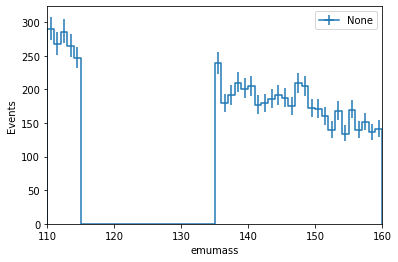

In [74]:
from coffea.util import save, load
from coffea import hist
histo = load("output.coffea")

%matplotlib inline
print(histo)
hist.plot1d(histo.integrate('dataset', 'data'))
print(histo.values()[('data',)].sum())
print(histo.values()[('TTTo2L2Nu',)].sum())
#hist.plot1d(histo.integrate('ept'))#.integrate('dataset', 'GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8'))
#hist.plot1d(histo['GluGlu_LFV_HToEMu'])
#hist.plot1d(histo.integrate('emumass')['data']) #.integrate('dataset', 'data'))

#hist.plot2d(histo.integrate('dataset'), xaxis='ept')
#print(histo.identifiers('dataset'))
#hist.plot1d(result['dataset']['GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8'].integrate('ept'))

<Hist (dataset,j1eta) instance at 0x7fcc98d947f0>


<AxesSubplot:xlabel='j1eta', ylabel='Events'>

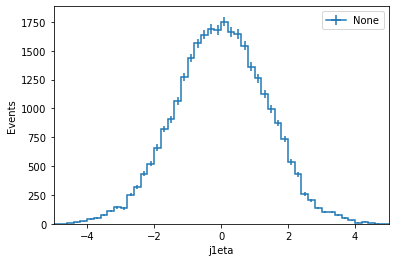

In [35]:
histo = load("output_data.coffea")

%matplotlib inline
print(histo)
hist.plot1d(histo.integrate('dataset', 'data'))

<AxesSubplot:xlabel='j1eta', ylabel='Events'>

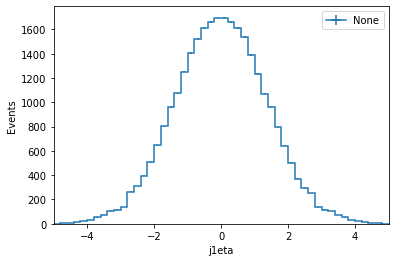

In [15]:
hist.plot1d(histo.integrate('dataset', 'TTTo2L2Nu'))

<AxesSubplot:xlabel='j1eta', ylabel='Events'>

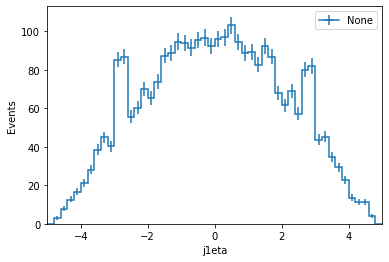

In [16]:
hist.plot1d(histo.integrate('dataset', 'GluGlu_LFV_HToEMu_M125'))

In [ ]:
import uproot3

fout = uproot3.recreate('output.root')

a = result.integrate('dataset', 'GluGlu_LFV_HToEMu').to_boost()
b = result.integrate('dataset', 'GluGlu_LFV_HToEMu').integrate('ept').to_boost()

fout['GluGlu_LFV_HToEMu_1d'] =  b.to_numpy()
fout['GluGlu_LFV_HToEMu_2d'] =  a.to_numpy()

fout.close()

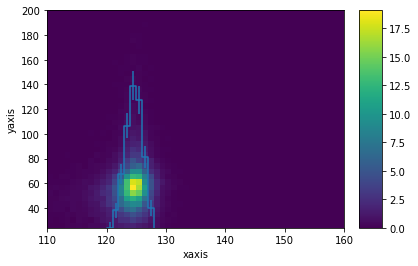

In [129]:
import uproot
fout = uproot.open('output.root')
fout['GluGlu_LFV_HToEMu_1d'].to_hist().plot()
#print(type(fout['GluGlu_LFV_HToEMu_1d'].to_hist()))
fout['GluGlu_LFV_HToEMu_2d'].to_hist().plot() #.show()
fout.close()